<a href="https://colab.research.google.com/github/keenbm/Housing-kaggle/blob/main/Kaggle_Submission_Final_Housing_Price_Prediction_Stable.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Package Import and Environment Setup

In [ ]:
##Install Kaggle pack.
!pip install kaggle
!pip install Autoviz
!pip install sweetviz

In [2]:
##Upload Kaggel API Credentials 
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"bhavikmodi","key":"ce4c830a192e5c7e4cd7ae4d320fcfac"}'}

In [3]:
## Create directory for Json file
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
## Assigning Permission
!chmod 600 ~/.kaggle/kaggle.json

In [4]:
## Importing Kaggle data
!kaggle competitions download -c house-prices-advanced-regression-techniques

  0% 0.00/199k [00:00<?, ?B/s]
100% 199k/199k [00:00<00:00, 60.1MB/s]


In [5]:
!unzip /content/house-prices-advanced-regression-techniques.zip -d /content


Archive:  /content/house-prices-advanced-regression-techniques.zip
  inflating: /content/data_description.txt  
  inflating: /content/sample_submission.csv  
  inflating: /content/test.csv       
  inflating: /content/train.csv      


In [12]:
!pip3 uninstall matplotlib -y
!pip3 install matplotlib==3.0.1

Found existing installation: matplotlib 3.5.2
Uninstalling matplotlib-3.5.2:
  Successfully uninstalled matplotlib-3.5.2
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.9/12.9 MB 67.3 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
sweetviz 2.1.4 requires matplotlib>=3.1.3, but you have matplotlib 3.0.1 which is incompatible.
plotnine 0.6.0 requires matplotlib>=3.1.1, but you have matplotlib 3.0.1 which is incompatible.
mizani 0.6.0 requires matplotlib>=3.1.1, but you have matplotlib 3.0.1 which is incompatible.
autoviz 0.1.41 requires matplotlib>=3.3.3, but you have matplotlib 3.0.1 which is incompatible.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


In [14]:
## Importing All major library
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
from matplotlib import style
style.use('ggplot')
# print(plt.style.available)
import seaborn as sns
import plotly.express as px
from plotly.subplots import make_subplots
import matplotlib.gridspec as gridspec
from scipy import stats
import plotly.io as pio
import datetime
import missingno as msno
from datetime import datetime
import pytz


In [15]:
print(plt.style.available)

['Solarize_Light2', '_classic_test_patch', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn', 'seaborn-bright', 'seaborn-colorblind', 'seaborn-dark', 'seaborn-dark-palette', 'seaborn-darkgrid', 'seaborn-deep', 'seaborn-muted', 'seaborn-notebook', 'seaborn-paper', 'seaborn-pastel', 'seaborn-poster', 'seaborn-talk', 'seaborn-ticks', 'seaborn-white', 'seaborn-whitegrid', 'tableau-colorblind10']


In [16]:
## Importing useful library for Machine Learning
# Library for Machine learning
from sklearn.pipeline import Pipeline

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import KFold 
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score,KFold
from sklearn.model_selection import GridSearchCV



from sklearn.impute import SimpleImputer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.linear_model import LinearRegression,BayesianRidge,ElasticNet,Ridge,Lasso
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor,AdaBoostRegressor
from xgboost import XGBRegressor

from sklearn.feature_selection import RFE
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

from sklearn.metrics import mean_absolute_error,mean_squared_error,r2_score,make_scorer

R2_scorer=make_scorer(r2_score)
MAE_scorer=make_scorer(mean_absolute_error)
MSE_scorer=make_scorer(mean_squared_error)

np.random.seed(12414)

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [17]:
## Function Credit :
## https://brendanhasz.github.io/2019/03/04/target-encoding
## https://github.com/brendanhasz/target-encoding/blob/master/Target_Encoding.ipynb
## Label Encoding

class LabelEncoder(BaseEstimator, TransformerMixin):
    """Label encoder.
    
    Replaces categorical column(s) with integer labels
    for each unique category in original column.

    """
    
    def __init__(self, cols=None):
        """Label encoder.
        
        Parameters
        ----------
        cols : list of str
            Columns to label encode.  Default is to label 
            encode all categorical columns in the DataFrame.
        """
        if isinstance(cols, str):
            self.cols = [cols]
        else:
            self.cols = cols
        
        
    def fit(self, X, y):
        """Fit label encoder to X and y
        
        Parameters
        ----------
        X : pandas DataFrame, shape [n_samples, n_columns]
            DataFrame containing columns to label encode
        y : pandas Series, shape = [n_samples]
            Target values.
            
        Returns
        -------
        self : encoder
            Returns self.
        """
        
        # Encode all categorical cols by default
        if self.cols is None:
            self.cols = [c for c in X if str(X[c].dtype)=='object']

        # Check columns are in X
        for col in self.cols:
            if col not in X:
                raise ValueError('Column \''+col+'\' not in X')

        # Create the map from objects to integers for each column
        self.maps = dict() #dict to store map for each column
        for col in self.cols:
            self.maps[col] = dict(zip(
                X[col].values, 
                X[col].astype('category').cat.codes.values
            ))
                        
        # Return fit object
        return self

        
    def transform(self, X, y=None):
        """Perform the label encoding transformation.
        
        Parameters
        ----------
        X : pandas DataFrame, shape [n_samples, n_columns]
            DataFrame containing columns to label encode
            
        Returns
        -------
        pandas DataFrame
            Input DataFrame with transformed columns
        """
        Xo = X.copy()
        for col, tmap in self.maps.items():
          
            # Map the column
            Xo[col] = Xo[col].map(tmap)
            
            # Convert to appropriate datatype
            max_val = max(tmap.values())
            if Xo[col].isnull().any(): #nulls, so use float!
                if max_val < 8388608:
                    dtype = 'float32'
                else:
                    dtype = 'float64'
            else:
                if max_val < 256:
                    dtype = 'uint8'
                elif max_val < 65536:
                    dtype = 'uint16'
                elif max_val < 4294967296:
                    dtype = 'uint32'
                else:
                    dtype = 'uint64'
            Xo[col] = Xo[col].astype(dtype)
            
        # Return encoded dataframe
        return Xo
            
            
    def fit_transform(self, X, y=None):
        """Fit and transform the data via label encoding.
        
        Parameters
        ----------
        X : pandas DataFrame, shape [n_samples, n_columns]
            DataFrame containing columns to label encode
        y : pandas Series, shape = [n_samples]
            Target values

        Returns
        -------
        pandas DataFrame
            Input DataFrame with transformed columns
        """
        return self.fit(X, y).transform(X, y)
# # Label encode the categorical data
# le = LabelEncoder()
# X_label_encoded = le.fit_transform(X_train, y_train)
# X_label_encoded.sample(10)

class OneHotEncoder(BaseEstimator, TransformerMixin):
    """One-hot encoder.
    
    Replaces categorical column(s) with binary columns 
    for each unique value in original column.

    """
    
    def __init__(self, cols=None, reduce_df=False):
        """One-hot encoder.
        
        Parameters
        ----------
        cols : list of str
            Columns to one-hot encode.  Default is to one-hot 
            encode all categorical columns in the DataFrame.
        reduce_df : bool
            Whether to use reduced degrees of freedom for encoding
            (that is, add N-1 one-hot columns for a column with N 
            categories). E.g. for a column with categories A, B, 
            and C: When reduce_df is True, A=[1, 0], B=[0, 1],
            and C=[0, 0].  When reduce_df is False, A=[1, 0, 0], 
            B=[0, 1, 0], and C=[0, 0, 1]
            Default = False
        """
        if isinstance(cols, str):
            self.cols = [cols]
        else:
            self.cols = cols
        self.reduce_df = reduce_df
        
        
    def fit(self, X, y):
        """Fit one-hot encoder to X and y
        
        Parameters
        ----------
        X : pandas DataFrame, shape [n_samples, n_columns]
            DataFrame containing columns to encode
        y : pandas Series, shape = [n_samples]
            Target values.
            
        Returns
        -------
        self : encoder
            Returns self.
        """
        
        # Encode all categorical cols by default
        if self.cols is None:
            self.cols = [c for c in X 
                         if str(X[c].dtype)=='object']

        # Check columns are in X
        for col in self.cols:
            if col not in X:
                raise ValueError('Column \''+col+'\' not in X')

        # Store each unique value
        self.maps = dict() #dict to store map for each column
        for col in self.cols:
            self.maps[col] = []
            uniques = X[col].unique()
            for unique in uniques:
                self.maps[col].append(unique)
            if self.reduce_df:
                del self.maps[col][-1]
        
        # Return fit object
        return self

        
    def transform(self, X, y=None):
        """Perform the one-hot encoding transformation.
        
        Parameters
        ----------
        X : pandas DataFrame, shape [n_samples, n_columns]
            DataFrame containing columns to one-hot encode
            
        Returns
        -------
        pandas DataFrame
            Input DataFrame with transformed columns
        """
        Xo = X.copy()
        for col, vals in self.maps.items():
            for val in vals:
                new_col = col+'_'+str(val)
                Xo[new_col] = (Xo[col]==val).astype('uint8')
            del Xo[col]
        return Xo
            
            
    def fit_transform(self, X, y=None):
        """Fit and transform the data via one-hot encoding.
        
        Parameters
        ----------
        X : pandas DataFrame, shape [n_samples, n_columns]
            DataFrame containing columns to one-hot encode
        y : pandas Series, shape = [n_samples]
            Target values

        Returns
        -------
        pandas DataFrame
            Input DataFrame with transformed columns
        """
        return self.fit(X, y).transform(X, y)

# # One-hot-encode the categorical data
# ohe = OneHotEncoder()
# X_one_hot = ohe.fit_transform(X_train, y_train)
# X_one_hot.sample(10)


class TargetEncoder(BaseEstimator, TransformerMixin):
    """Target encoder.
    
    Replaces categorical column(s) with the mean target value for
    each category.

    """
    
    def __init__(self, cols=None):
        """Target encoder
        
        Parameters
        ----------
        cols : list of str
            Columns to target encode.  Default is to target 
            encode all categorical columns in the DataFrame.
        """
        if isinstance(cols, str):
            self.cols = [cols]
        else:
            self.cols = cols
        
        
    def fit(self, X, y):
        """Fit target encoder to X and y
        
        Parameters
        ----------
        X : pandas DataFrame, shape [n_samples, n_columns]
            DataFrame containing columns to encode
        y : pandas Series, shape = [n_samples]
            Target values.
            
        Returns
        -------
        self : encoder
            Returns self.
        """
        
        # Encode all categorical cols by default
        if self.cols is None:
            self.cols = [col for col in X 
                         if str(X[col].dtype)=='object']

        # Check columns are in X
        for col in self.cols:
            if col not in X:
                raise ValueError('Column \''+col+'\' not in X')

        # Encode each element of each column
        self.maps = dict() #dict to store map for each column
        for col in self.cols:
            tmap = dict()
            uniques = X[col].unique()
            for unique in uniques:
                tmap[unique] = y[X[col]==unique].mean()
            self.maps[col] = tmap
            
        return self

        
    def transform(self, X, y=None):
        """Perform the target encoding transformation.
        
        Parameters
        ----------
        X : pandas DataFrame, shape [n_samples, n_columns]
            DataFrame containing columns to encode
            
        Returns
        -------
        pandas DataFrame
            Input DataFrame with transformed columns
        """
        Xo = X.copy()
        for col, tmap in self.maps.items():
            vals = np.full(X.shape[0], np.nan)
            for val, mean_target in tmap.items():
                vals[X[col]==val] = mean_target
            Xo[col] = vals
        return Xo
            
            
    def fit_transform(self, X, y=None):
        """Fit and transform the data via target encoding.
        
        Parameters
        ----------
        X : pandas DataFrame, shape [n_samples, n_columns]
            DataFrame containing columns to encode
        y : pandas Series, shape = [n_samples]
            Target values (required!).

        Returns
        -------
        pandas DataFrame
            Input DataFrame with transformed columns
        """
        return self.fit(X, y).transform(X, y)

# # Target encode the categorical data
# te = TargetEncoder()
# X_target_encoded = te.fit_transform(X_train, y_train)
# X_target_encoded.sample(10)


class TargetEncoderCV(TargetEncoder):
    """Cross-fold target encoder.
    """
    
    def __init__(self, n_splits=3, shuffle=True, cols=None):
        """Cross-fold target encoding for categorical features.
        
        Parameters
        ----------
        n_splits : int
            Number of cross-fold splits. Default = 3.
        shuffle : bool
            Whether to shuffle the data when splitting into folds.
        cols : list of str
            Columns to target encode.
        """
        self.n_splits = n_splits
        self.shuffle = shuffle
        self.cols = cols
        

    def fit(self, X, y):
        """Fit cross-fold target encoder to X and y
        
        Parameters
        ----------
        X : pandas DataFrame, shape [n_samples, n_columns]
            DataFrame containing columns to encode
        y : pandas Series, shape = [n_samples]
            Target values.
            
        Returns
        -------
        self : encoder
            Returns self.
        """
        self._target_encoder = TargetEncoder(cols=self.cols)
        self._target_encoder.fit(X, y)
        return self

    
    def transform(self, X, y=None):
        """Perform the target encoding transformation.

        Uses cross-fold target encoding for the training fold,
        and uses normal target encoding for the test fold.

        Parameters
        ----------
        X : pandas DataFrame, shape [n_samples, n_columns]
            DataFrame containing columns to encode

        Returns
        -------
        pandas DataFrame
            Input DataFrame with transformed columns
        """

        # Use target encoding from fit() if this is test data
        if y is None:
            return self._target_encoder.transform(X)

        # Compute means for each fold
        self._train_ix = []
        self._test_ix = []
        self._fit_tes = []
        kf = KFold(n_splits=self.n_splits, shuffle=self.shuffle)
        for train_ix, test_ix in kf.split(X):
            self._train_ix.append(train_ix)
            self._test_ix.append(test_ix)
            te = TargetEncoder(cols=self.cols)
            if isinstance(X, pd.DataFrame):
                self._fit_tes.append(te.fit(X.iloc[train_ix,:],
                                            y.iloc[train_ix]))
            elif isinstance(X, np.ndarray):
                self._fit_tes.append(te.fit(X[train_ix,:],
                                            y[train_ix]))
            else:
                raise TypeError('X must be DataFrame or ndarray')

        # Apply means across folds
        Xo = X.copy()
        for ix in range(len(self._test_ix)):
            test_ix = self._test_ix[ix]
            if isinstance(X, pd.DataFrame):
                Xo.iloc[test_ix,:] = \
                    self._fit_tes[ix].transform(X.iloc[test_ix,:])
            elif isinstance(X, np.ndarray):
                Xo[test_ix,:] = \
                    self._fit_tes[ix].transform(X[test_ix,:])
            else:
                raise TypeError('X must be DataFrame or ndarray')
        return Xo

            
    def fit_transform(self, X, y=None):
        """Fit and transform the data via target encoding.
        
        Parameters
        ----------
        X : pandas DataFrame, shape [n_samples, n_columns]
            DataFrame containing columns to encode
        y : pandas Series, shape = [n_samples]
            Target values (required!).

        Returns
        -------
        pandas DataFrame
            Input DataFrame with transformed columns
        """
        return self.fit(X, y).transform(X, y)

# # Cross-fold Target encode the categorical data
# te = TargetEncoderCV()
# X_target_encoded_cv = te.fit_transform(X_train, y_train)
# X_target_encoded_cv.sample(10)


class TargetEncoderLOO(TargetEncoder):
    """Leave-one-out target encoder.
    """
    
    def __init__(self, cols=None):
        """Leave-one-out target encoding for categorical features.
        
        Parameters
        ----------
        cols : list of str
            Columns to target encode.
        """
        self.cols = cols
        

    def fit(self, X, y):
        """Fit leave-one-out target encoder to X and y
        
        Parameters
        ----------
        X : pandas DataFrame, shape [n_samples, n_columns]
            DataFrame containing columns to target encode
        y : pandas Series, shape = [n_samples]
            Target values.
            
        Returns
        -------
        self : encoder
            Returns self.
        """
        
        # Encode all categorical cols by default
        if self.cols is None:
            self.cols = [col for col in X
                         if str(X[col].dtype)=='object']

        # Check columns are in X
        for col in self.cols:
            if col not in X:
                raise ValueError('Column \''+col+'\' not in X')

        # Encode each element of each column
        self.sum_count = dict()
        for col in self.cols:
            self.sum_count[col] = dict()
            uniques = X[col].unique()
            for unique in uniques:
                ix = X[col]==unique
                self.sum_count[col][unique] = \
                    (y[ix].sum(),ix.sum())
            
        # Return the fit object
        return self

    
    def transform(self, X, y=None):
        """Perform the target encoding transformation.

        Uses leave-one-out target encoding for the training fold,
        and uses normal target encoding for the test fold.

        Parameters
        ----------
        X : pandas DataFrame, shape [n_samples, n_columns]
            DataFrame containing columns to encode

        Returns
        -------
        pandas DataFrame
            Input DataFrame with transformed columns
        """
        
        # Create output dataframe
        Xo = X.copy()

        # Use normal target encoding if this is test data
        if y is None:
            for col in self.sum_count:
                vals = np.full(X.shape[0], np.nan)
                for cat, sum_count in self.sum_count[col].items():
                    vals[X[col]==cat] = sum_count[0]/sum_count[1]
                Xo[col] = vals

        # LOO target encode each column
        else:
            for col in self.sum_count:
                vals = np.full(X.shape[0], np.nan)
                for cat, sum_count in self.sum_count[col].items():
                    ix = X[col]==cat
                    vals[ix] = (sum_count[0]-y[ix])/(sum_count[1]-1)
                Xo[col] = vals
            
        # Return encoded DataFrame
        return Xo
      
            
    def fit_transform(self, X, y=None):
        """Fit and transform the data via target encoding.
        
        Parameters
        ----------
        X : pandas DataFrame, shape [n_samples, n_columns]
            DataFrame containing columns to encode
        y : pandas Series, shape = [n_samples]
            Target values (required!).

        Returns
        -------
        pandas DataFrame
            Input DataFrame with transformed columns
        """
        return self.fit(X, y).transform(X, y)
#   # Cross-fold Target encode the categorical data
# te = TargetEncoderLOO()
# X_target_encoded_loo = te.fit_transform(X_train, y_train)
# X_target_encoded_loo.sample(10)

## Step 1 : Loading and Analysing data

In [18]:
## Loading Train Test data
data_df=pd.read_csv("train.csv")
tst_df=pd.read_csv("test.csv")
data_df=pd.concat([data_df,tst_df],ignore_index=True)

In [19]:
## Analysing above value and Changing data Types
df_ID=data_df["Id"]
df_Y=data_df["SalePrice"]
data_df.drop("Id",axis=1,inplace=True)
data_df.drop("SalePrice",axis=1,inplace=True)

In [20]:
# import sweetviz as sv
# my_report = sv.analyze(data_df,target_feat="SalePrice",feat_cfg = None) # feat_cfg = feature_config
# my_report.show_html() # Default arguments will generate to "SWEETVIZ_REPORT.html"
# #feature_config = sv.FeatureConfig(skip="PassengerId", force_text=["Age"])

# ## Compare Two DataFrame i.e. e.g. Test vs Training sets
# ## my_report = sv.compare([my_dataframe, "Training Data"], [test_df, "Test Data"], "Survived", feature_config)
# ## Comparing two subsets of the same dataframe (e.g. Male vs Female)
## my_report = sv.compare_intra(my_dataframe, my_dataframe["Sex"] == "male", ["Male", "Female"], feature_config)

## Step 2 : Preprocessing

### Step 2.1 : Null Value treatment

In [21]:
## Checking Null Values
def getNullPc(df,plot_graph):
  null_df=pd.concat([pd.DataFrame(round(100*(df.isnull().sum())/len(df),2)),
                    pd.DataFrame(df.dtypes)],
                   axis=1).reset_index()
  null_df.columns= ["Feature","NullPc","Dtype"]
  null_df=null_df.loc[null_df.NullPc!=0]
  null_df.sort_values(by=["Dtype","NullPc"],ascending=False,inplace=True)
  null_df.reset_index(drop=True,inplace=True)
  pd.set_option("display.max_rows", None)
  
  if plot_graph==True:
    fig = plt.figure(constrained_layout=False, figsize=(24,12))## Width , Height
    grid = gridspec.GridSpec(ncols=2, nrows=1, figure=fig) 
  
    ax1 = fig.add_subplot(grid[0, 0]) ## 1st Row, 1 Column
    ax1.set_title('Null Values Heatmap')
    msno.heatmap(data_df,ax=ax1)
    plt.xticks(rotation=90)
    ax1.text(1, 1,'-',
             horizontalalignment='center',
             verticalalignment='center',
             transform = ax1.transAxes)
    
    ax2 = fig.add_subplot(grid[0, 1]) ## 1st Row, 2 Column
    ax2.set_title('Null Values % Count')
    sns.barplot(y="NullPc",x="Feature",data=null_df,ax=ax2)
    plt.axhline(y=30)
    plt.xticks(rotation=90)
    vals=null_df.to_string()
    ax2.text(1, 1,vals,
             horizontalalignment='left',
             verticalalignment='center',
             transform = ax2.transAxes)
    for p in ax2.patches:
          ax2.annotate('{:.0f} %'.format(p.get_height()),(p.get_x()+0.2, p.get_height()+2))
    ax2.set_facecolor('white')
    
    fig.tight_layout()
    plt.show()
    pdf = PdfPages("/content/Null Values " +datetime.now(pytz.timezone('Asia/Kolkata')).strftime("%d-%m-%y_%H%M")+ ".pdf")
    pdf.savefig(fig)
    pdf.close()
  
  return null_df

In [22]:
nulldf=getNullPc(data_df,plot_graph=False)
nulldf

Feature  NullPc    Dtype
0         PoolQC   99.66   object
1    MiscFeature   96.40   object
2          Alley   93.22   object
3          Fence   80.44   object
4    FireplaceQu   48.65   object
5   GarageFinish    5.45   object
6     GarageQual    5.45   object
7     GarageCond    5.45   object
8     GarageType    5.38   object
9       BsmtCond    2.81   object
10  BsmtExposure    2.81   object
11      BsmtQual    2.77   object
12  BsmtFinType2    2.74   object
13  BsmtFinType1    2.71   object
14    MasVnrType    0.82   object
15      MSZoning    0.14   object
16     Utilities    0.07   object
17    Functional    0.07   object
18   Exterior1st    0.03   object
19   Exterior2nd    0.03   object
20    Electrical    0.03   object
21   KitchenQual    0.03   object
22      SaleType    0.03   object
23   LotFrontage   16.65  float64
24   GarageYrBlt    5.45  float64
25    MasVnrArea    0.79  float64
26  BsmtFullBath    0.07  float64
27  BsmtHalfBath    0.07  float64
28    BsmtFinSF1    0.03  float64
29    BsmtFinSF2    0.03  float64
30     BsmtUnfSF    0.03  float64
31   TotalBsmtSF    0.03  float64
32    GarageCars    0.03  float64
33    GarageArea    0.03  float64

In [23]:
## Droping Col. Which are having more than 30% NA Valuse
data_df = data_df.loc[:, data_df.isna().mean() < 0.3]
nulldf=getNullPc(data_df,plot_graph=False)

In [24]:
def null_val_analysis(src_df,nulldf,type):
  if type=="object":
    for i in range(len(nulldf)):
      if nulldf.loc[i,"Dtype"]=="object":
        print(src_df[nulldf.loc[i,"Feature"]].value_counts(normalize=True))
        print(" Null percentage is "+ str(nulldf.loc[i,"NullPc"]))
        print("_______________________")
        print("_______________________")
  if type=="float" or type=="int":
    for i in range(len(nulldf)):
      if nulldf.loc[i,"Dtype"]=="float" or nulldf.loc[i,"Dtype"]=="int":
        print(src_df[nulldf.loc[i,"Feature"]].describe())
        print(" Null percentage is "+ str(nulldf.loc[i,"NullPc"]))
        print("_______________________")
        print("_______________________")

In [25]:
null_val_analysis(data_df,nulldf,"float")

count    2433.000000
mean       69.305795
std        23.344905
min        21.000000
25%        59.000000
50%        68.000000
75%        80.000000
max       313.000000
Name: LotFrontage, dtype: float64
 Null percentage is 16.65
_______________________
_______________________
count    2760.000000
mean     1978.113406
std        25.574285
min      1895.000000
25%      1960.000000
50%      1979.000000
75%      2002.000000
max      2207.000000
Name: GarageYrBlt, dtype: float64
 Null percentage is 5.45
_______________________
_______________________
count    2896.000000
mean      102.201312
std       179.334253
min         0.000000
25%         0.000000
50%         0.000000
75%       164.000000
max      1600.000000
Name: MasVnrArea, dtype: float64
 Null percentage is 0.79
_______________________
_______________________
count    2917.000000
mean        0.429894
std         0.524736
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max         3.000000
Name: B

In [26]:
## Replacing NaN with mean/median
data_df.LotFrontage.fillna(data_df.LotFrontage.mean(),inplace=True)
data_df.GarageYrBlt.fillna(data_df.GarageYrBlt.mode()[0],inplace=True)
data_df.MasVnrArea.fillna(data_df.MasVnrArea.mean(),inplace=True)
data_df.BsmtHalfBath.fillna(data_df.BsmtHalfBath.mode()[0],inplace=True)
data_df.BsmtFinSF1.fillna(data_df.BsmtFinSF1.mean(),inplace=True)
data_df.BsmtFinSF2.fillna(data_df.BsmtFinSF2.mean(),inplace=True)
data_df.BsmtUnfSF.fillna(data_df.BsmtUnfSF.mean(),inplace=True)
data_df.TotalBsmtSF.fillna(data_df.TotalBsmtSF.mean(),inplace=True)
data_df.GarageCars.fillna(data_df.GarageCars.mode()[0],inplace=True)
data_df.GarageArea.fillna(data_df.GarageArea.mean(),inplace=True)
data_df.BsmtFullBath.fillna(data_df.BsmtFullBath.mode()[0],inplace=True)

nulldf=getNullPc(data_df,plot_graph=False)
nulldf

Feature  NullPc   Dtype
0   GarageFinish    5.45  object
1     GarageQual    5.45  object
2     GarageCond    5.45  object
3     GarageType    5.38  object
4       BsmtCond    2.81  object
5   BsmtExposure    2.81  object
6       BsmtQual    2.77  object
7   BsmtFinType2    2.74  object
8   BsmtFinType1    2.71  object
9     MasVnrType    0.82  object
10      MSZoning    0.14  object
11     Utilities    0.07  object
12    Functional    0.07  object
13   Exterior1st    0.03  object
14   Exterior2nd    0.03  object
15    Electrical    0.03  object
16   KitchenQual    0.03  object
17      SaleType    0.03  object

In [27]:
null_val_analysis(data_df,nulldf,"object")

Unf    0.445652
RFn    0.293841
Fin    0.260507
Name: GarageFinish, dtype: float64
 Null percentage is 5.45
_______________________
_______________________
TA    0.943478
Fa    0.044928
Gd    0.008696
Po    0.001812
Ex    0.001087
Name: GarageQual, dtype: float64
 Null percentage is 5.45
_______________________
_______________________
TA    0.961594
Fa    0.026812
Gd    0.005435
Po    0.005072
Ex    0.001087
Name: GarageCond, dtype: float64
 Null percentage is 5.45
_______________________
_______________________
Attchd     0.623823
Detchd     0.282042
BuiltIn    0.067343
Basment    0.013034
2Types     0.008327
CarPort    0.005431
Name: GarageType, dtype: float64
 Null percentage is 5.38
_______________________
_______________________
TA    0.918576
Gd    0.043003
Fa    0.036658
Po    0.001762
Name: BsmtCond, dtype: float64
 Null percentage is 2.81
_______________________
_______________________
No    0.671131
Av    0.147339
Gd    0.097286
Mn    0.084244
Name: BsmtExposure, dtype: float

In [28]:
## Replacing NaN of Object datatype witH mode

data_df.GarageType.fillna(data_df.GarageType.mode()[0],inplace=True)
data_df.GarageFinish.fillna(data_df.GarageFinish.mode()[0],inplace=True)
data_df.GarageQual.fillna(data_df.GarageQual.mode()[0],inplace=True)
data_df.GarageCond.fillna(data_df.GarageCond.mode()[0],inplace=True)
data_df.BsmtExposure.fillna(data_df.BsmtExposure.mode()[0],inplace=True)
data_df.BsmtFinType2.fillna(data_df.BsmtFinType2.mode()[0],inplace=True)
data_df.BsmtQual.fillna(data_df.BsmtQual.mode()[0],inplace=True)
data_df.BsmtCond.fillna(data_df.BsmtCond.mode()[0],inplace=True)
data_df.BsmtFinType1.fillna(data_df.BsmtFinType1.mode()[0],inplace=True)
data_df.Electrical.fillna(data_df.Electrical.mode()[0],inplace=True)

data_df.MasVnrType.fillna(data_df.MasVnrType.mode()[0],inplace=True)
data_df.MSZoning.fillna(data_df.MSZoning.mode()[0],inplace=True)
data_df.Utilities.fillna(data_df.Utilities.mode()[0],inplace=True)
data_df.Functional.fillna(data_df.Functional.mode()[0],inplace=True)
data_df.Exterior1st.fillna(data_df.Exterior1st.mode()[0],inplace=True)
data_df.Exterior2nd.fillna(data_df.Exterior2nd.mode()[0],inplace=True)
data_df.KitchenQual.fillna(data_df.KitchenQual.mode()[0],inplace=True)
data_df.SaleType.fillna(data_df.SaleType.mode()[0],inplace=True)

nulldf=getNullPc(data_df,plot_graph=False)
nulldf

Empty DataFrame
Columns: [Feature, NullPc, Dtype]
Index: []

### Step 2.2 : Outlier Treatment

In [29]:
data_df_wo_trtment=data_df.copy()

In [30]:
def get_outlier(df,plot_graph):
  # df=df.select_dtypes(include=["int","float"])

  Min=df.quantile(0)
  Q = df.quantile(0.01)
  Q05 = df.quantile(0.05)
  Q1 = df.quantile(0.25)
  Q2 = df.quantile(0.50)
  Q3 = df.quantile(0.75)
  Q95 = df.quantile(0.95)
  Q99 = df.quantile(0.99)
  Max=df.quantile(1)
  IQR = Q3 - Q1
  
  outlier_df=pd.DataFrame()
  outlier_df=pd.concat([Min,Q,Q05,Q1,Q2,Q3,Q95,Q99,Max], axis=1)
  outlier_df.columns=["Min","1Pc","5Pc","25Pc","50Pc","75Pc","95Pc","99Pc","Max"]


  ## For Skewed Distribution Below Mentioned limits need to be used
  outlier_df["Lower_Fence"]=(Q1 - 1.5 * IQR)
  outlier_df["Upper_Fence"]=(Q3 + 1.5 * IQR)

  ## If we have Extream oultier in Skewed Distrubution , following limits need to be followed
  ## outlier_df["Lower_Fence"]=(Q1 - 3 * IQR)  or 
  ## outlier_df["Upper_Fence"]=(Q3 + 3 * IQR)  or 

  # If data is having Noraml/Gaussian Distribution following limit shall be used:
  # lower limit= mean - 3* Std. --->>99.7%
  # upper limit= mean + 3* Std. --->>99.7%
  
  outlier_df["Qty_Lower_Outlier"]=pd.DataFrame((df < (Q1 - 1.5 * IQR))).sum(axis = 0)
  outlier_df["Qty_Higher_Outlier"]=pd.DataFrame((df > (Q3 + 1.5 * IQR))).sum(axis = 0)
  outlier_df["Qty_Total_Outlier"]=outlier_df["Qty_Lower_Outlier"]+outlier_df["Qty_Higher_Outlier"]

  outlier_df["Qty_Pc_Below_1Pc"]=round(pd.DataFrame((df < Q)).sum(axis = 0)/len(df),2)
  outlier_df["Qty_Pc_Above_5Pc"]=round(pd.DataFrame((df < Q05)).sum(axis = 0)/len(df),2)
  outlier_df["Qty_Pc_Above_95Pc"]=round(pd.DataFrame((df > Q95)).sum(axis = 0)/len(df),2)
  outlier_df["Qty_Pc_Above_99Pc"]=round(pd.DataFrame((df > Q99)).sum(axis = 0)/len(df),2)
  outlier_df["Outlier_Perc"]=round(100*outlier_df["Qty_Total_Outlier"]/len(df))
  outlier_df["Skew"]=df.skew()
  #outlier_df=outlier_df.loc[outlier_df["Qty_Total_Outlier"]>0]
  outlier_df.sort_values(by="Qty_Total_Outlier",ascending=False,inplace=True)
  outlier_df=outlier_df.transpose().round(2)

  if plot_graph==True:
    for column in outlier_df:
      fig = plt.figure(constrained_layout=False, figsize=(24,12))## Width , Height
      grid = gridspec.GridSpec(ncols=2, nrows=2, figure=fig)
      
      ax1 = fig.add_subplot(grid[0, 0]) ## 1st Row, 1 Column
      ax1.set_title('Plotting data for the column: '+ column)
      sns.boxplot(x= column, data = df, ax = ax1)
      vals=outlier_df[column].to_string()
      ax1.text(1, 0.5,vals,
          horizontalalignment='right',
          verticalalignment='center',
          transform = ax1.transAxes)
      
      ax2 = fig.add_subplot(grid[1, 0]) ## 2st Row, 1 Column
      ax2.set_title('Distributuin Plot for : '+column)
      sns.distplot(df[column],ax = ax2) 

      if str(df[column].dtypes)=="int64" or str(df[column].dtypes)=="float64":
        ax3 = fig.add_subplot(grid[0, 1]) ## 2st Row, 1 Column
        stats.probplot(df[column],plot=ax3)
        ax3.set_title('Plotting QQ Curve for :'+ column)
        vals= "Skewness: " + str(df[column].skew().round(3)) + ",Kurtosis: " + str(df[column].kurt().round(3))
        ax3.text(0.5, 0.5,vals,
          horizontalalignment='right',
          verticalalignment='center',
          transform = ax3.transAxes,color='b', weight='bold',fontsize = 12)
        
        ax4 = fig.add_subplot(grid[1, 1]) ## 2st Row, 1 Column
        stats.probplot(np.log1p(df[column]),plot=ax4)
        ax4.set_title('Plotting QQ Curve for :' +'log('+ column+')')
        vals= "Skewness: " + str(np.log1p(df[column]).skew().round(3)) + ",Kurtosis: " + str(np.log1p(df[column]).kurt().round(3))
        ax4.text(0.5, 0.5,vals,
          horizontalalignment='right',
          verticalalignment='center',
          transform = ax4.transAxes)
                            
      fig.tight_layout()
      plt.show()
    pdf = PdfPages("/content/Outlier_Analysis " +datetime.now(pytz.timezone('Asia/Kolkata')).strftime("%d-%m-%y_%H%M")+ ".pdf")
    pdf.savefig(fig)
    pdf.close()

  return outlier_df

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: FutureWarning: Automatic reindexing on DataFrame vs Series comparisons is deprecated and will raise ValueError in a future version.  Do `left, right = left.align(right, axis=1, copy=False)` before e.g. `left == right`
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: FutureWarning: Automatic reindexing on DataFrame vs Series comparisons is deprecated and will raise ValueError in a future version.  Do `left, right = left.align(right, axis=1, copy=False)` before e.g. `left == right`
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:36: FutureWarning: Automatic reindexing on DataFrame vs Series comparisons is deprecated and will raise ValueError in a future version.  Do `left, right = left.align(right, axis=1, copy=False)` before e.g. `left == right`
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:37: FutureWarning: Automatic reindexing on DataFrame vs Series comparisons is deprecated a

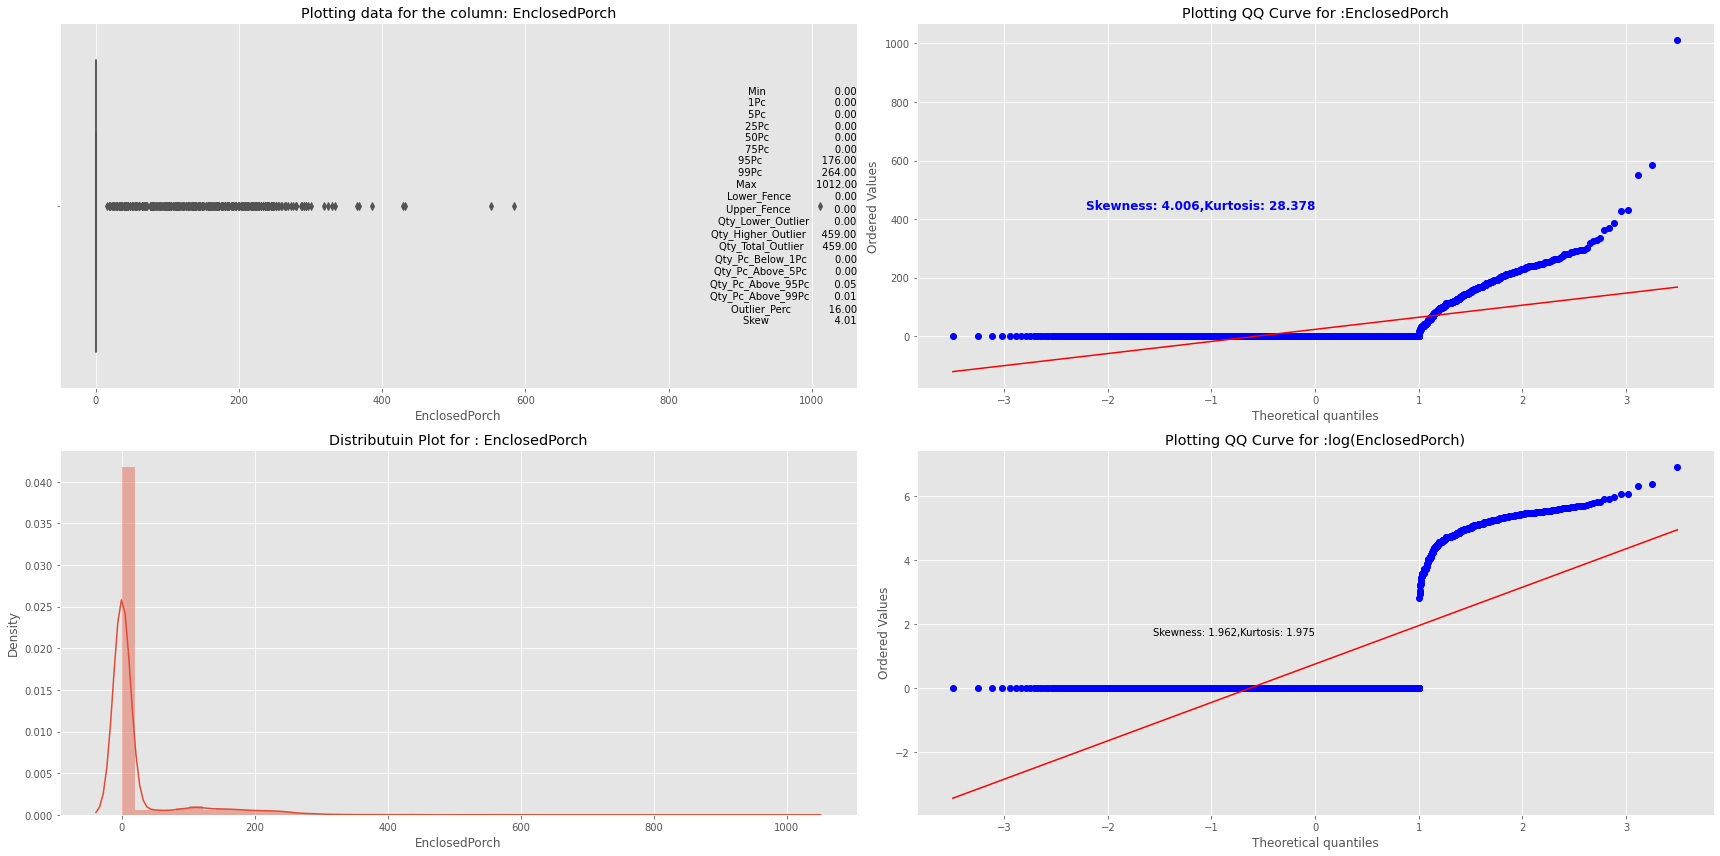

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


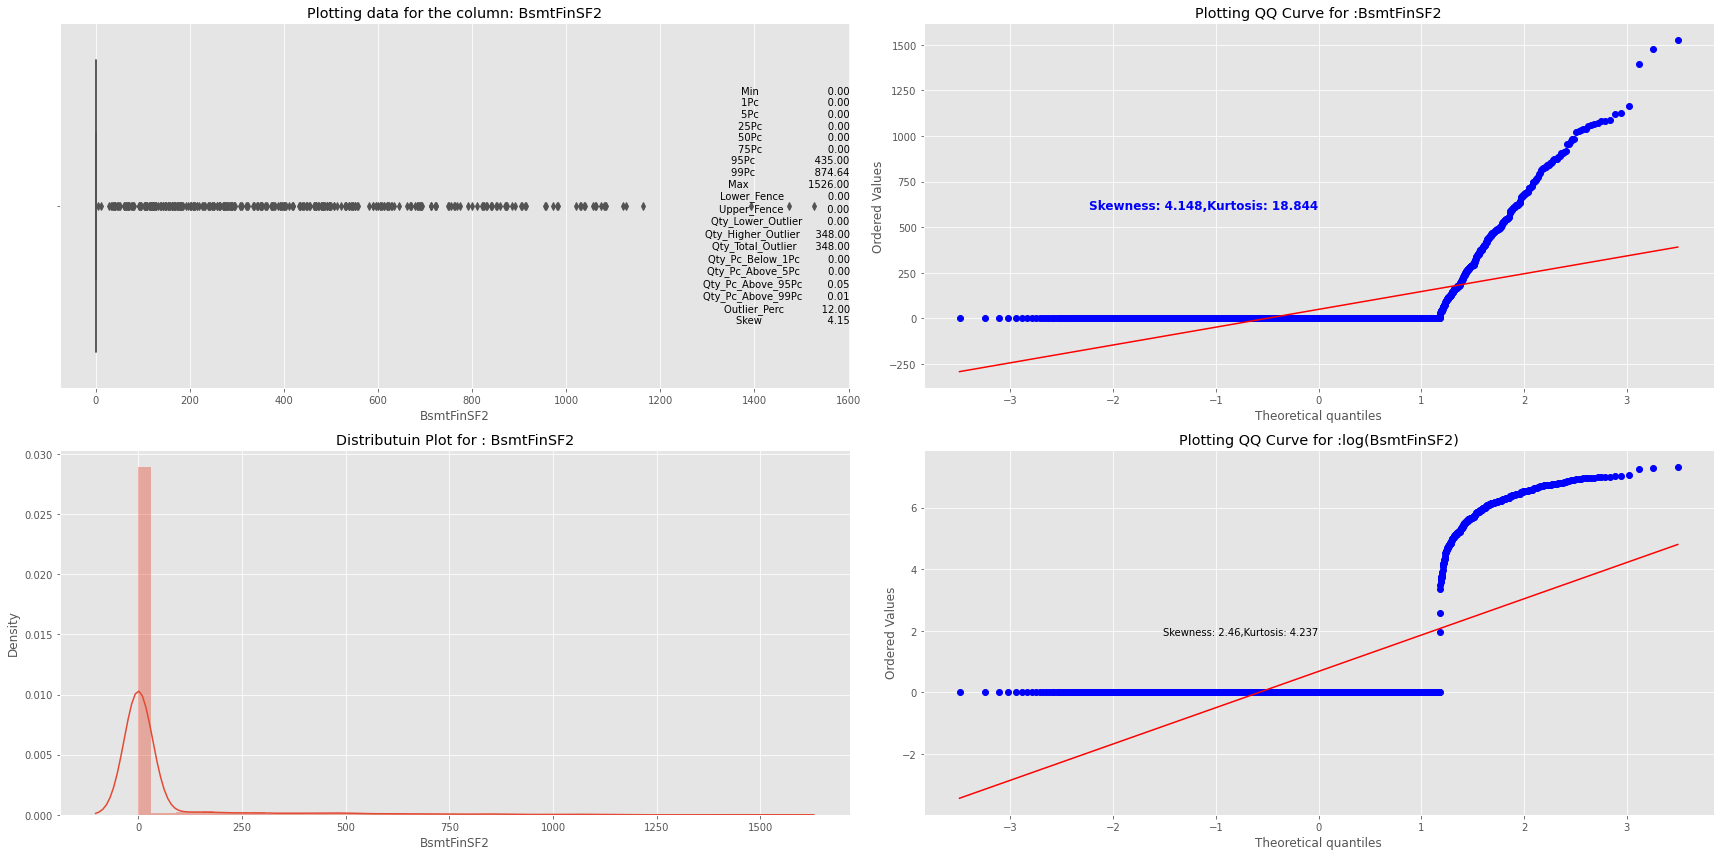

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


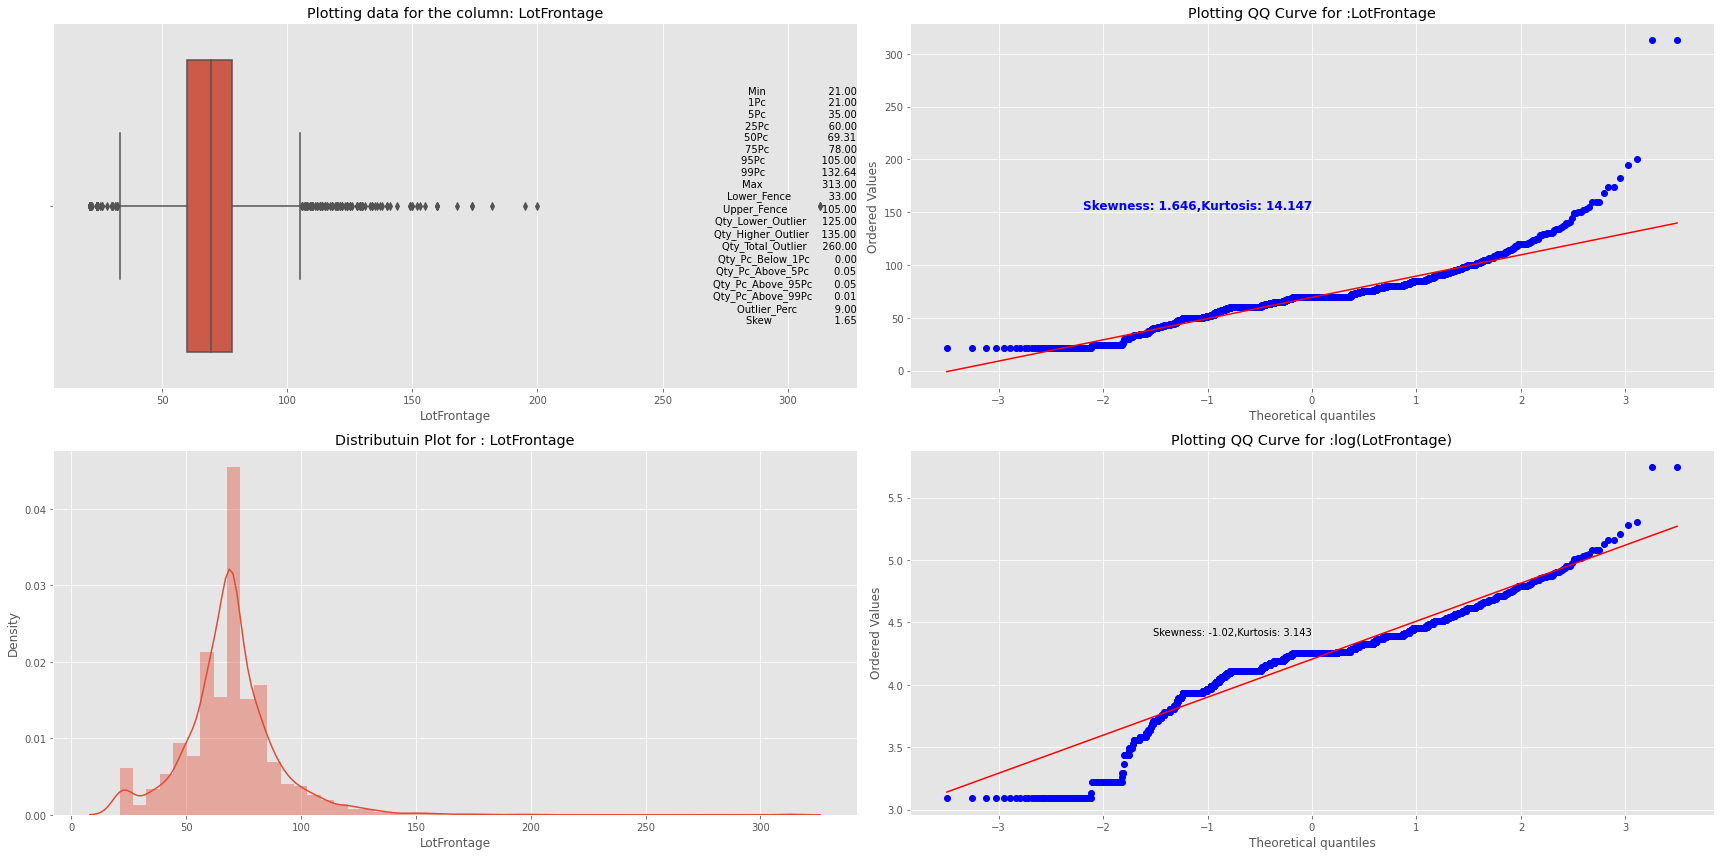

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


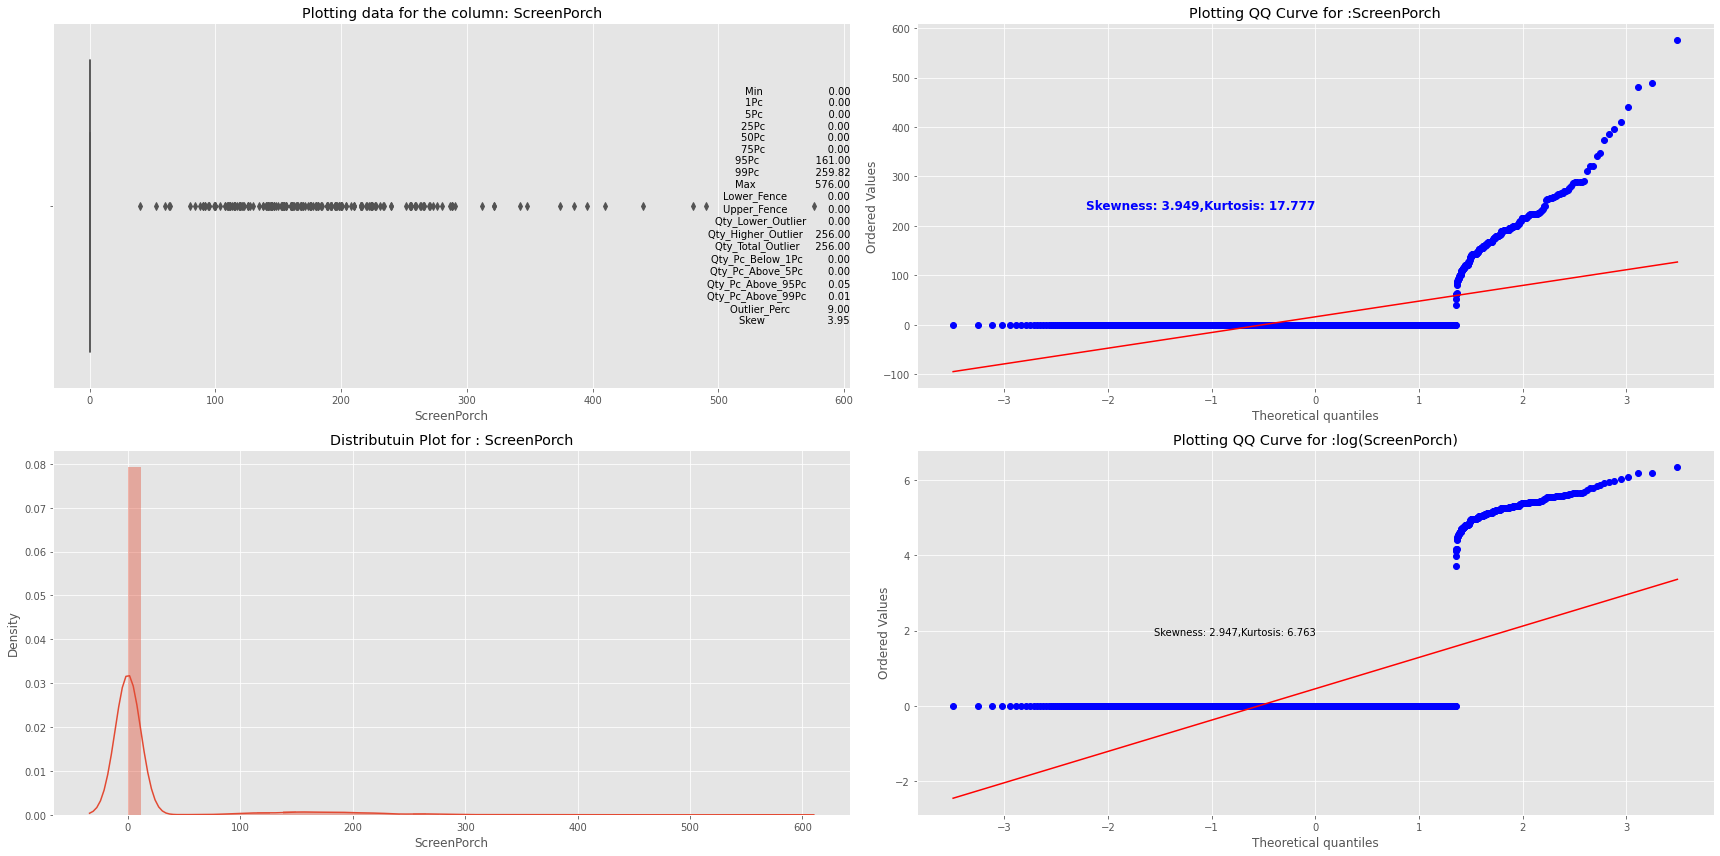

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


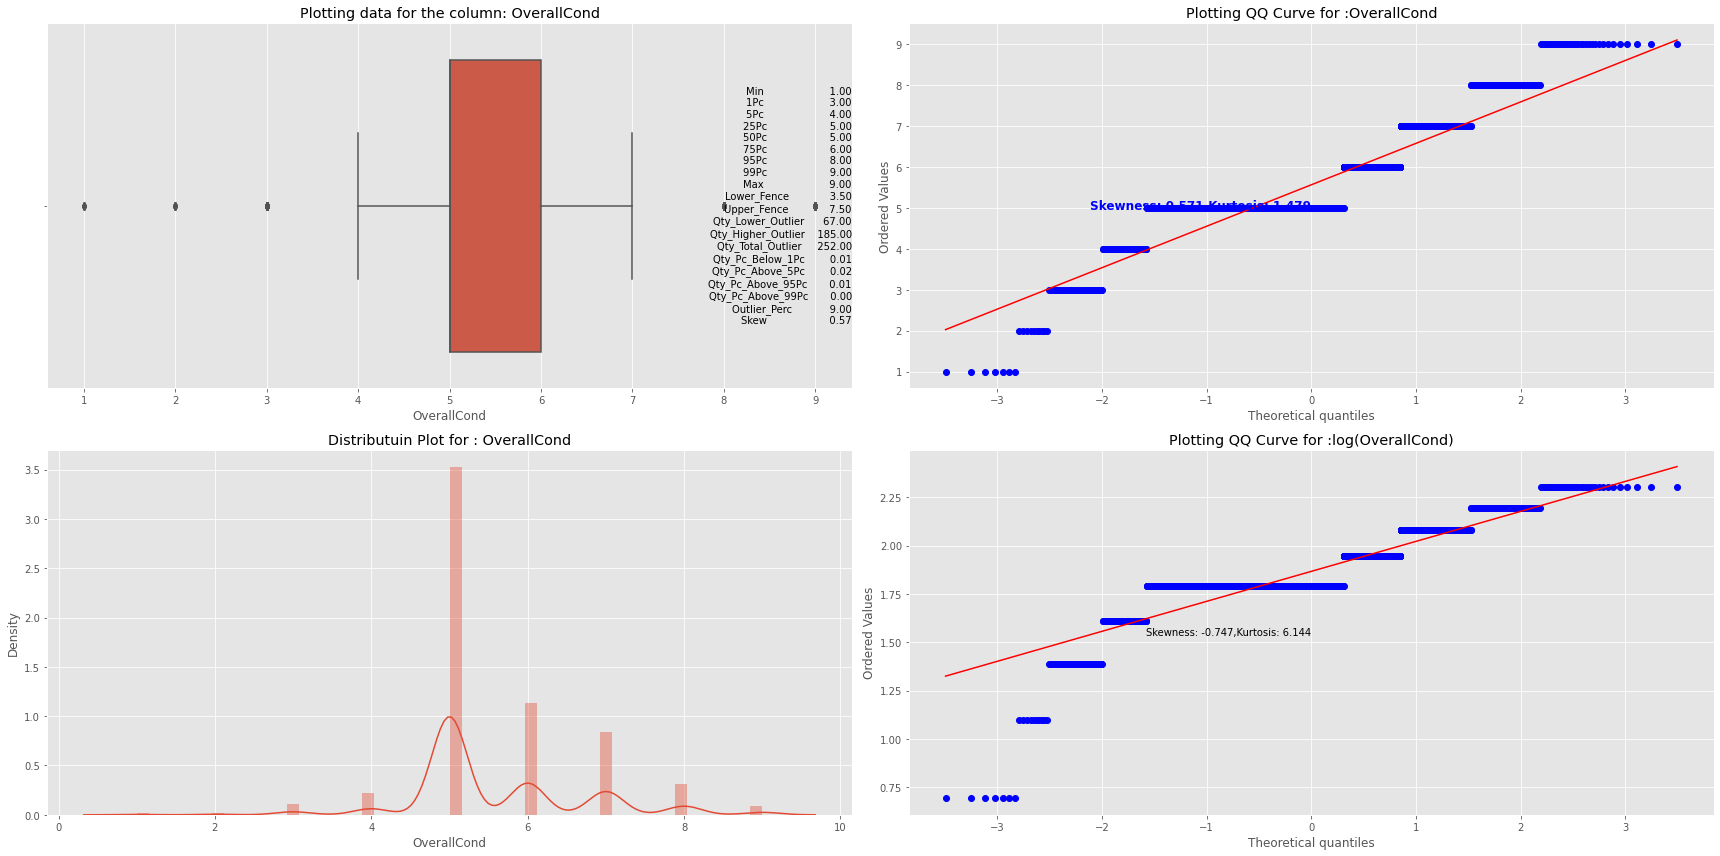

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


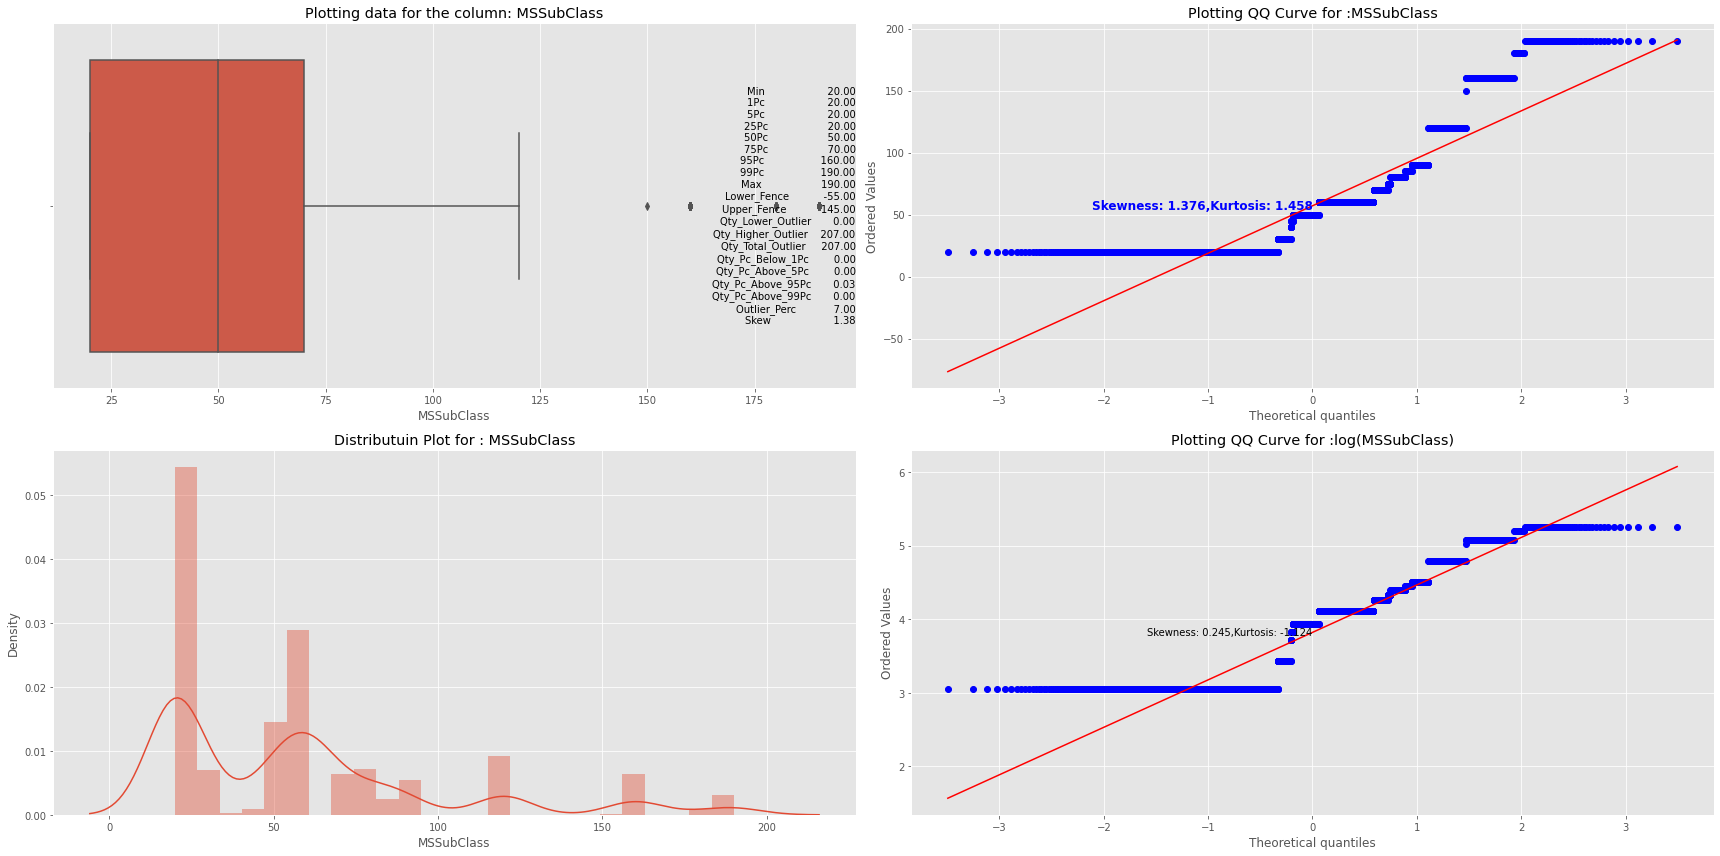

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


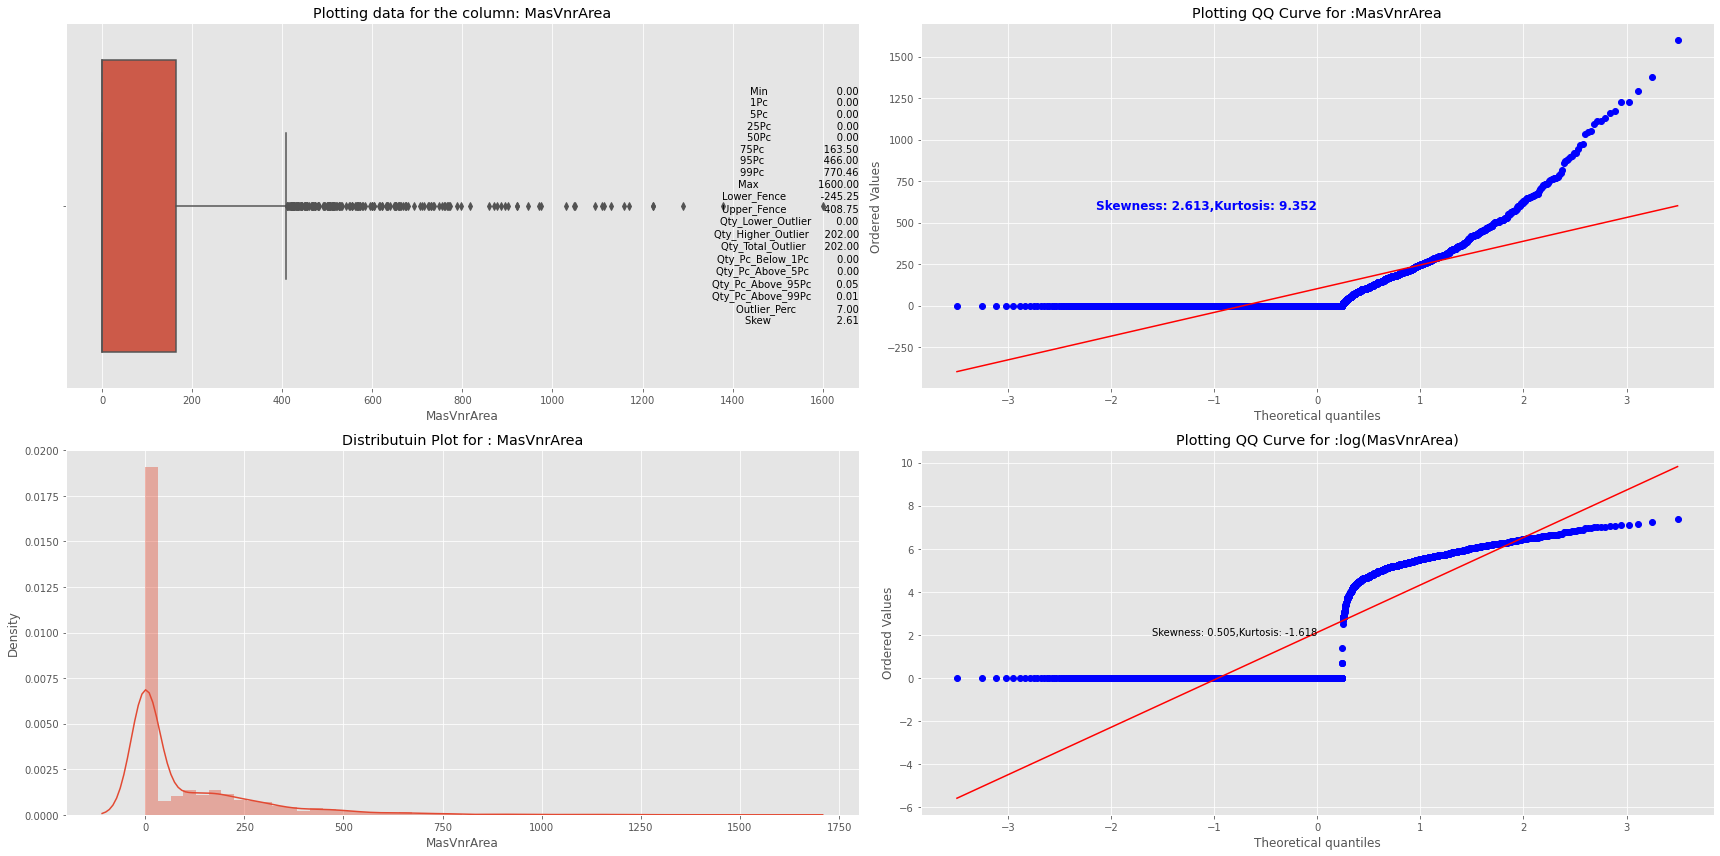

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


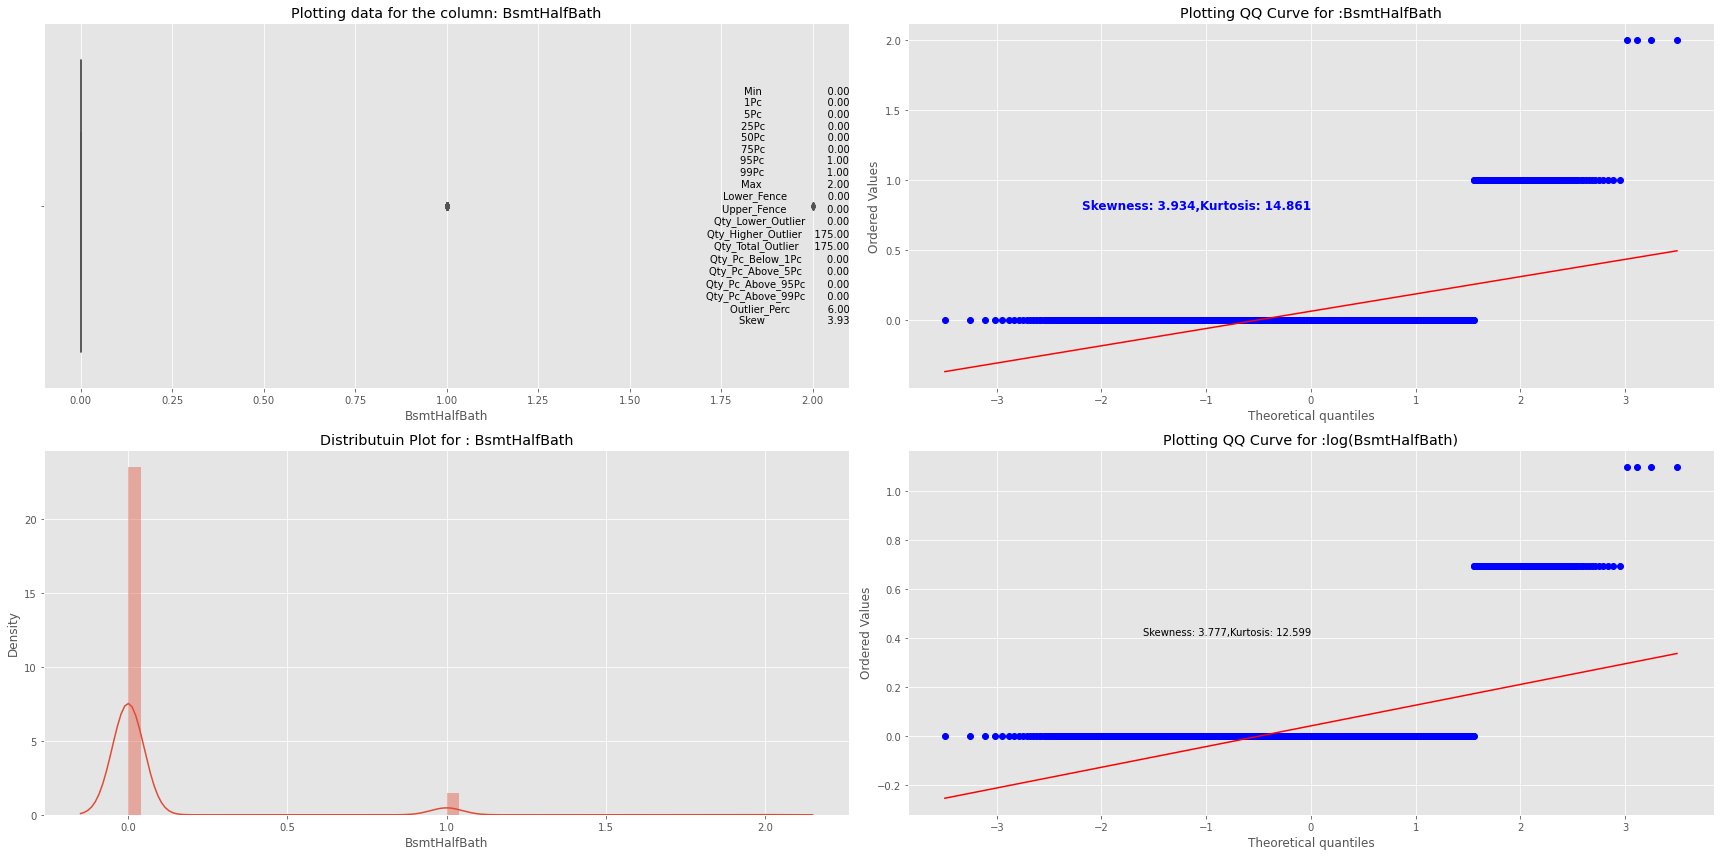

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


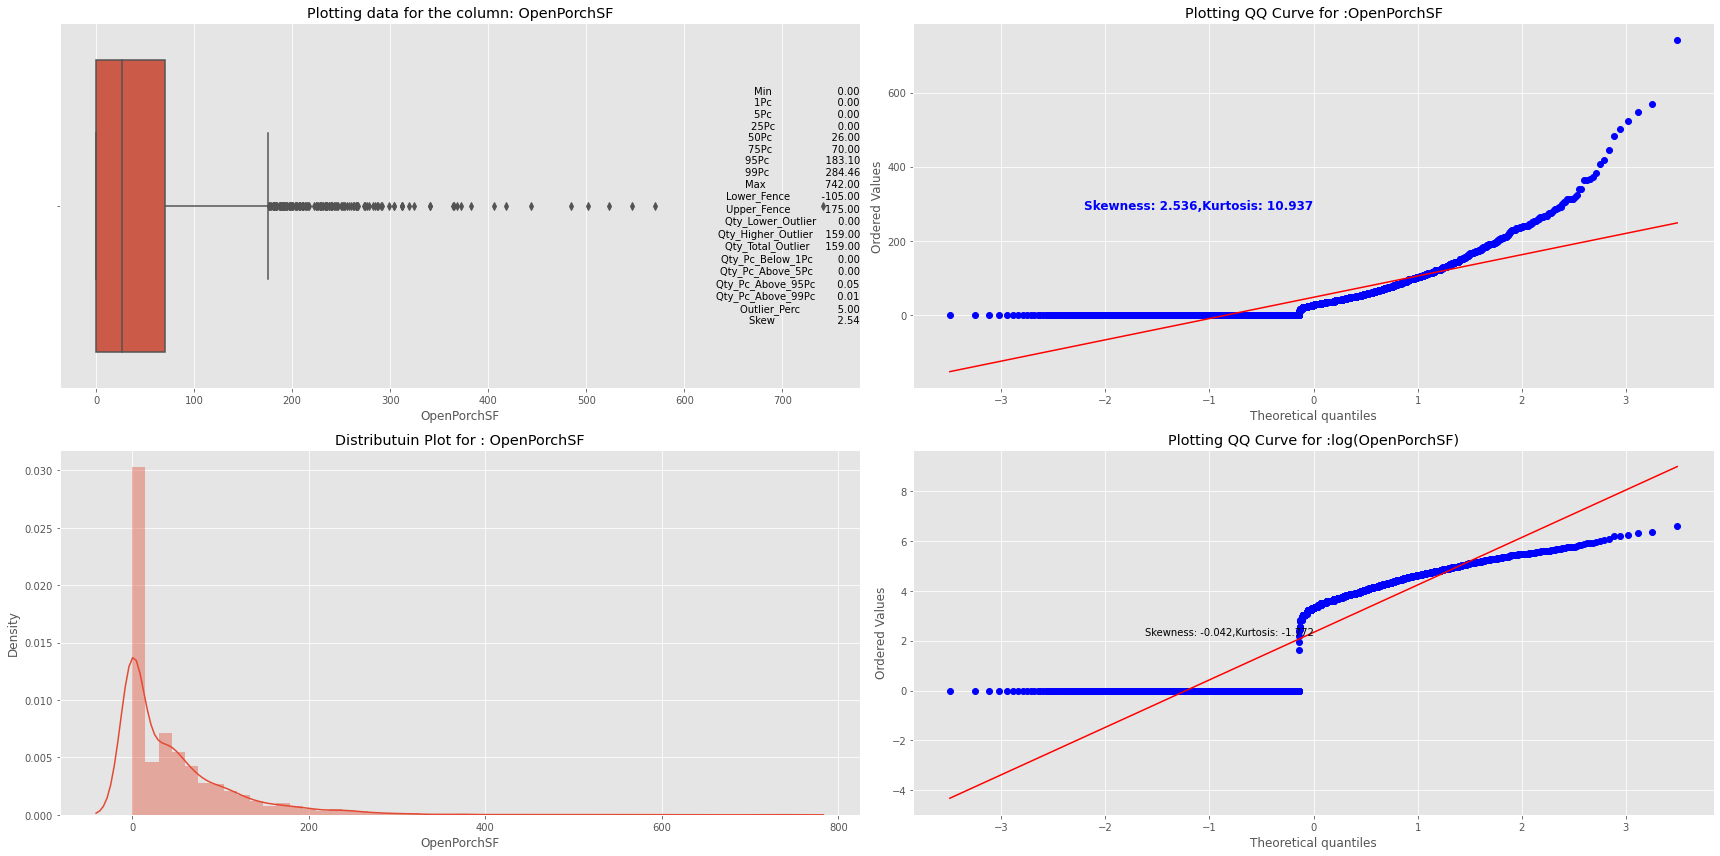

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


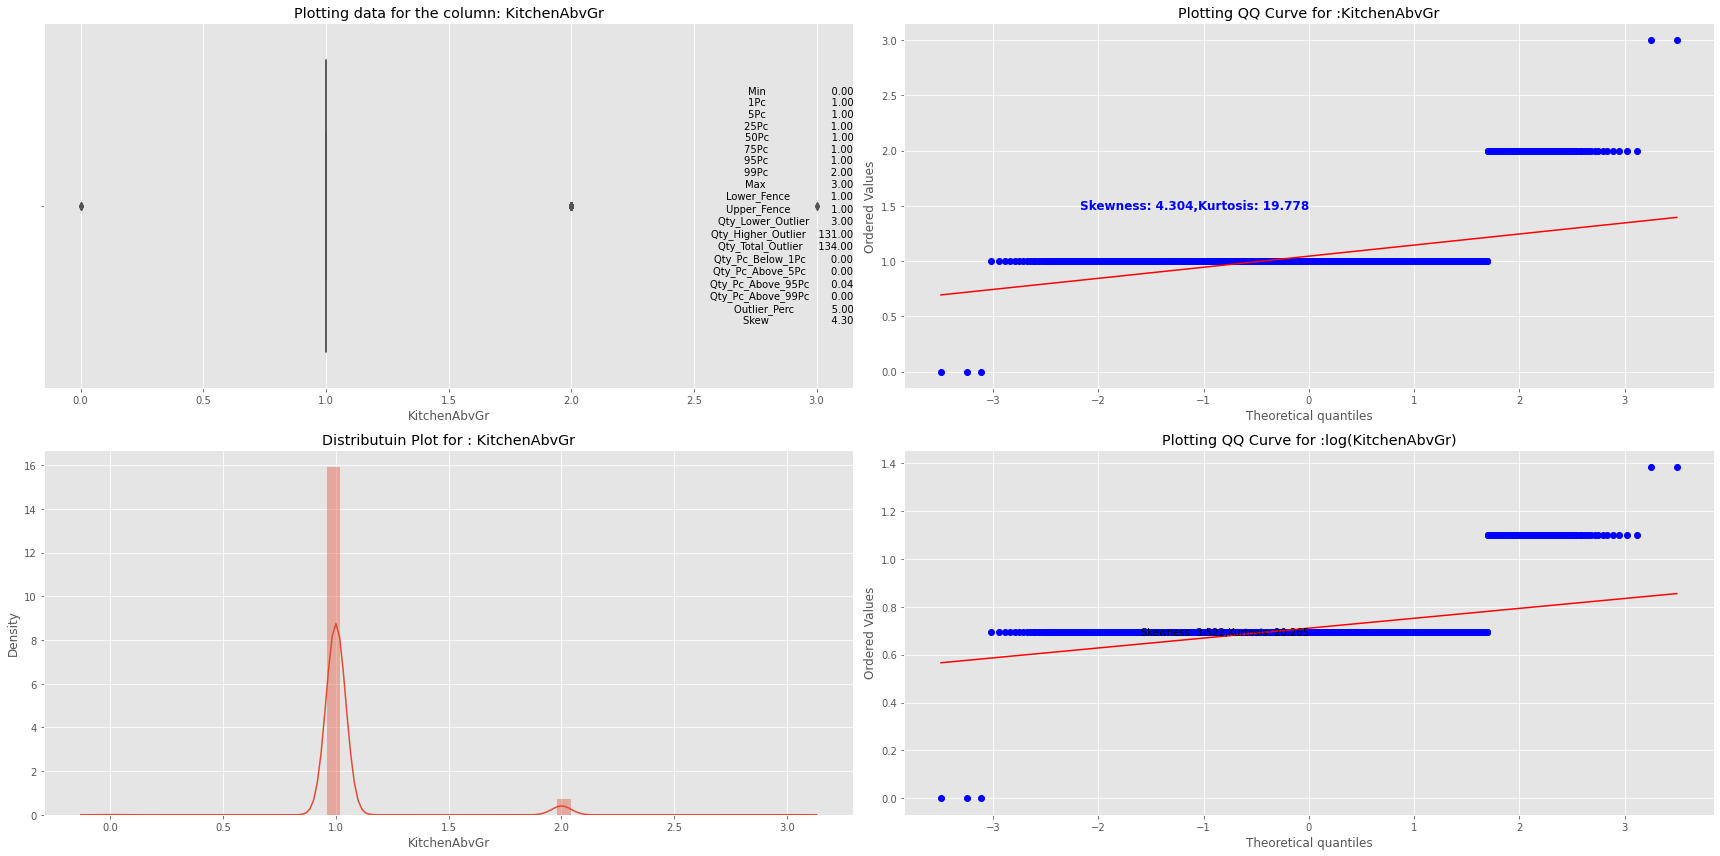

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


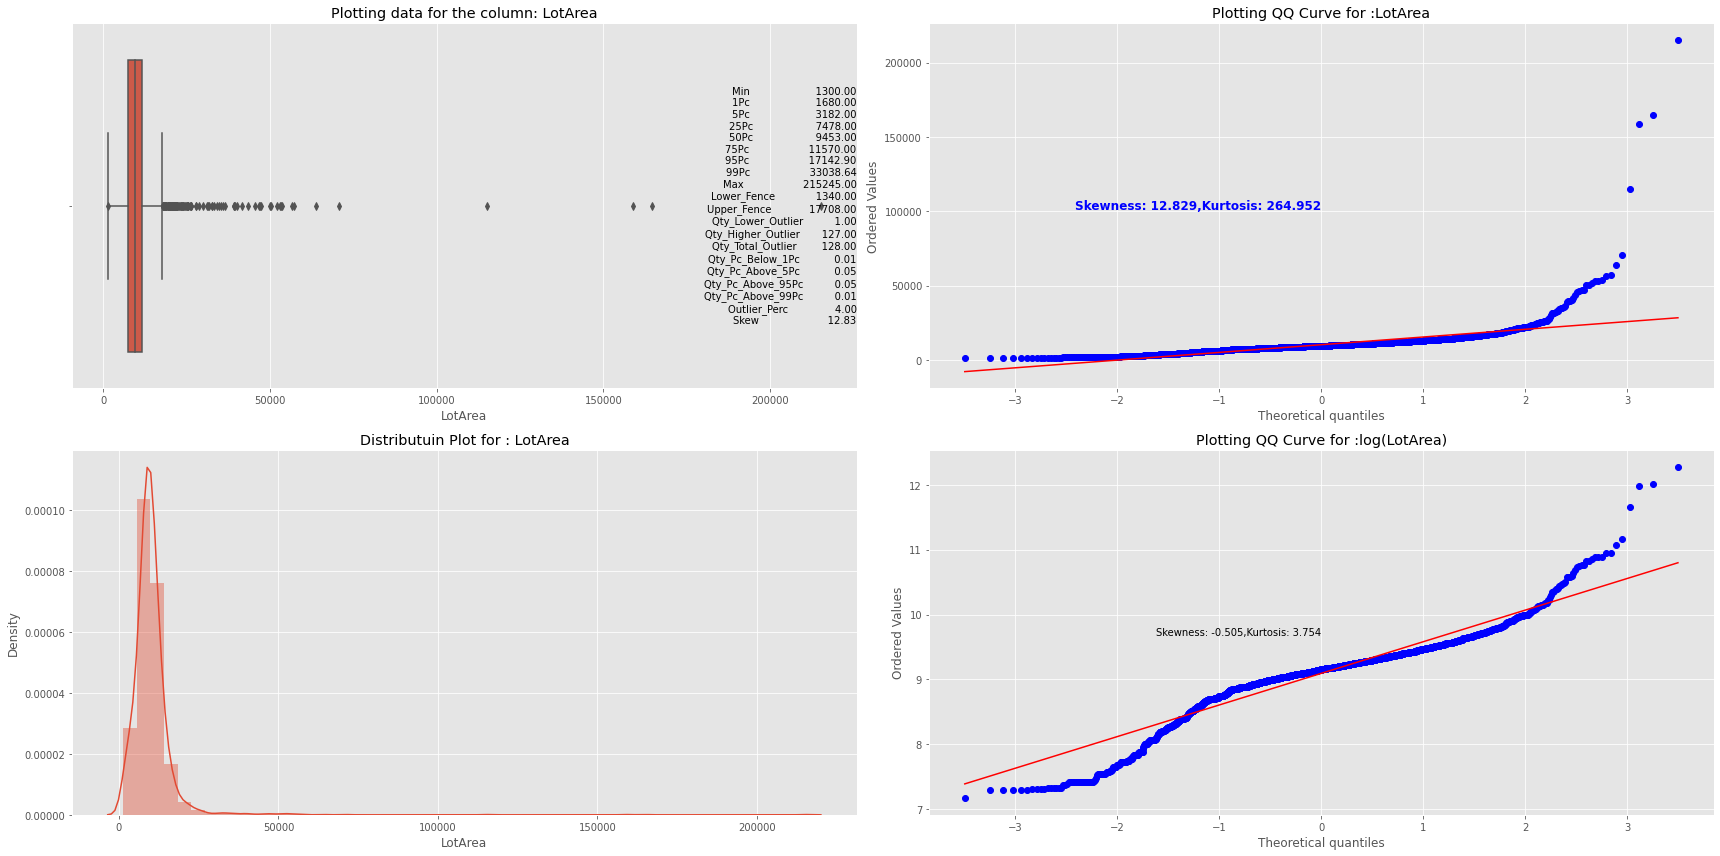

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


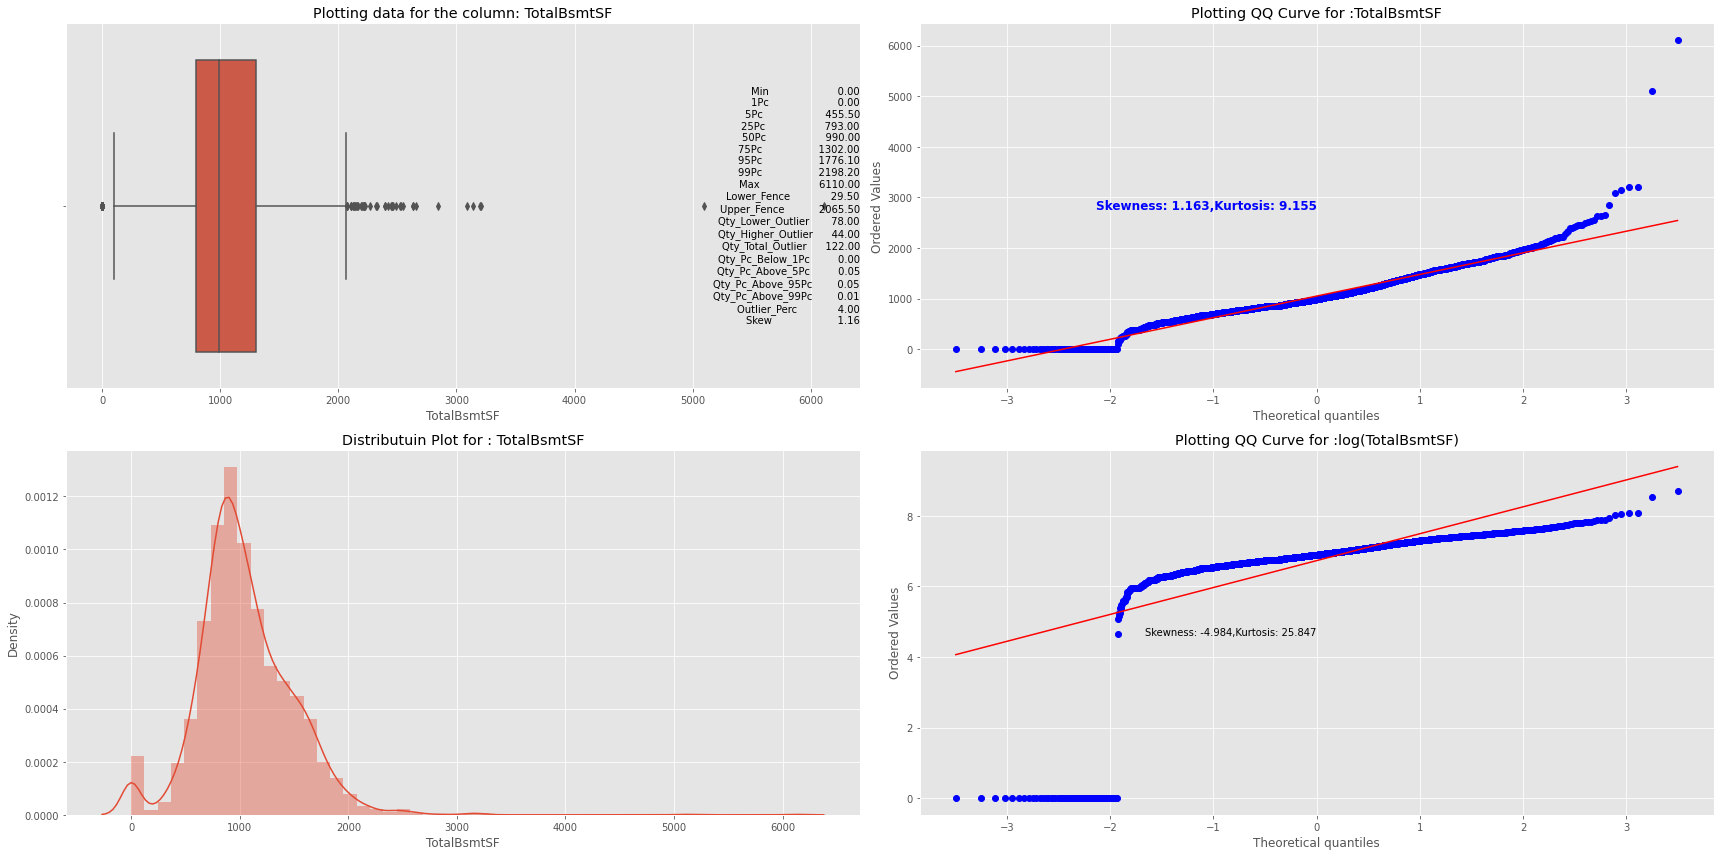

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


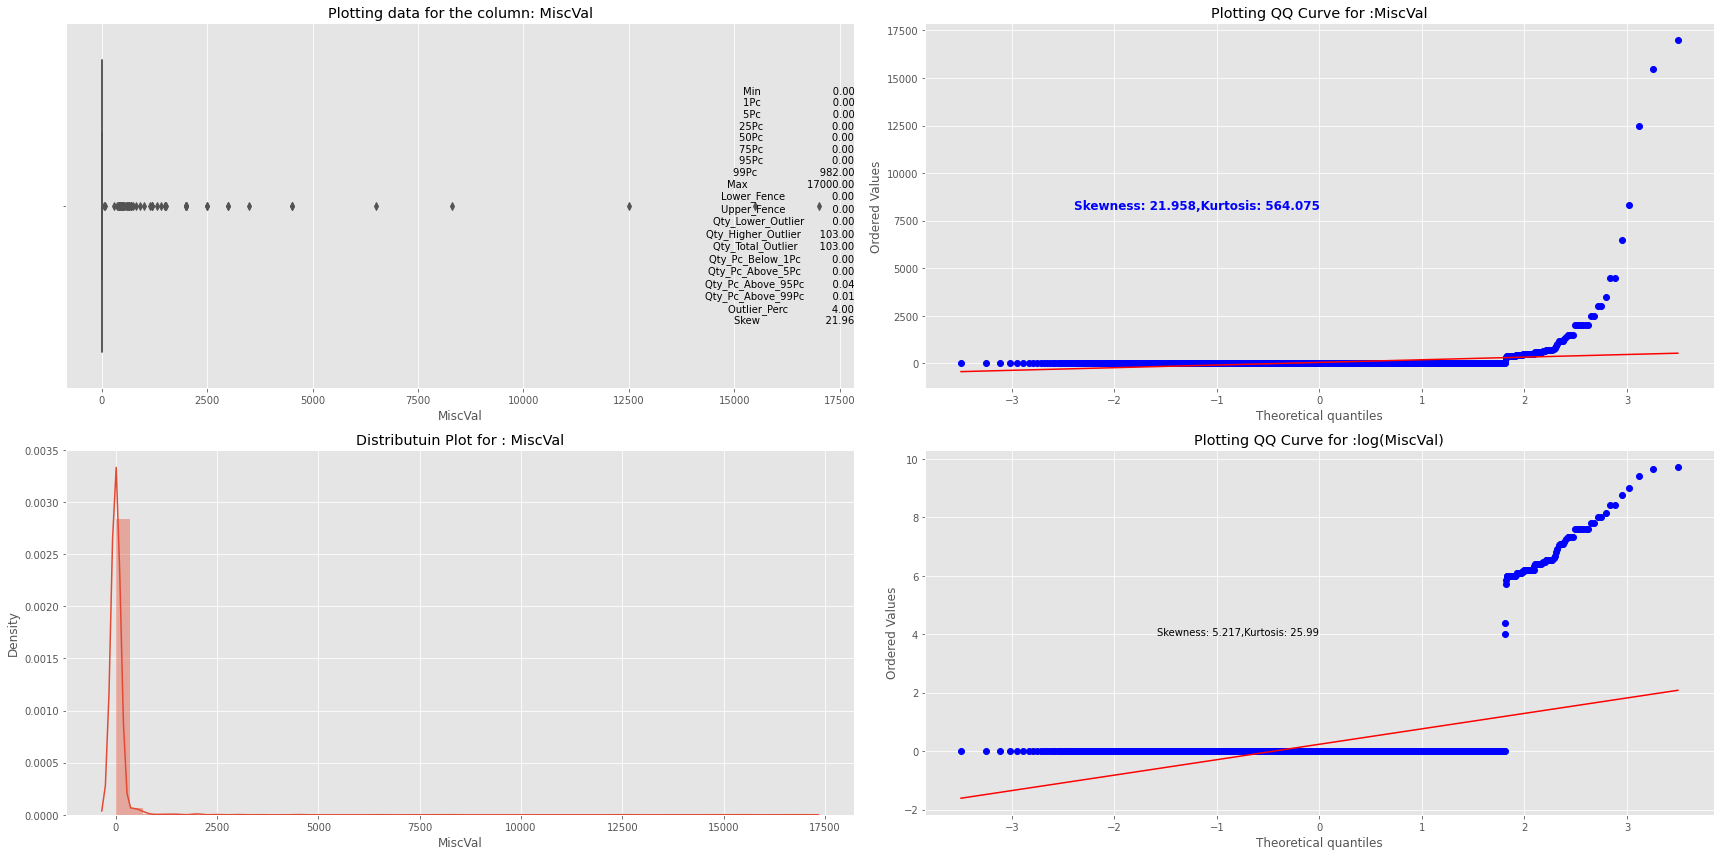

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


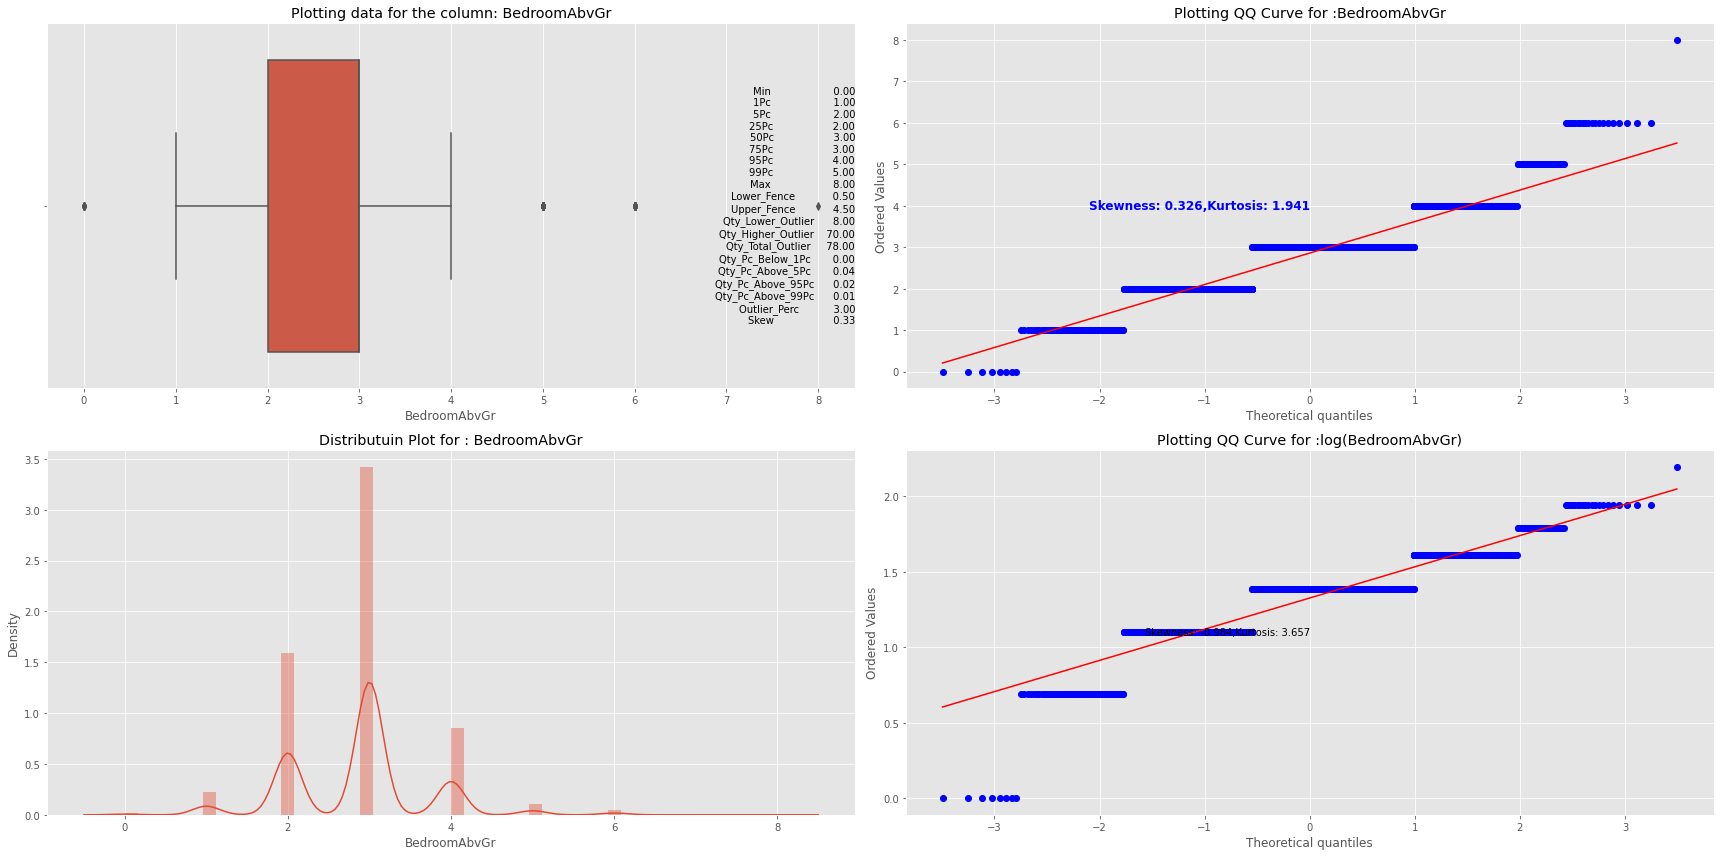

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


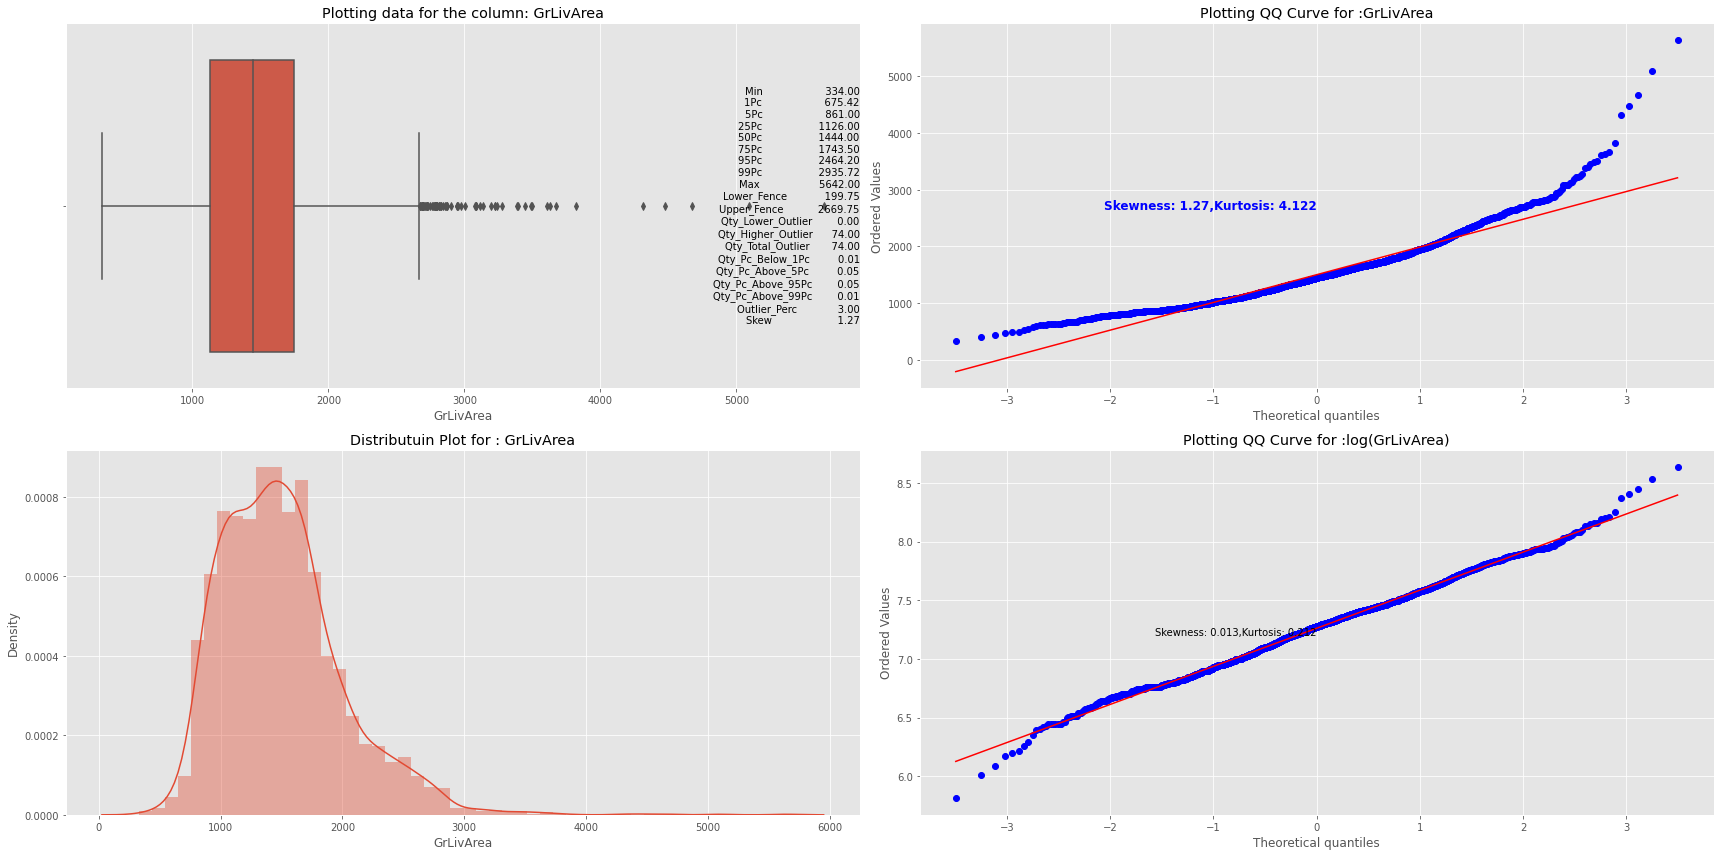

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


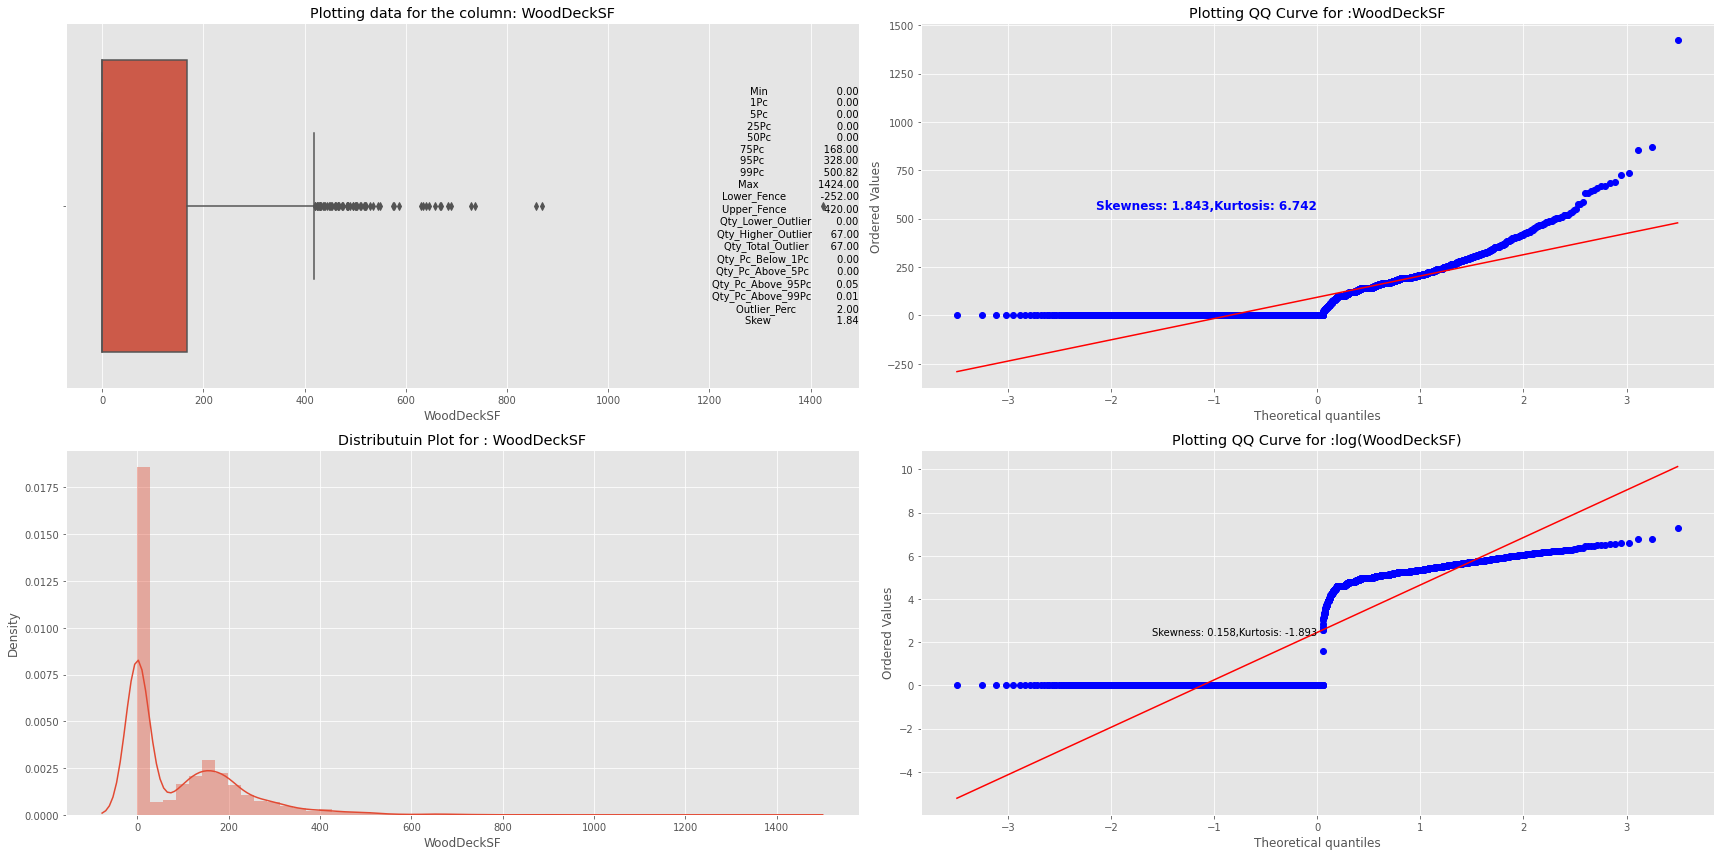

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


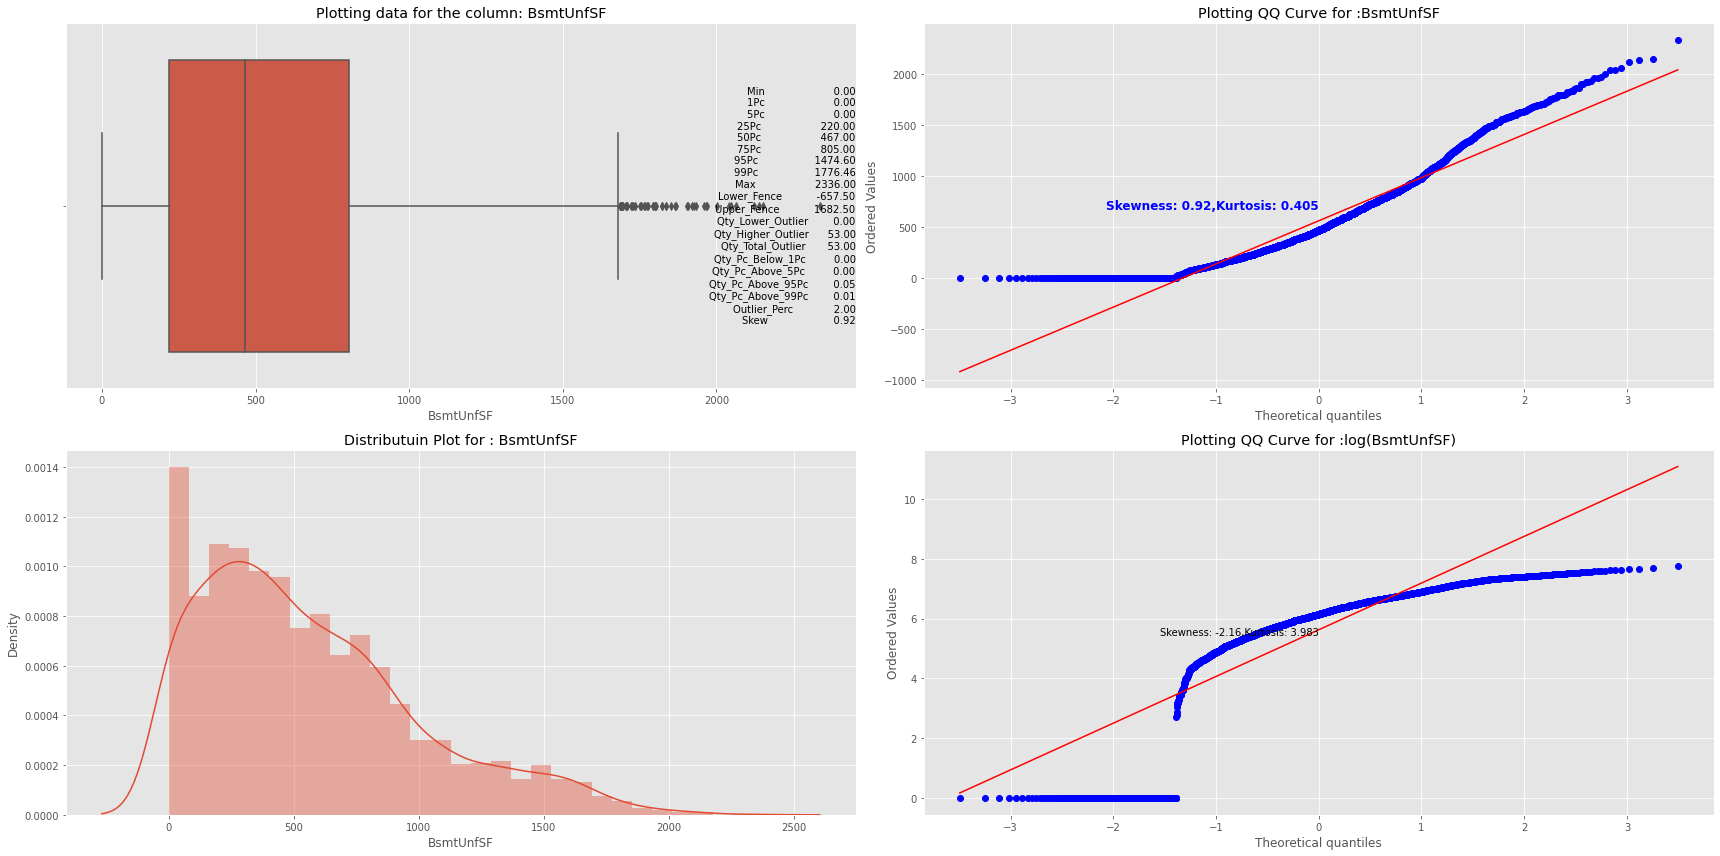

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


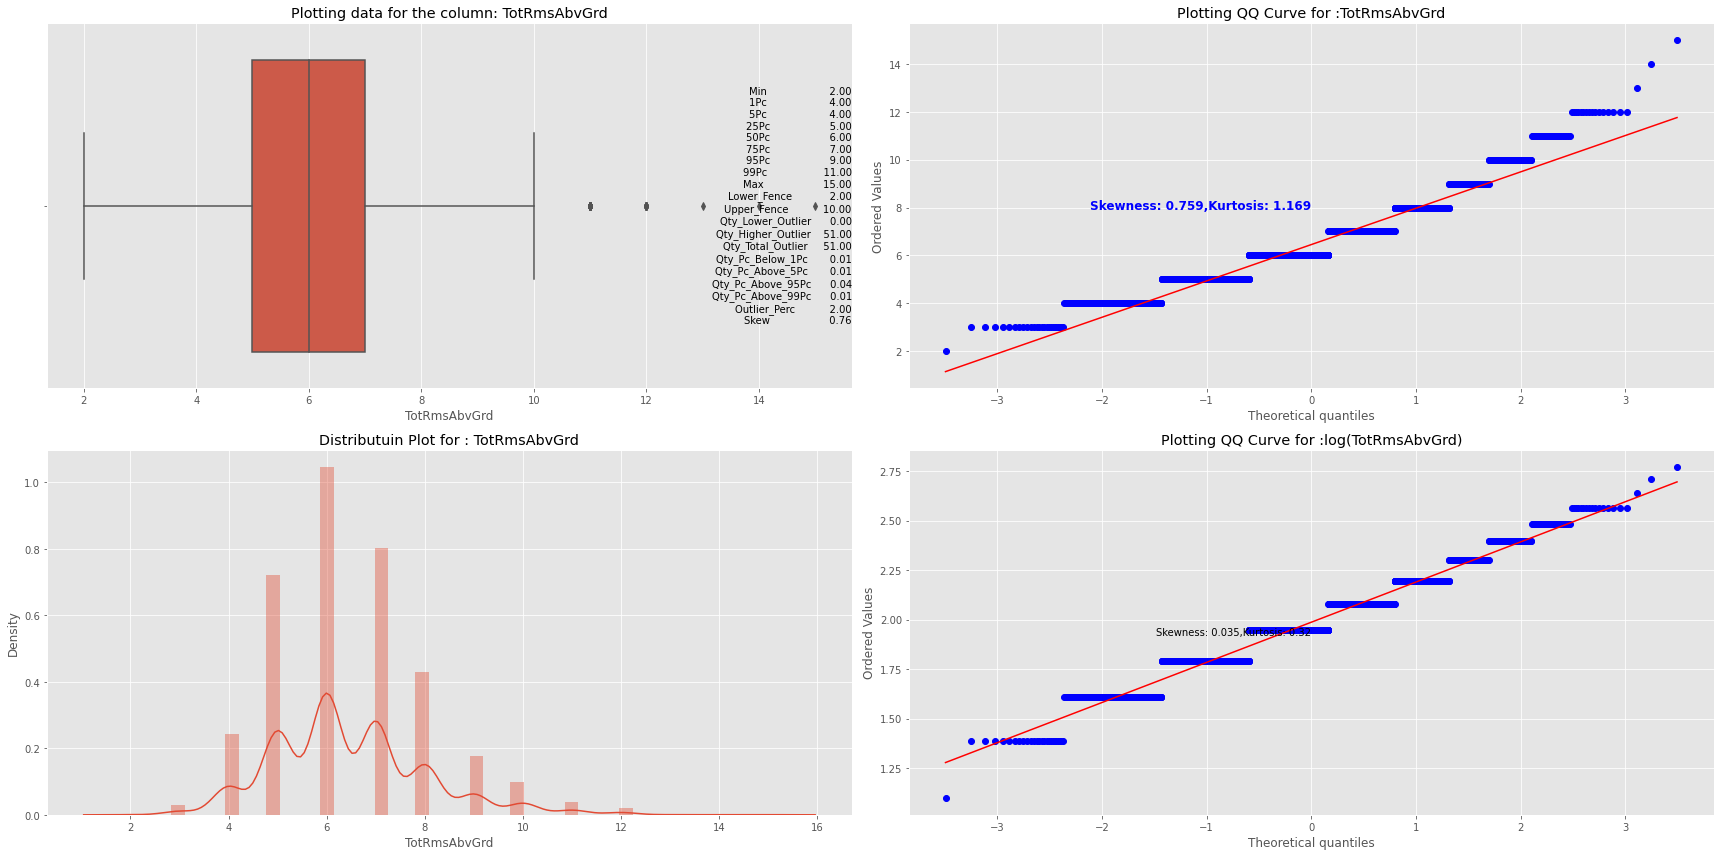

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


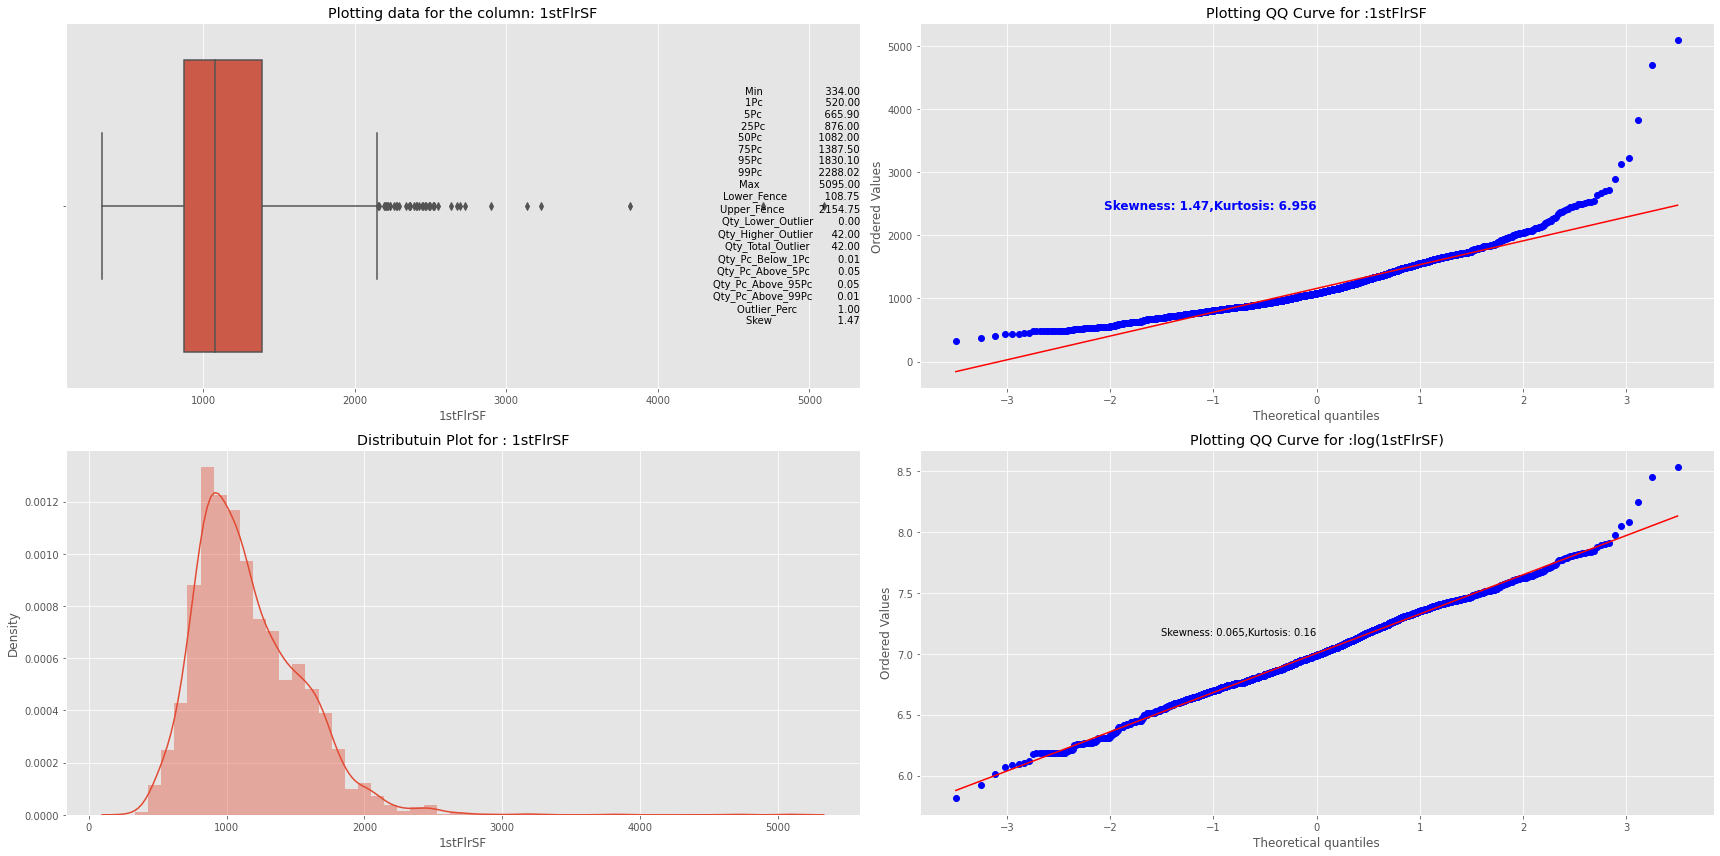

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


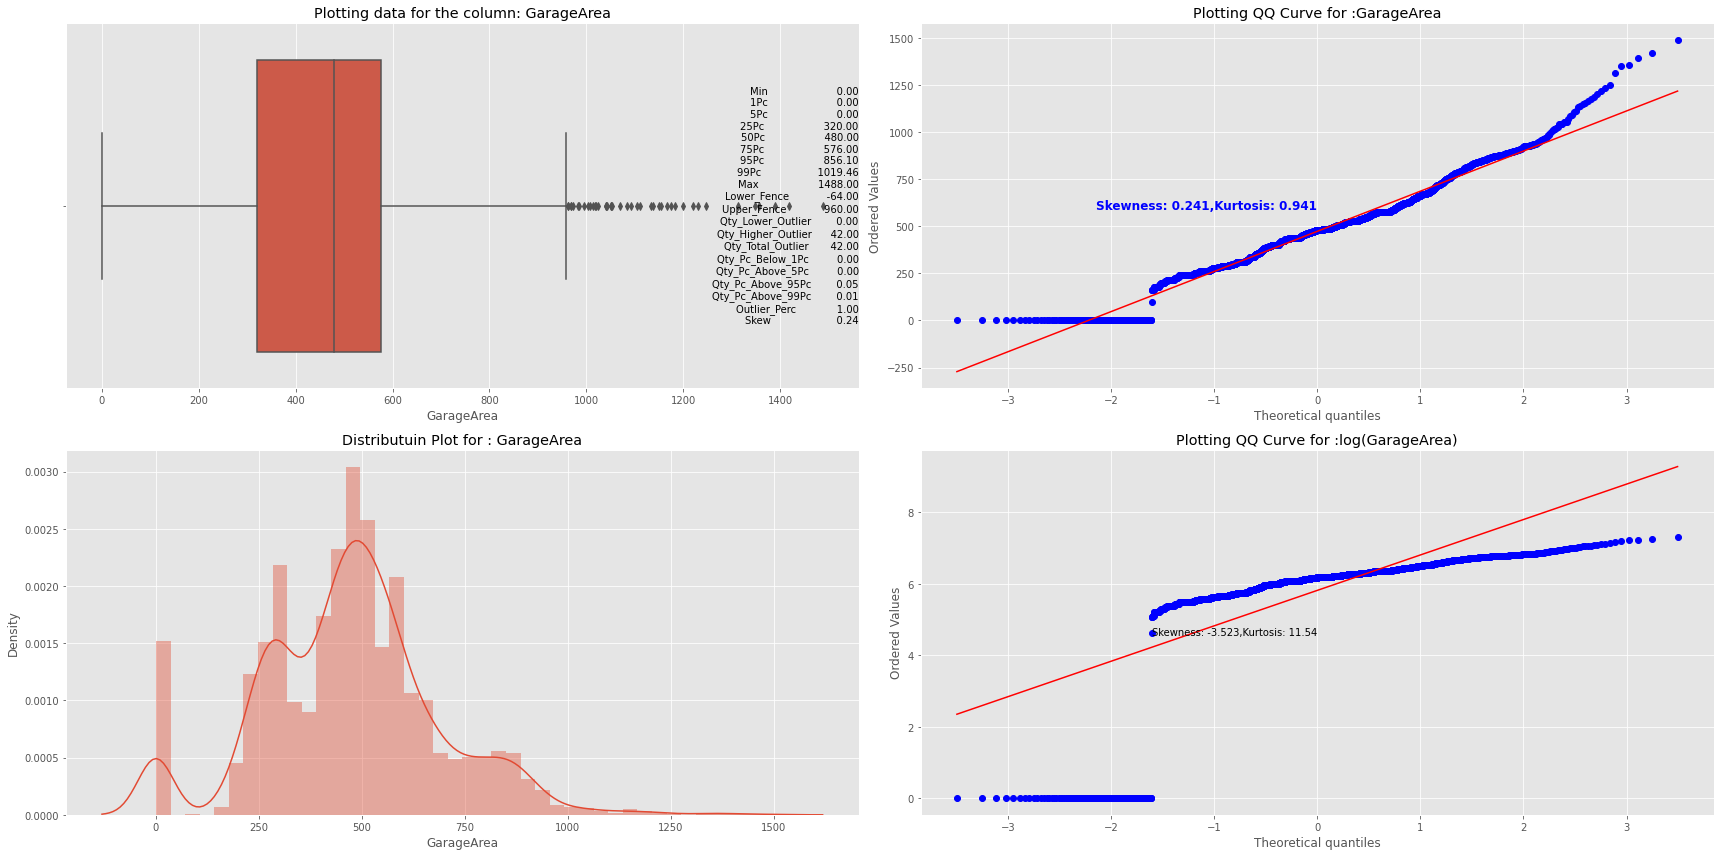

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


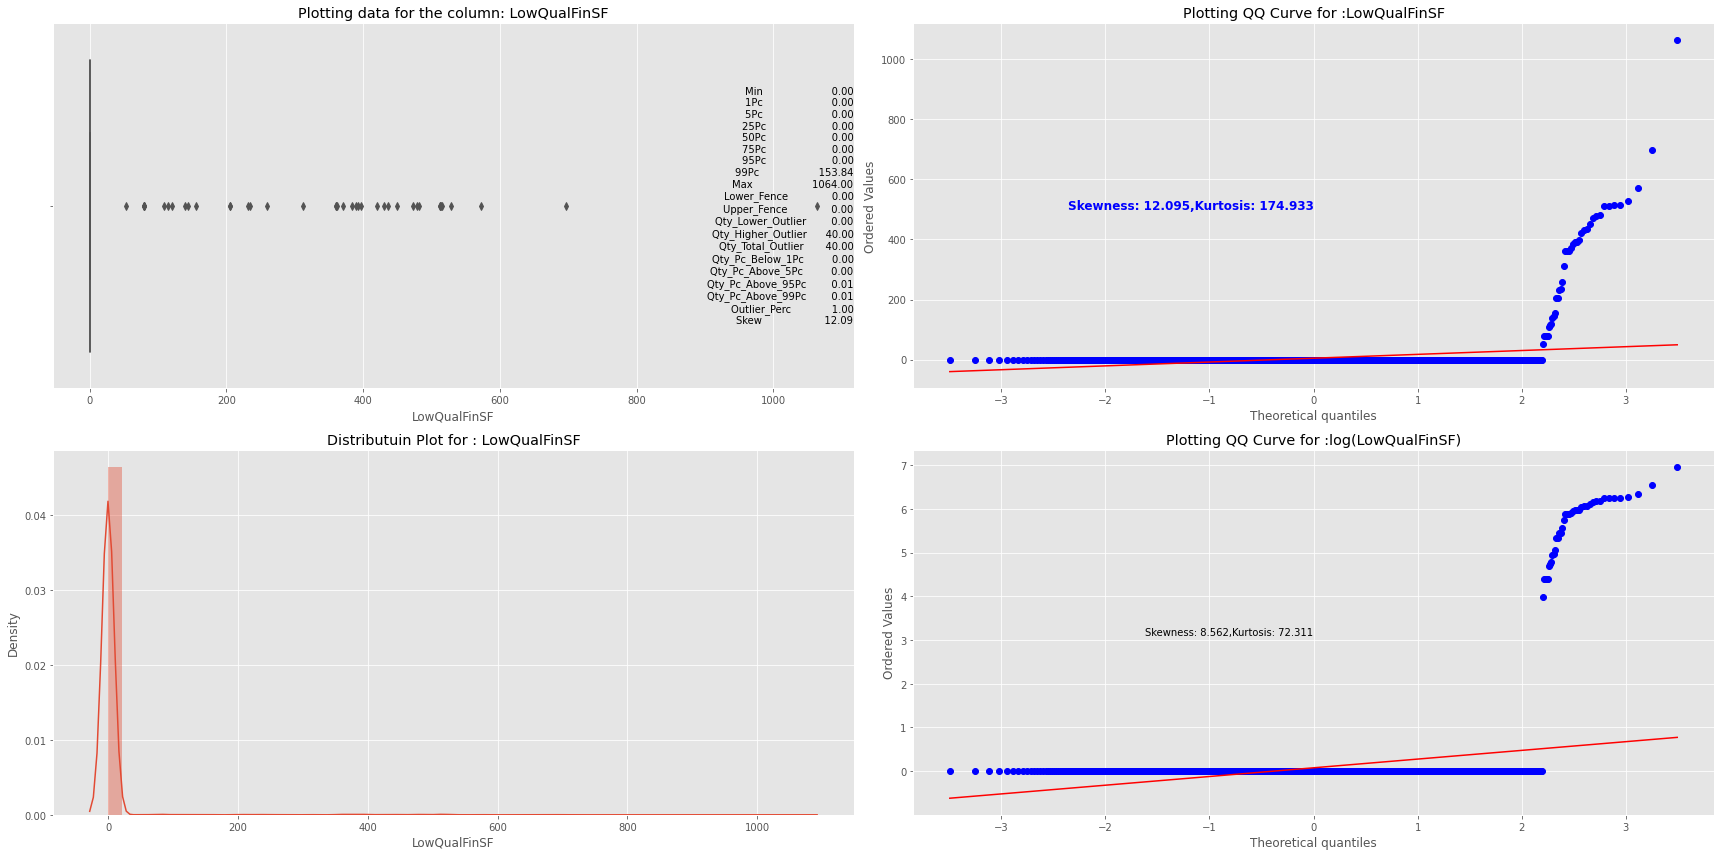

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


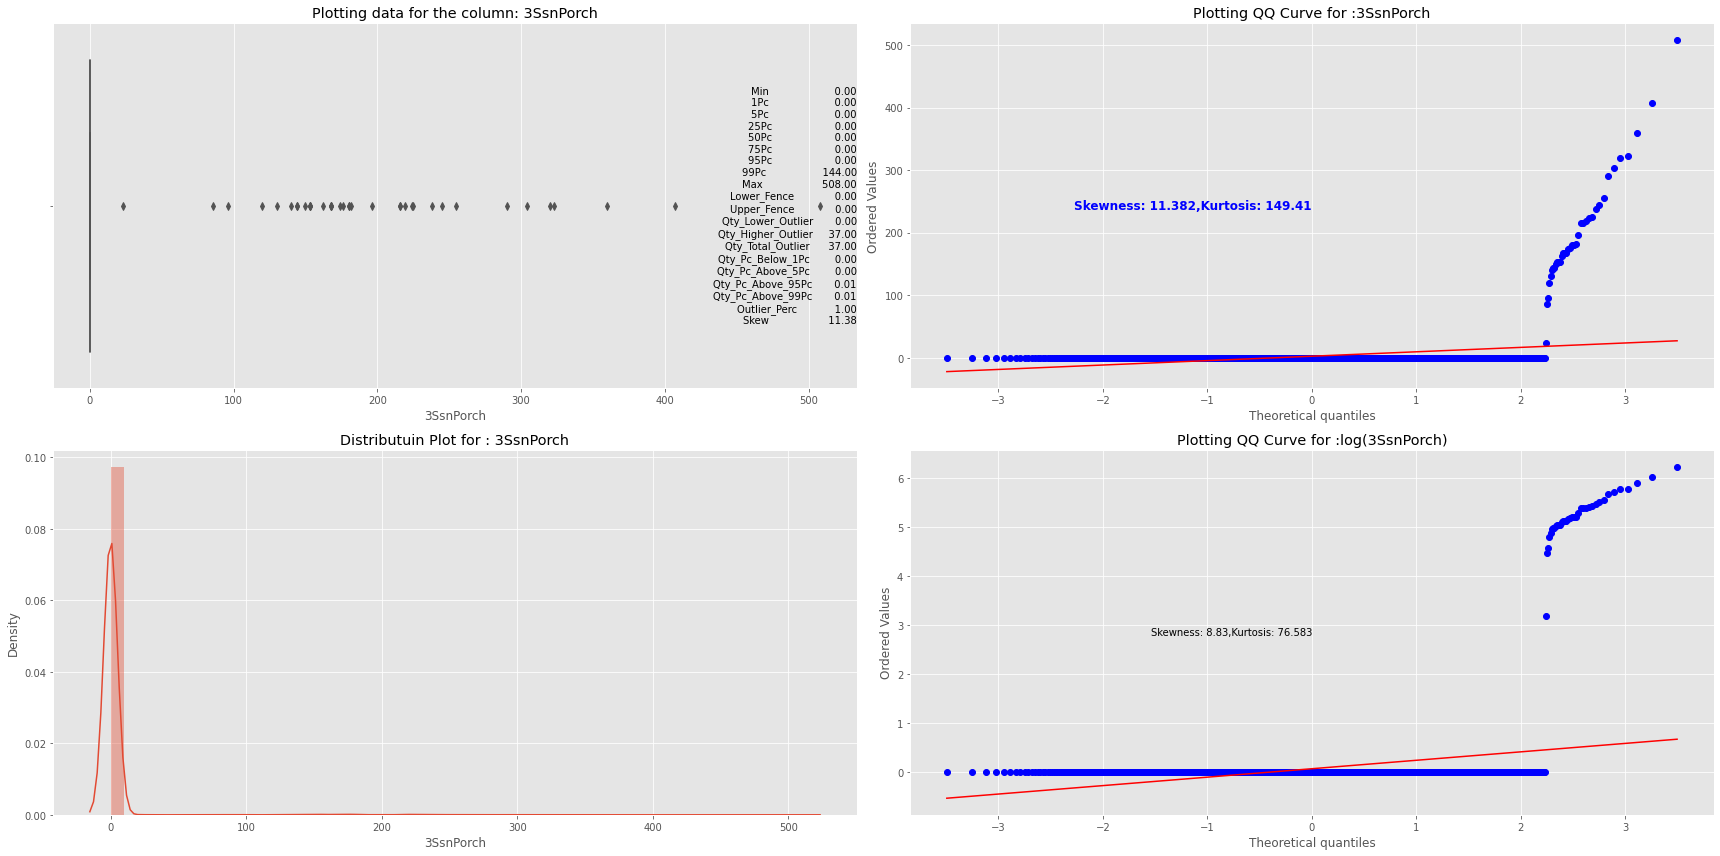

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


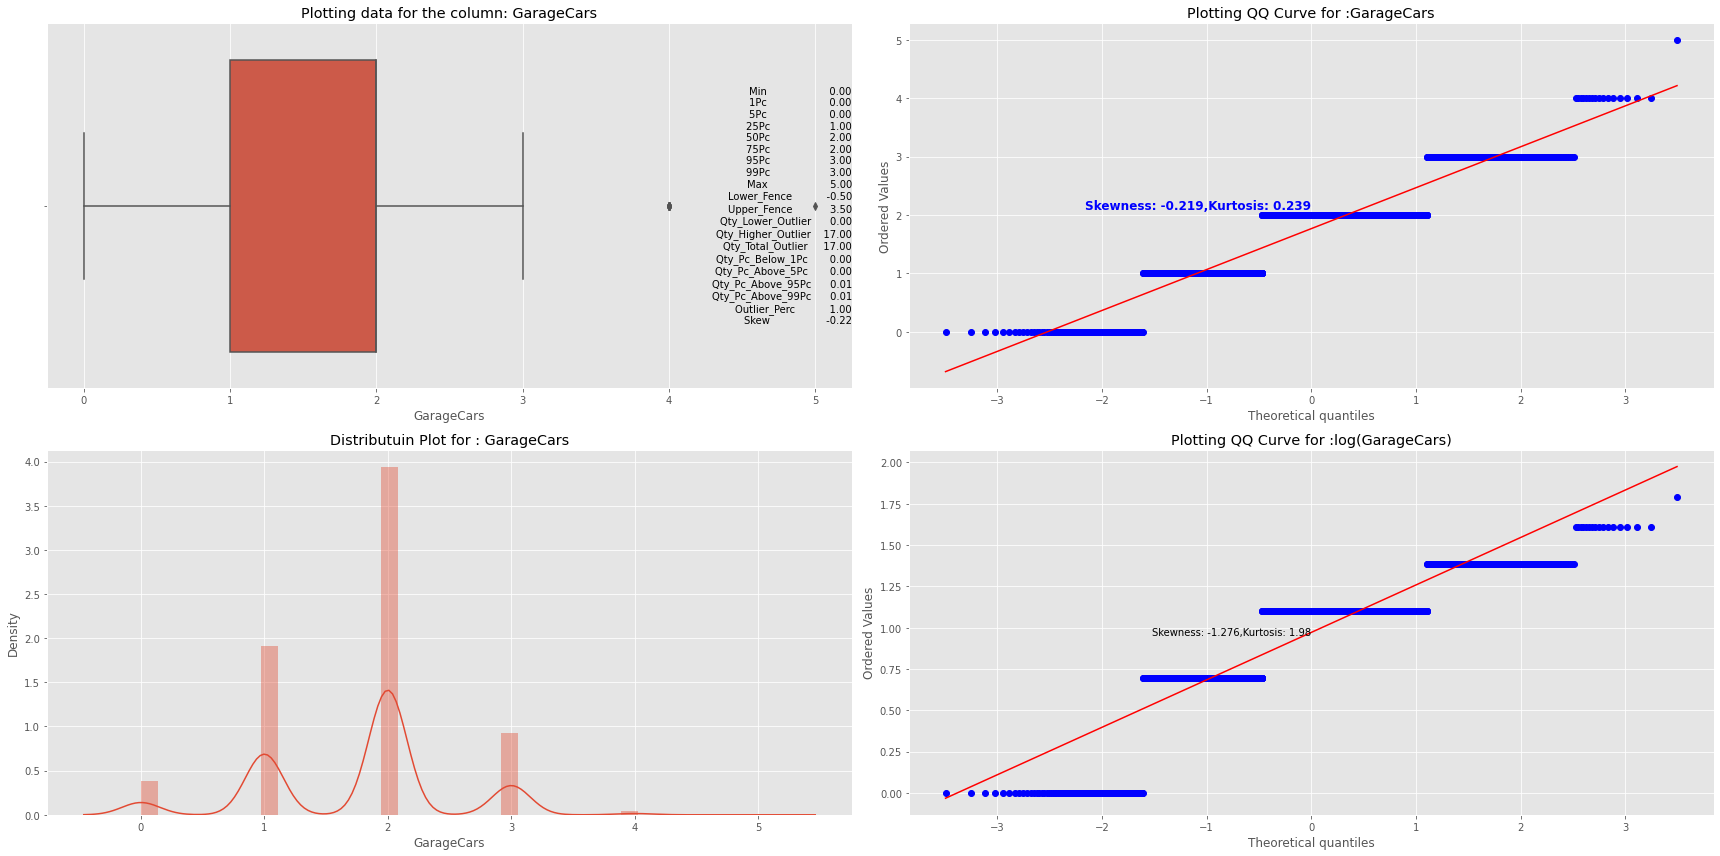

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


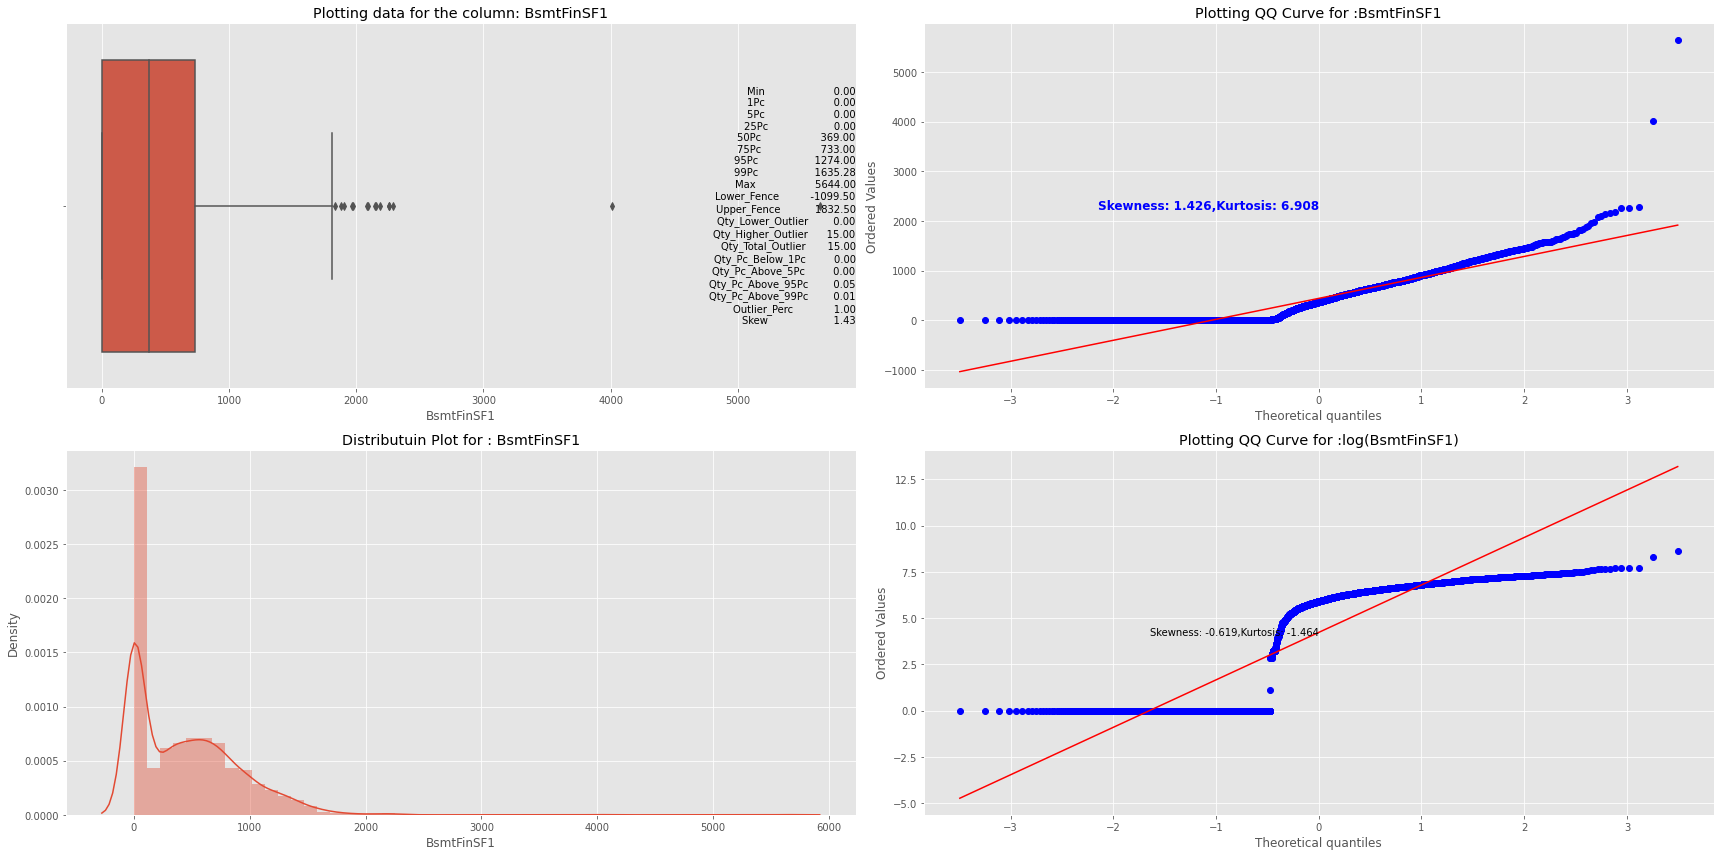

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


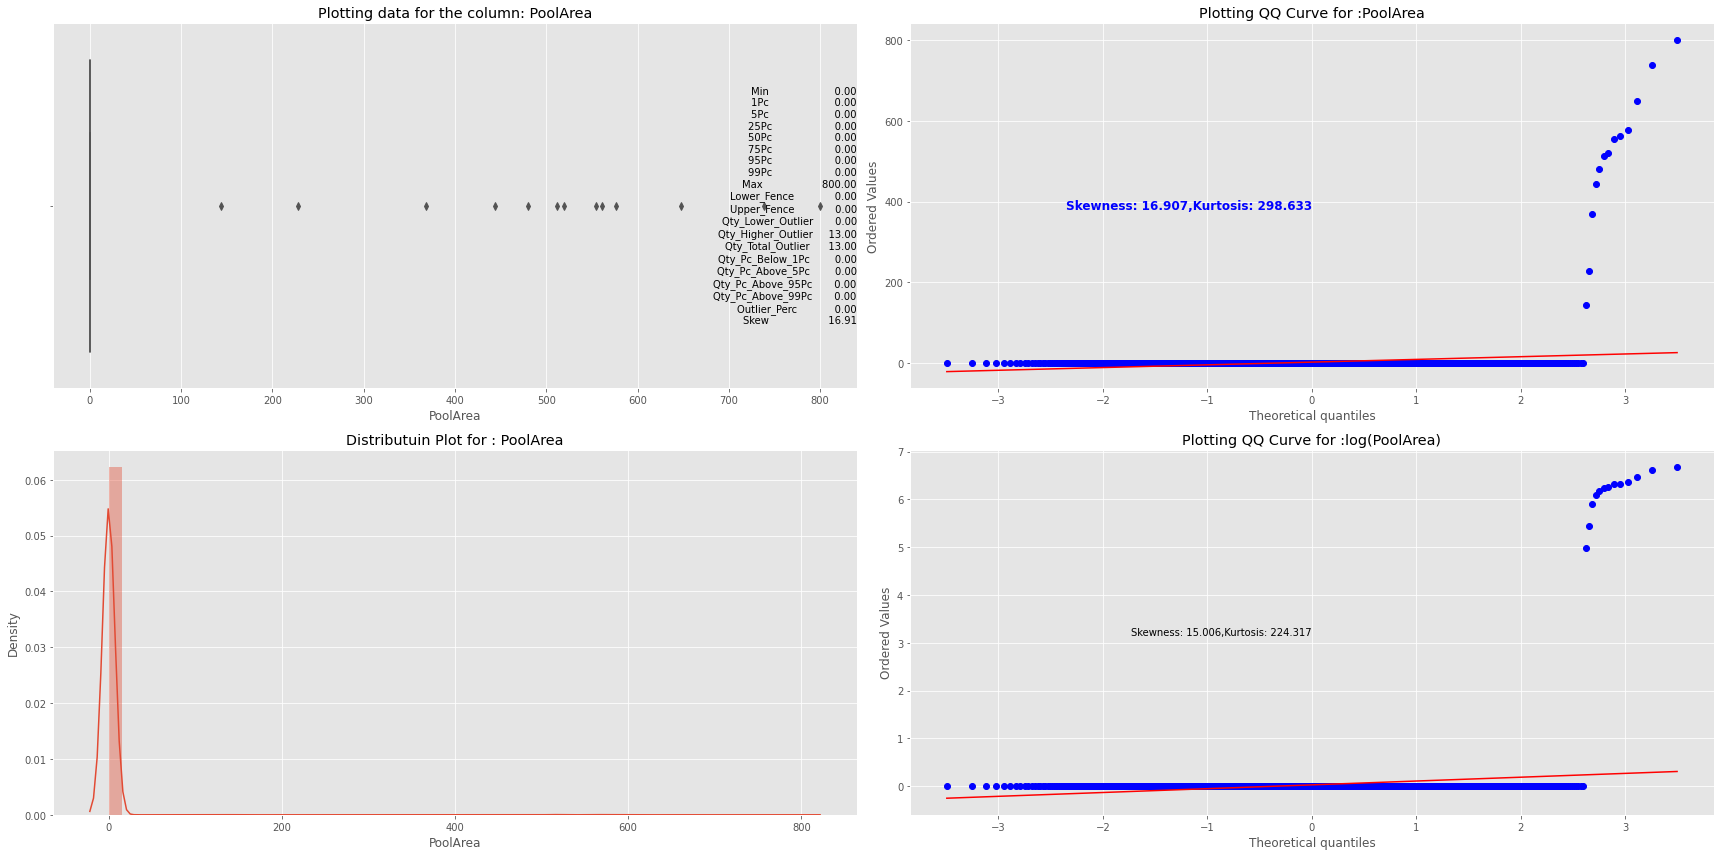

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


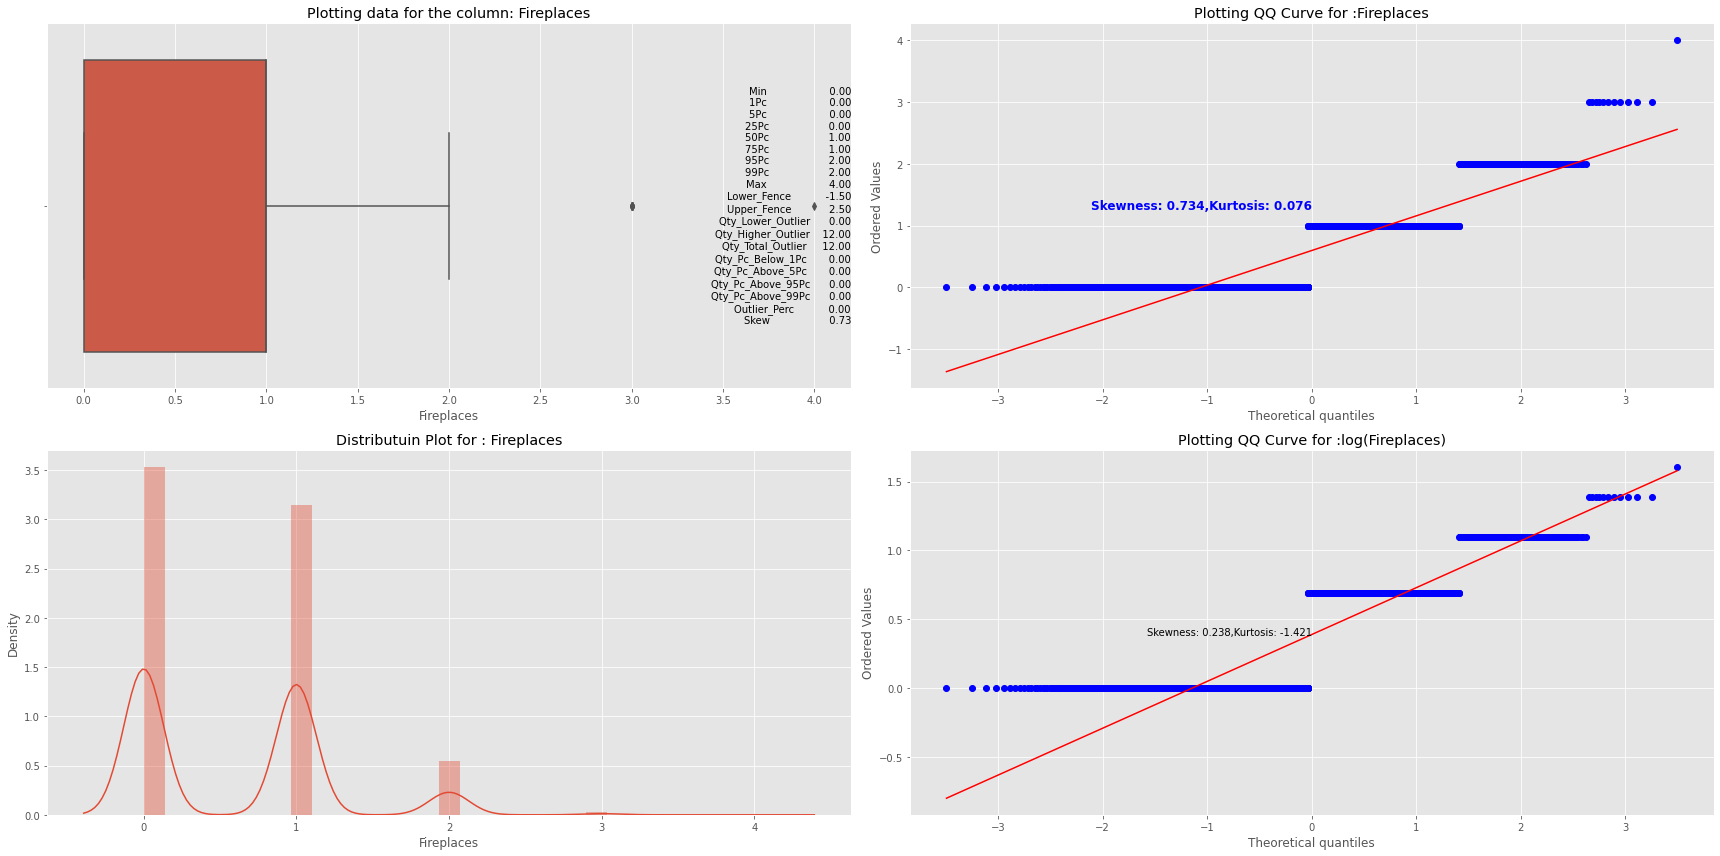

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


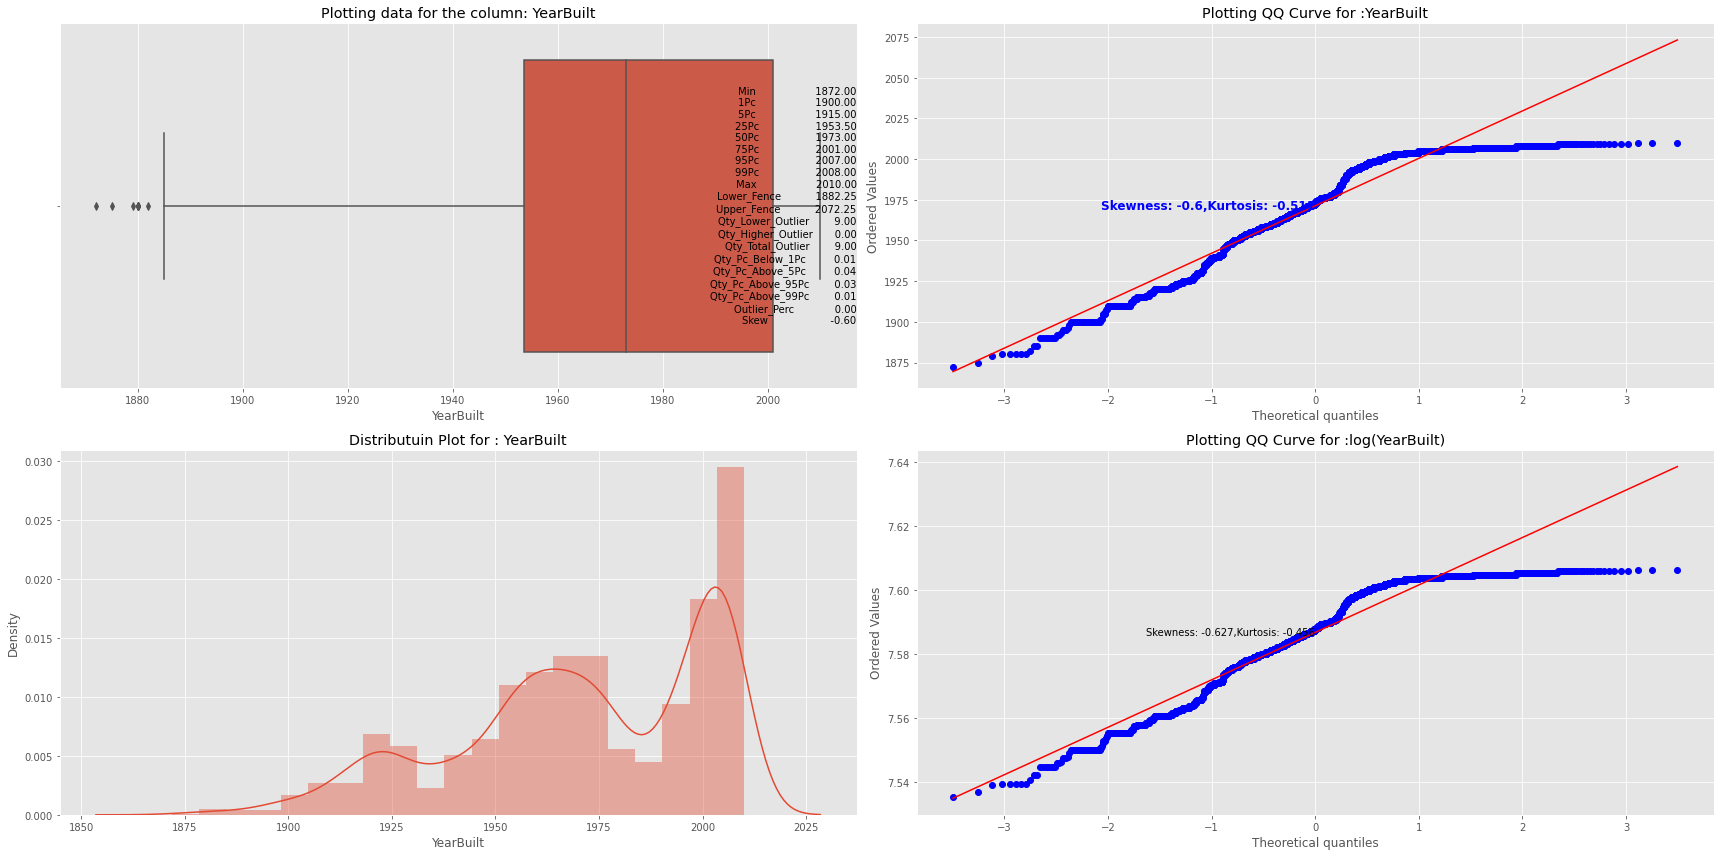

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


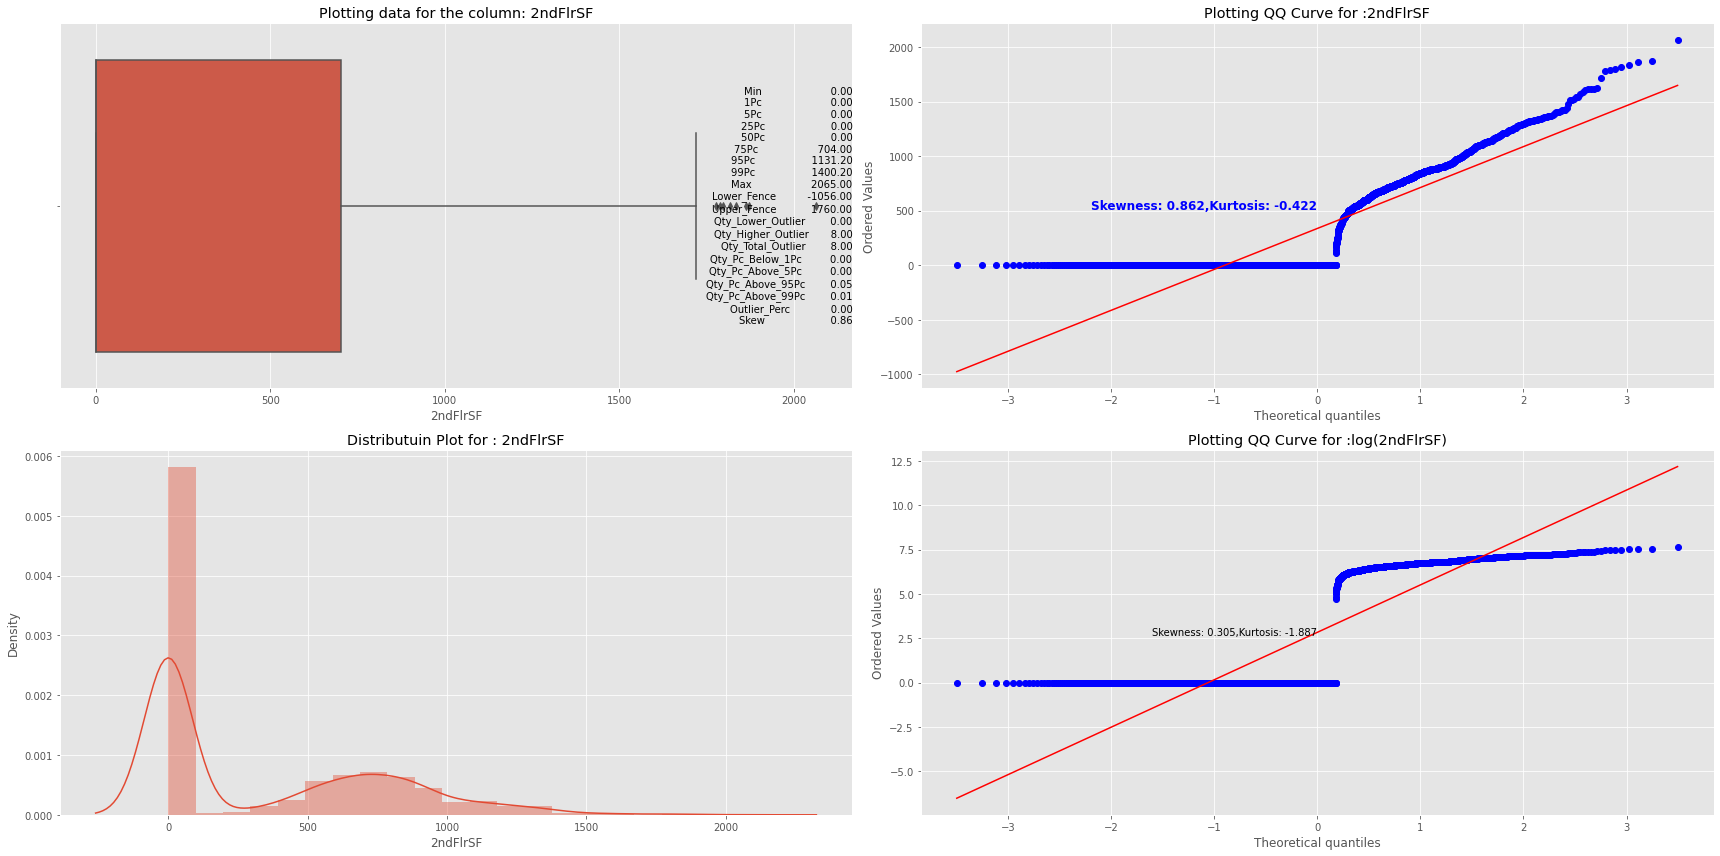

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


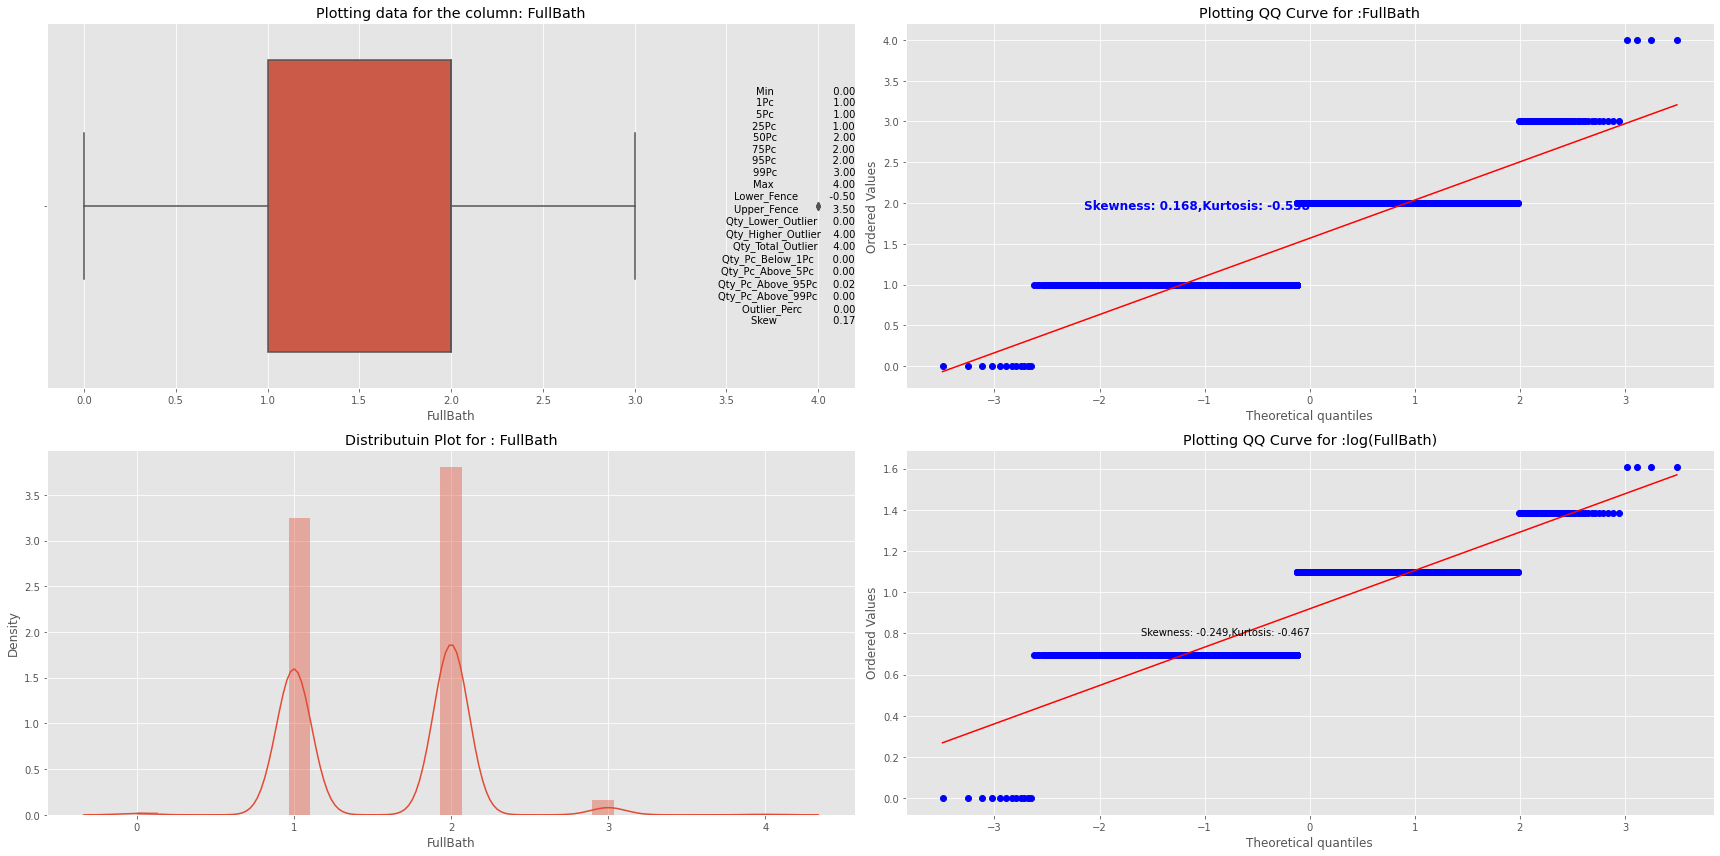

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


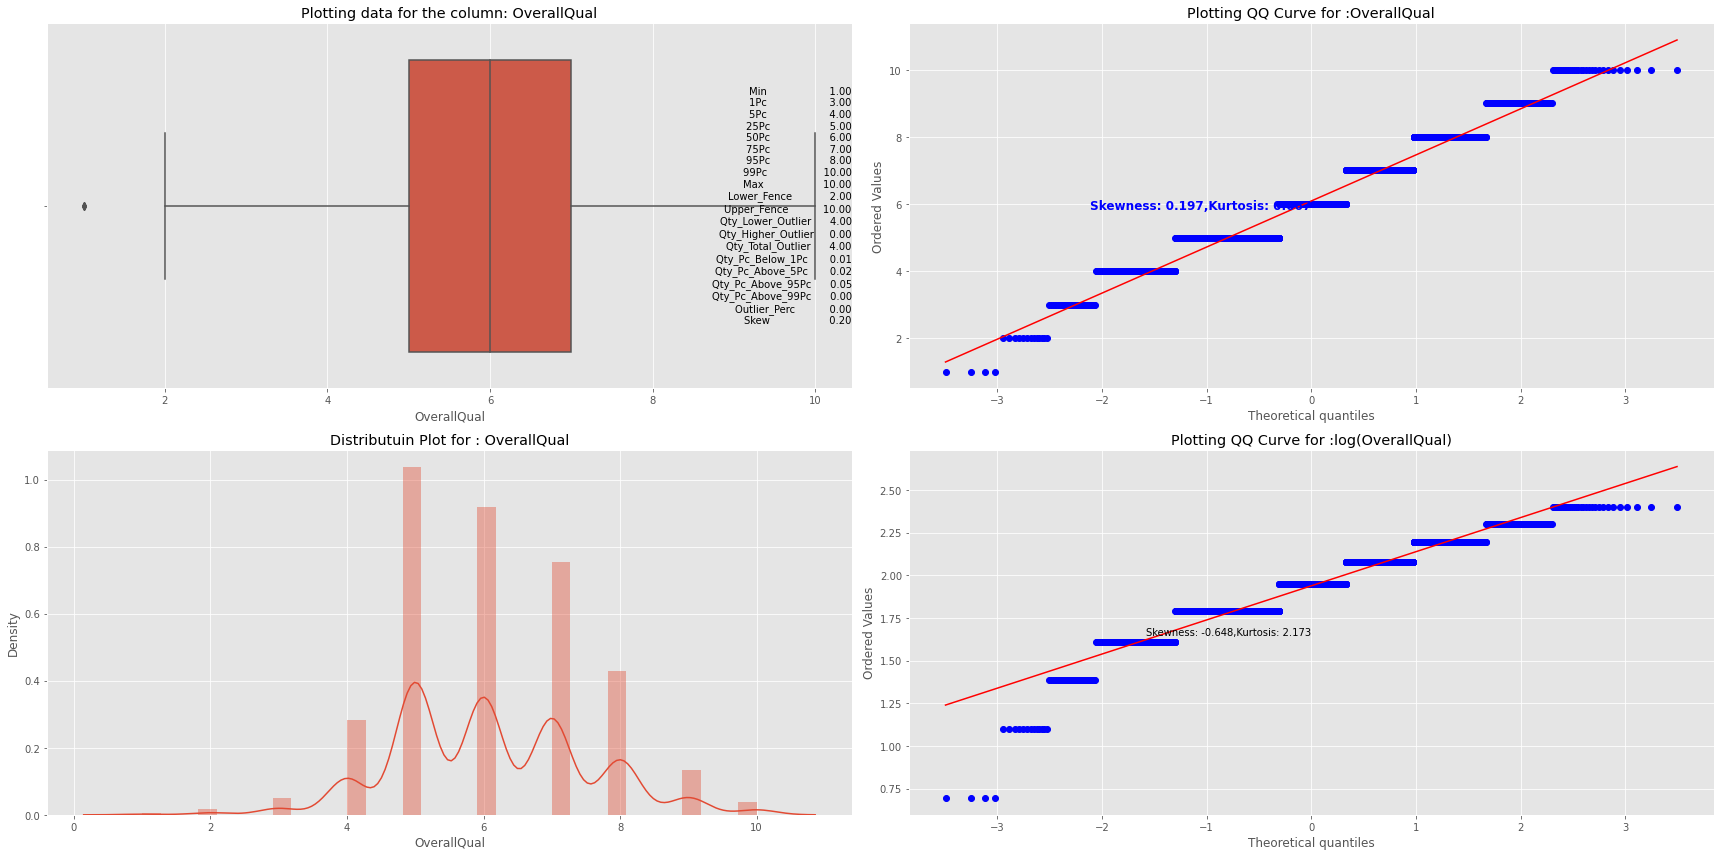

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


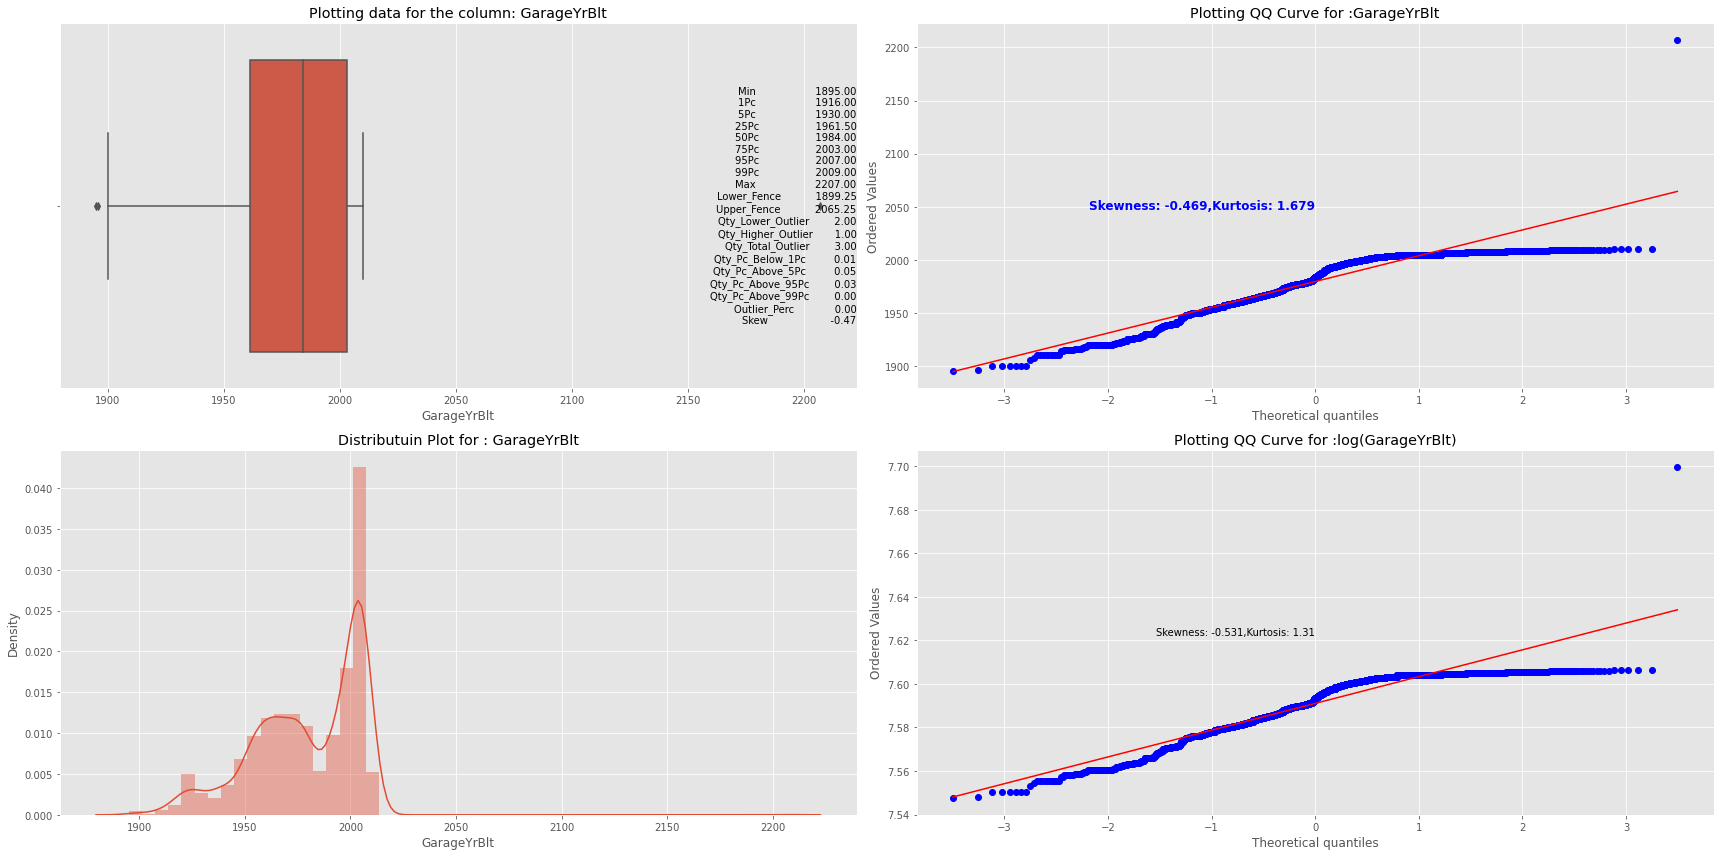

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


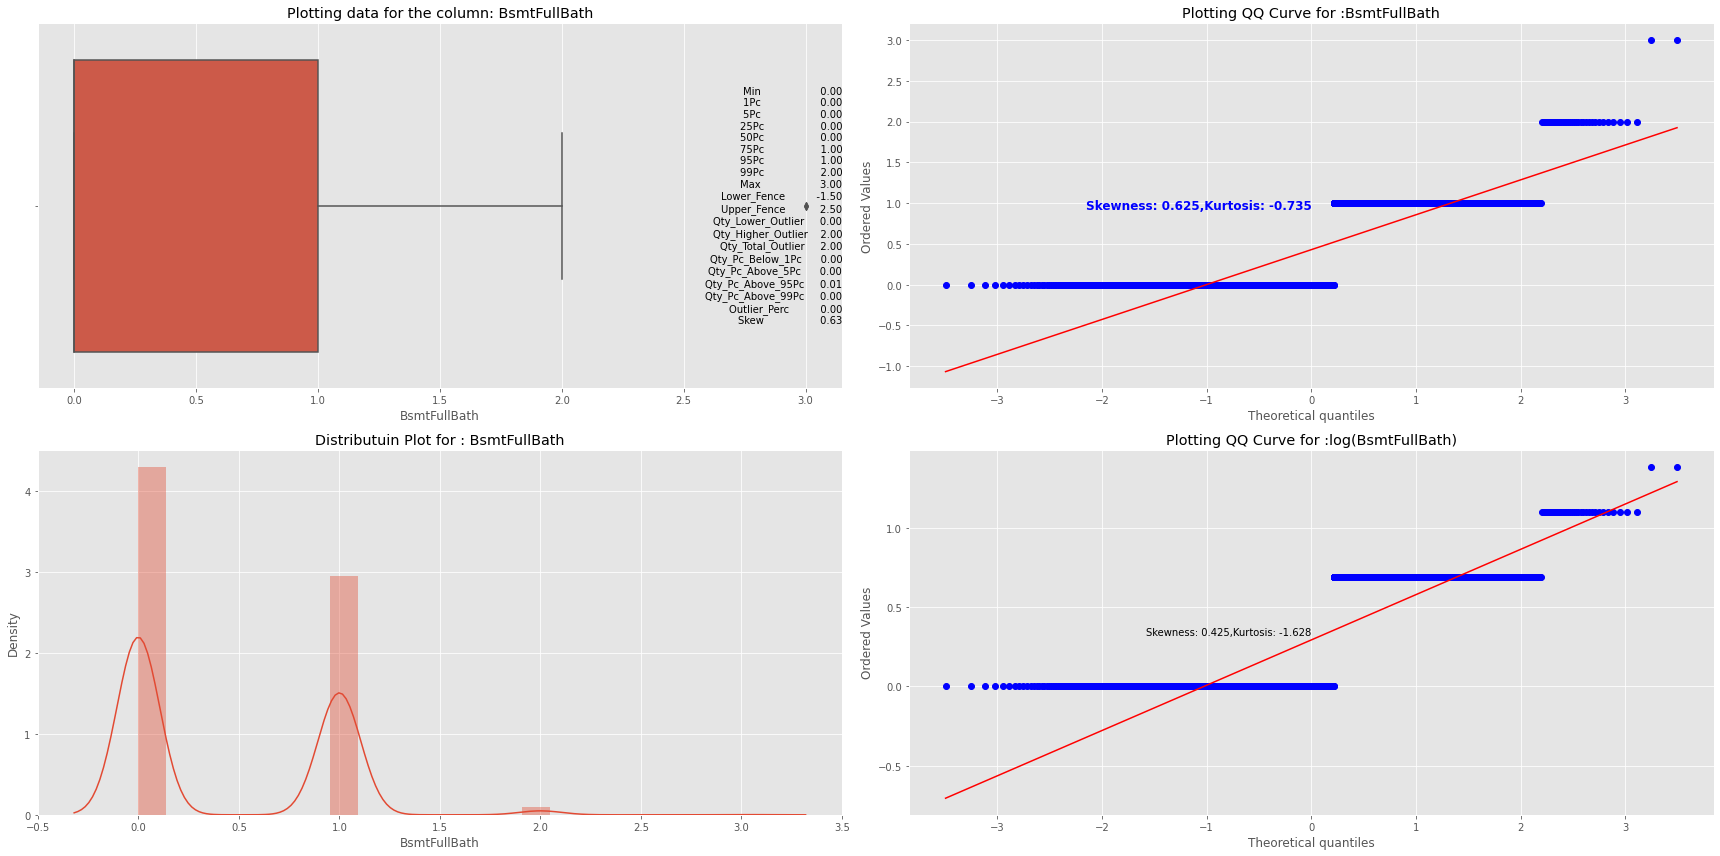

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


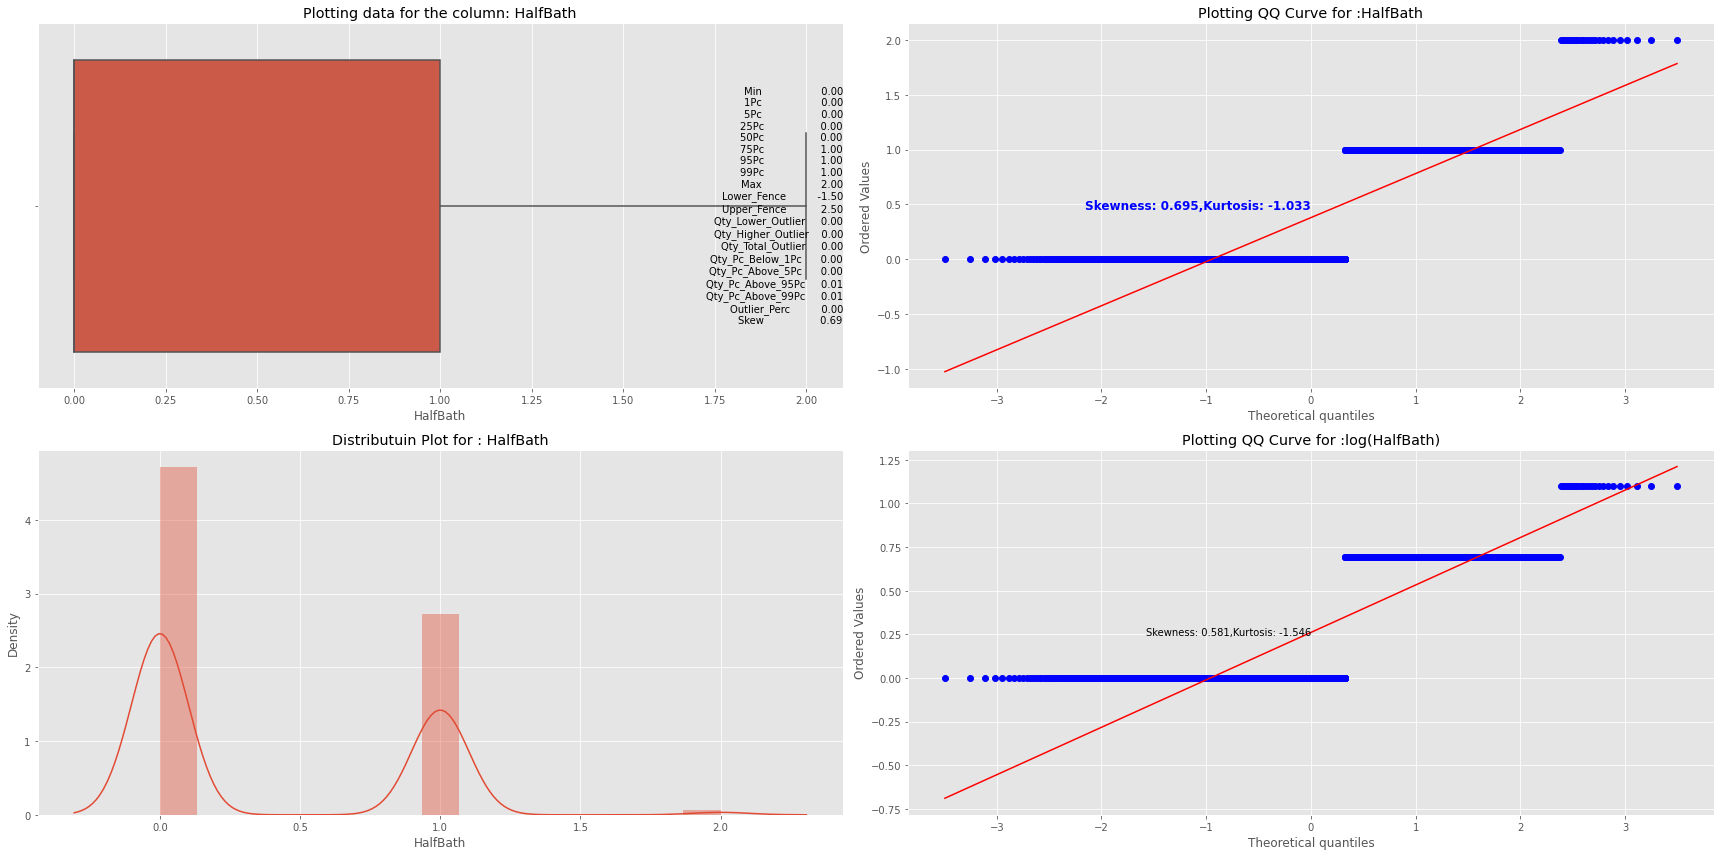

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


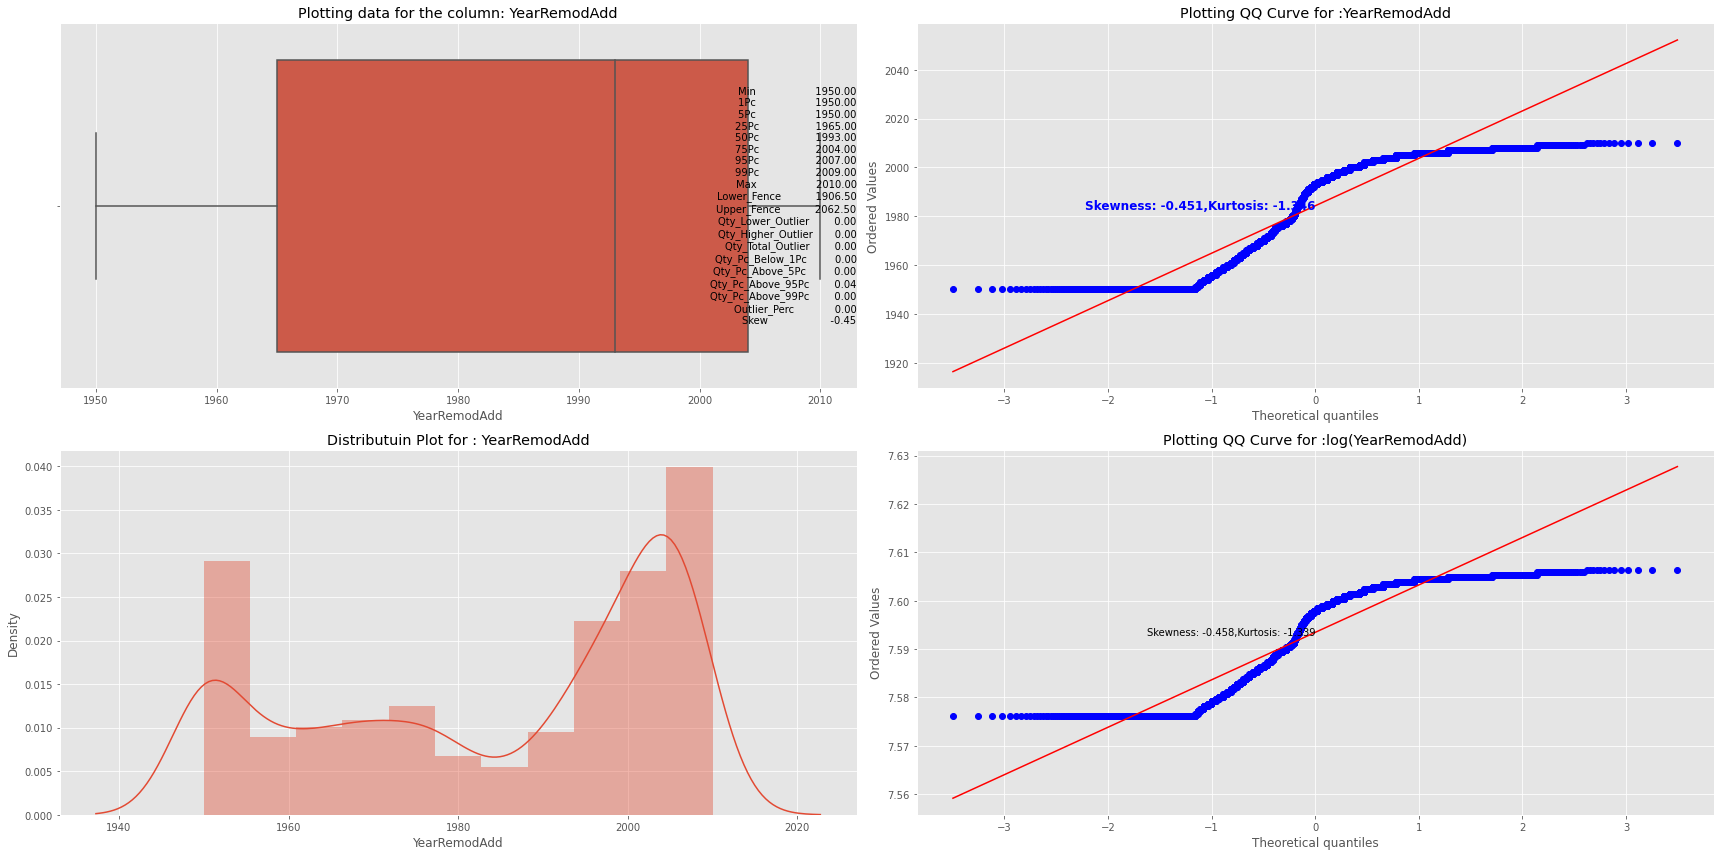

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


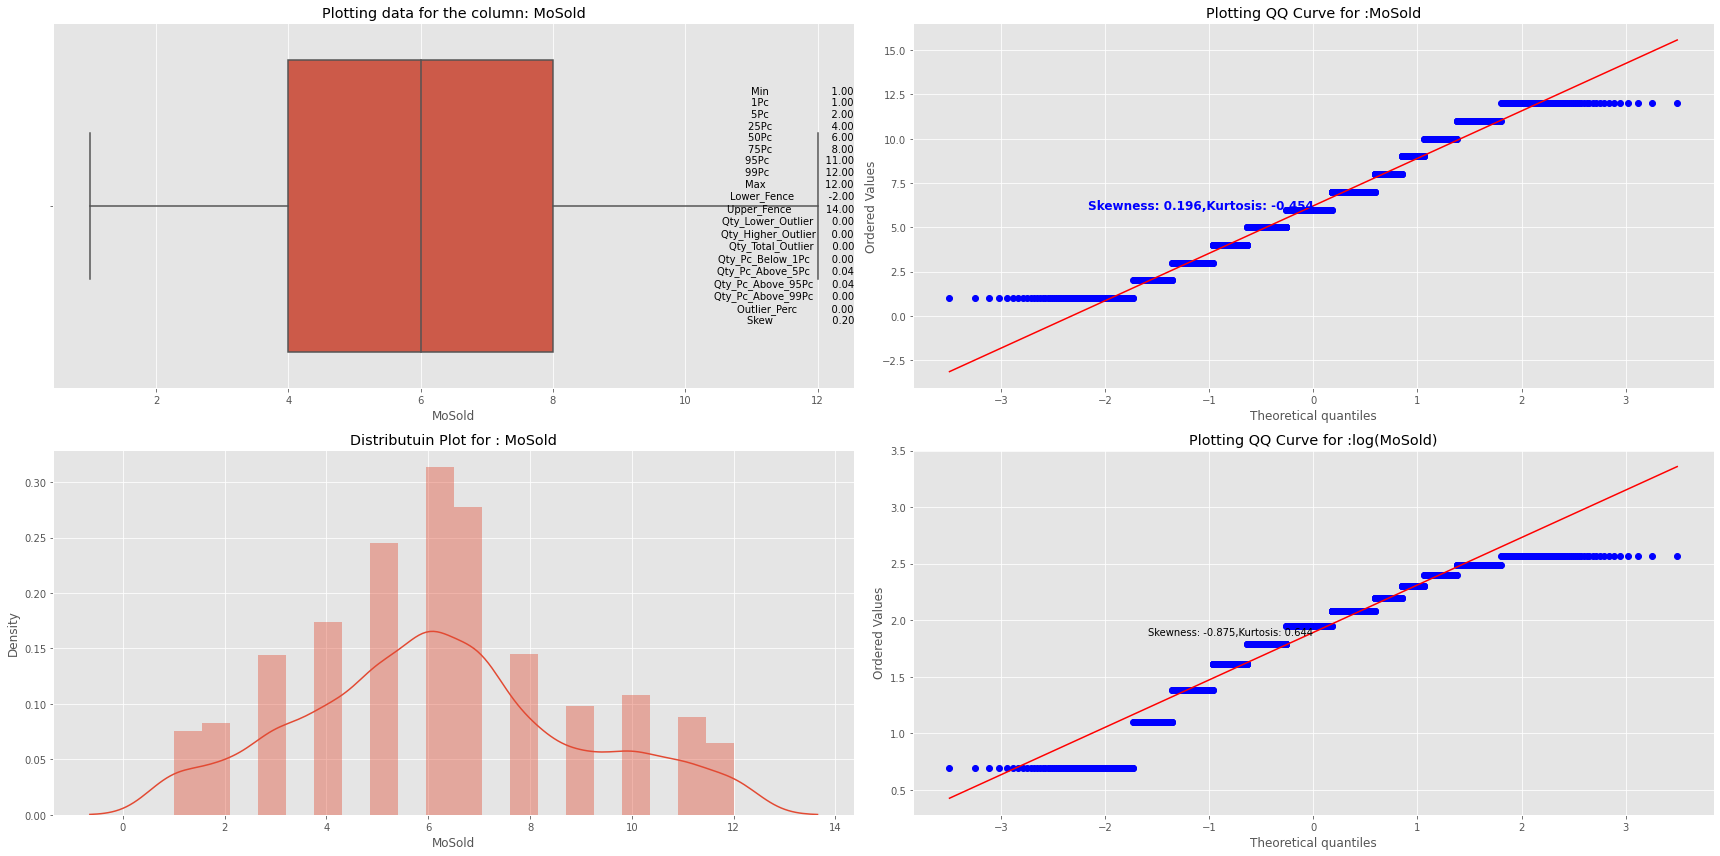

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


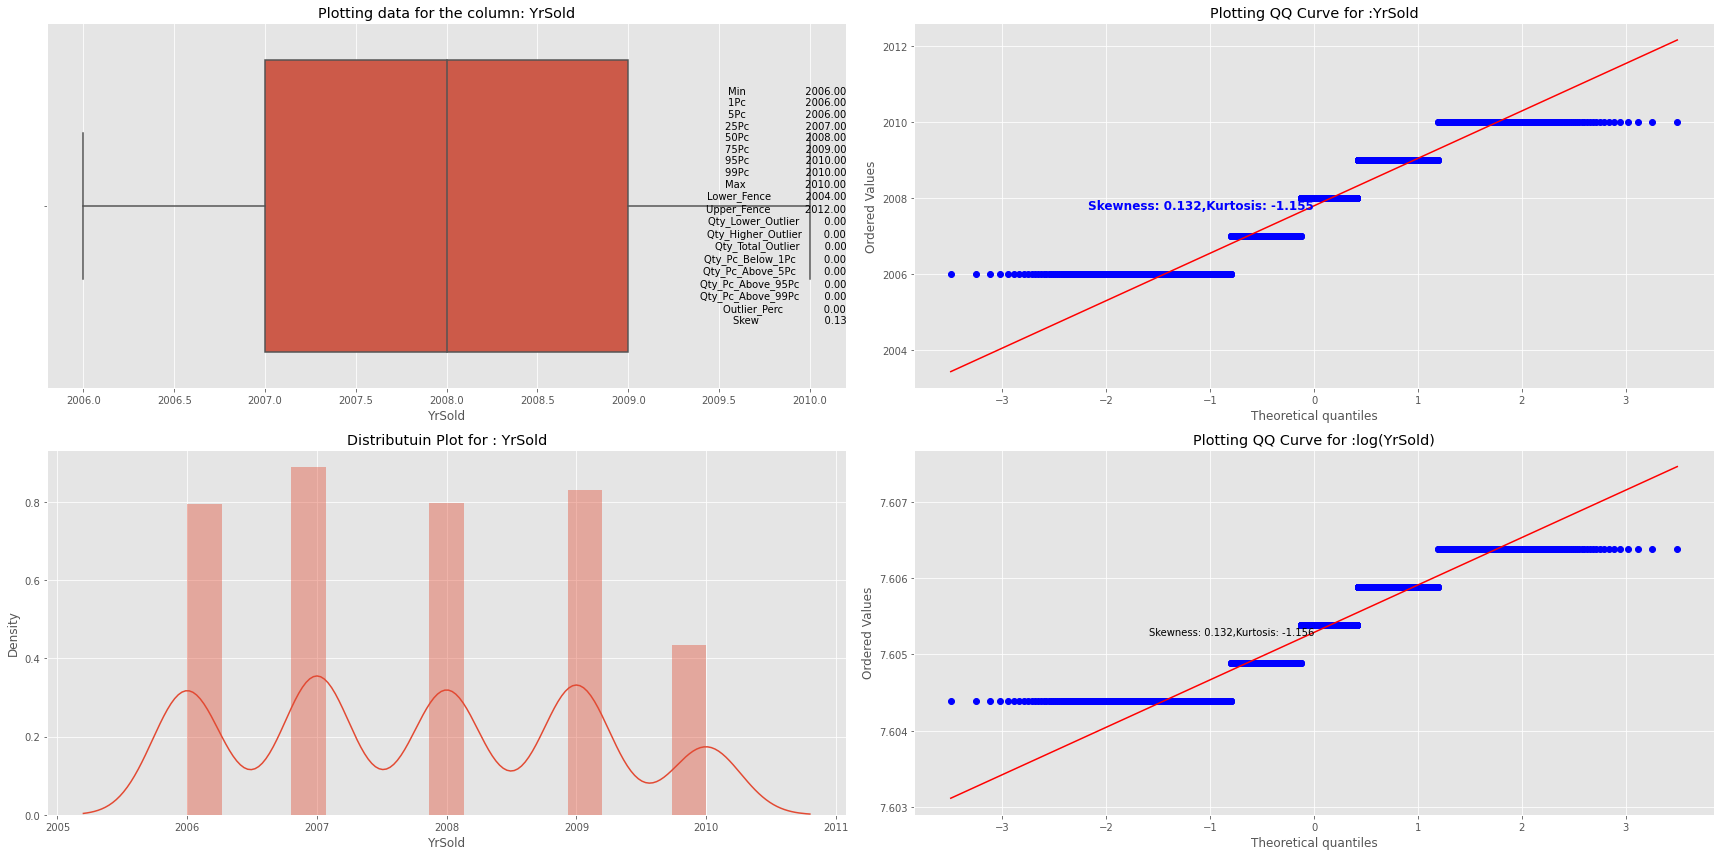

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_pdf.py:939: RuntimeWarning: Glyph 0 missing from current font.
  self.writeObject(fontdictObject, fontdict)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_pdf.py:939: RuntimeWarning: Glyph 1 missing from current font.
  self.writeObject(fontdictObject, fontdict)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_pdf.py:939: RuntimeWarning: Glyph 2 missing from current font.
  self.writeObject(fontdictObject, fontdict)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_pdf.py:939: RuntimeWarning: Glyph 3 missing from current font.
  self.writeObject(fontdictObject, fontdict)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_pdf.py:939: RuntimeWarning: Glyph 4 missing from current font.
  self.writeObject(fontdictObject, fontdict)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_pdf.py:939: RuntimeWarning: Glyph 5 missing from current f

EnclosedPorch  BsmtFinSF2  LotFrontage  ScreenPorch  \
Min                          0.00        0.00        21.00         0.00   
1Pc                          0.00        0.00        21.00         0.00   
5Pc                          0.00        0.00        35.00         0.00   
25Pc                         0.00        0.00        60.00         0.00   
50Pc                         0.00        0.00        69.31         0.00   
75Pc                         0.00        0.00        78.00         0.00   
95Pc                       176.00      435.00       105.00       161.00   
99Pc                       264.00      874.64       132.64       259.82   
Max                       1012.00     1526.00       313.00       576.00   
Lower_Fence                  0.00        0.00        33.00         0.00   
Upper_Fence                  0.00        0.00       105.00         0.00   
Qty_Lower_Outlier            0.00        0.00       125.00         0.00   
Qty_Higher_Outlier         459.00      348.00       135.00       256.00   
Qty_Total_Outlier          459.00      348.00       260.00       256.00   
Qty_Pc_Below_1Pc             0.00        0.00         0.00         0.00   
Qty_Pc_Above_5Pc             0.00        0.00         0.05         0.00   
Qty_Pc_Above_95Pc            0.05        0.05         0.05         0.05   
Qty_Pc_Above_99Pc            0.01        0.01         0.01         0.01   
Outlier_Perc                16.00       12.00         9.00         9.00   
Skew                         4.01        4.15         1.65         3.95   

                    OverallCond  MSSubClass  MasVnrArea  BsmtHalfBath  \
Min                        1.00       20.00        0.00          0.00   
1Pc                        3.00       20.00        0.00          0.00   
5Pc                        4.00       20.00        0.00          0.00   
25Pc                       5.00       20.00        0.00          0.00   
50Pc                       5.00       50.00        0.00          0.00   
75Pc                       6.00       70.00      163.50          0.00   
95Pc                       8.00      160.00      466.00          1.00   
99Pc                       9.00      190.00      770.46          1.00   
Max                        9.00      190.00     1600.00          2.00   
Lower_Fence                3.50      -55.00     -245.25          0.00   
Upper_Fence                7.50      145.00      408.75          0.00   
Qty_Lower_Outlier         67.00        0.00        0.00          0.00   
Qty_Higher_Outlier       185.00      207.00      202.00        175.00   
Qty_Total_Outlier        252.00      207.00      202.00        175.00   
Qty_Pc_Below_1Pc           0.01        0.00        0.00          0.00   
Qty_Pc_Above_5Pc           0.02        0.00        0.00          0.00   
Qty_Pc_Above_95Pc          0.01        0.03        0.05          0.00   
Qty_Pc_Above_99Pc          0.00        0.00        0.01          0.00   
Outlier_Perc               9.00        7.00        7.00          6.00   
Skew                       0.57        1.38        2.61          3.93   

                    OpenPorchSF  KitchenAbvGr  ...  YearBuilt  2ndFlrSF  \
Min                        0.00          0.00  ...    1872.00      0.00   
1Pc                        0.00          1.00  ...    1900.00      0.00   
5Pc                        0.00          1.00  ...    1915.00      0.00   
25Pc                       0.00          1.00  ...    1953.50      0.00   
50Pc                      26.00          1.00  ...    1973.00      0.00   
75Pc                      70.00          1.00  ...    2001.00    704.00   
95Pc                     183.10          1.00  ...    2007.00   1131.20   
99Pc                     284.46          2.00  ...    2008.00   1400.20   
Max                      742.00          3.00  ...    2010.00   2065.00   
Lower_Fence             -105.00          1.00  ...    1882.25  -1056.00   
Upper_Fence              175.00          1.00  ...    2072.25   1760.00   
Qty_Lower_

In [31]:
outlier_df=get_outlier(data_df,plot_graph=True)
outlier_df

In [32]:
# for col_ind in outlier_df:
#     fig=px.box(x=data_df[col_ind],title=col_ind,width=1000,height=400,notched=True,orientation='h')
#     px.box()
#     fig.show()

In [33]:
## Restricting Data at 95 % and 5% Values

## TODO- This to be Tried Differntly Checking Individual Graphs

for col_ind in outlier_df:
  data_df[col_ind]=np.where(data_df[col_ind]>data_df[col_ind].quantile(0.95),
                            data_df[col_ind].quantile(0.95) ,data_df[col_ind])
  data_df[col_ind]=np.where(data_df[col_ind]<data_df[col_ind].quantile(0.05),
                            data_df[col_ind].quantile(0.05) ,data_df[col_ind])

### Step 2.3 : Other Treatment

In [34]:
## Changing Years to property age -- Keeping 30 Jun 2020 Benchmark
# YearBuilt
# YearRemodAdd
# GarageYrBlt
# MoSold # YrSold --- >> This to be clubbed , So Age needs to be mentioned in Months

## For data_df -->>With outlier Treatement
CurrentYear=2020

data_df.YearBuilt=(CurrentYear-data_df.YearBuilt)
data_df.YearBuilt=data_df.YearBuilt.astype("int")

data_df.YearRemodAdd=(CurrentYear-data_df.YearRemodAdd)
data_df.YearRemodAdd=data_df.YearRemodAdd.astype("int")

data_df.GarageYrBlt=(CurrentYear-data_df.GarageYrBlt)
data_df.GarageYrBlT=data_df.GarageYrBlt.astype("int")

data_df.MoSold=((CurrentYear-data_df.YrSold)*(12))+(12-data_df.MoSold)
data_df.MoSold=data_df.MoSold.astype("int")
data_df.drop("YrSold",axis=1,inplace=True)

## For data_df -->> Without outlier Treatement

data_df_wo_trtment.YearBuilt=(CurrentYear-data_df_wo_trtment.YearBuilt)
data_df_wo_trtment.YearBuilt=data_df_wo_trtment.YearBuilt.astype("int")

data_df_wo_trtment.YearRemodAdd=(CurrentYear-data_df_wo_trtment.YearRemodAdd)
data_df_wo_trtment.YearRemodAdd=data_df_wo_trtment.YearRemodAdd.astype("int")

data_df_wo_trtment.GarageYrBlt=(CurrentYear-data_df_wo_trtment.GarageYrBlt)
data_df_wo_trtment.GarageYrBlT=data_df_wo_trtment.GarageYrBlt.astype("int")

data_df_wo_trtment.MoSold=((CurrentYear-data_df_wo_trtment.YrSold)*(12))+(12-data_df_wo_trtment.MoSold)
data_df_wo_trtment.MoSold=data_df_wo_trtment.MoSold.astype("int")
data_df_wo_trtment.drop("YrSold",axis=1,inplace=True)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access


## Step 3 : EDA and Treatment of the Cat. variable


In [35]:
df_trtd=data_df ## Dataset with treatment
df_wo_trtment=data_df_wo_trtment  ## Dataset without treatment

### Step 3.1 : Univariate and Bivariate Analysis of Categorical Variable

In [36]:
## Converting Numerical Data to object where applicable
df_trtd.MSSubClass=df_trtd.MSSubClass.astype('object')
df_trtd.MoSold=df_trtd.MoSold.astype('object')
df_trtd.OverallQual=df_trtd.OverallQual.astype('object')
df_trtd.OverallCond=df_trtd.OverallCond.astype('object')
df_trtd.YearBuilt=df_trtd.YearBuilt.astype('object')
df_trtd.YearRemodAdd=df_trtd.YearRemodAdd.astype('object')
df_trtd.LowQualFinSF=df_trtd.LowQualFinSF.astype('object')
df_trtd.BsmtFullBath=df_trtd.BsmtFullBath.astype('object')
df_trtd.BsmtHalfBath=df_trtd.BsmtHalfBath.astype('object')
df_trtd.FullBath=df_trtd.FullBath.astype('object')
df_trtd.HalfBath=df_trtd.HalfBath.astype('object')
df_trtd.BedroomAbvGr=df_trtd.BedroomAbvGr.astype('object')
df_trtd.KitchenAbvGr=df_trtd.KitchenAbvGr.astype('object')
df_trtd.TotRmsAbvGrd=df_trtd.TotRmsAbvGrd.astype('object')
df_trtd.Fireplaces=df_trtd.Fireplaces.astype('object')
df_trtd.GarageYrBlt=df_trtd.GarageYrBlt.astype('object')
df_trtd.GarageCars=df_trtd.GarageCars.astype('object')
df_trtd.MiscVal=df_trtd.MiscVal.astype('object')

In [37]:
## Converting Numerical Data to object where applicable
df_wo_trtment.MSSubClass=df_wo_trtment.MSSubClass.astype('object')
df_wo_trtment.MoSold=df_wo_trtment.MoSold.astype('object')
df_wo_trtment.OverallQual=df_wo_trtment.OverallQual.astype('object')
df_wo_trtment.OverallCond=df_wo_trtment.OverallCond.astype('object')
df_wo_trtment.YearBuilt=df_wo_trtment.YearBuilt.astype('object')
df_wo_trtment.YearRemodAdd=df_wo_trtment.YearRemodAdd.astype('object')
df_wo_trtment.LowQualFinSF=df_wo_trtment.LowQualFinSF.astype('object')
df_wo_trtment.BsmtFullBath=df_wo_trtment.BsmtFullBath.astype('object')
df_wo_trtment.BsmtHalfBath=df_wo_trtment.BsmtHalfBath.astype('object')
df_wo_trtment.FullBath=df_wo_trtment.FullBath.astype('object')
df_wo_trtment.HalfBath=df_wo_trtment.HalfBath.astype('object')
df_wo_trtment.BedroomAbvGr=df_wo_trtment.BedroomAbvGr.astype('object')
df_wo_trtment.KitchenAbvGr=df_wo_trtment.KitchenAbvGr.astype('object')
df_wo_trtment.TotRmsAbvGrd=df_wo_trtment.TotRmsAbvGrd.astype('object')
df_wo_trtment.Fireplaces=df_wo_trtment.Fireplaces.astype('object')
df_wo_trtment.GarageYrBlt=df_wo_trtment.GarageYrBlt.astype('object')
df_wo_trtment.GarageCars=df_wo_trtment.GarageCars.astype('object')
df_wo_trtment.MiscVal=df_wo_trtment.MiscVal.astype('object')

In [38]:
def cat_var_plot(df,targ_col):

  obj_cl_list=df.select_dtypes(include=["object"])
  pdf = PdfPages("/content/Cat_Variable_Plot " +datetime.now(pytz.timezone('Asia/Kolkata')).strftime("%d-%m-%y_%H%M")+ ".pdf")
  for column in obj_cl_list:

    fig = plt.figure(constrained_layout=False, figsize=(24,12))## Width , Height
    grid = gridspec.GridSpec(ncols=2, nrows=2, figure=fig) 

    ax1 = fig.add_subplot(grid[0, :1]) ## 1st Row, 1 Column
    ax1.set_title('Count Chart for the column: '+ column)
    sns.countplot(x=column,data = df,
                  order = df[column].value_counts().index,ax = ax1,)
    plt.xticks(rotation=90)
    for p in ax1.patches:
        ax1.annotate('{:.0f}'.format(p.get_height()),(p.get_x()+0.2, p.get_height()+2))

    ax2 = fig.add_subplot(grid[1, :1]) ## 2st Row, 1 Column
    ax2.set_title('Count Chart for the column: '+ column)
    sns.boxplot(x=column, y= targ_col, data = df,
                order = df[column].value_counts().index,ax=ax2)
    # # Calculate number of obs per group & median to position labels
    # medians = df.groupby([column])[targ_col].median().values
    # nobs = df[column].value_counts().values
    # nobs = [str(x) for x in nobs.tolist()]
    # nobs = ["n: " + i for i in nobs]
    # # Add it to the plot
    # pos = range(len(nobs))
    # for tick,label in zip(pos,ax2.get_xticklabels()):
    #   ax2.text(pos[tick], medians[tick] + 0.03, nobs[tick],
    #   horizontalalignment='center', color='b', weight='bold') #, size='x-small'
       
    ax3 = fig.add_subplot(grid[:, 1]) ## 2nd Column >> This use complete Second Column
    df[column].value_counts().plot.pie(autopct = "%2.2f%%", ax=ax3)
    ax3.set_title('Pie Chart for the column: '+ column)  
    
    fig.tight_layout()
    plt.show()
    pdf.savefig(fig)
  pdf.close()
  ## files.download("/content/Cat Var Chart.pdf")    
  return fig

ValueError: ignored

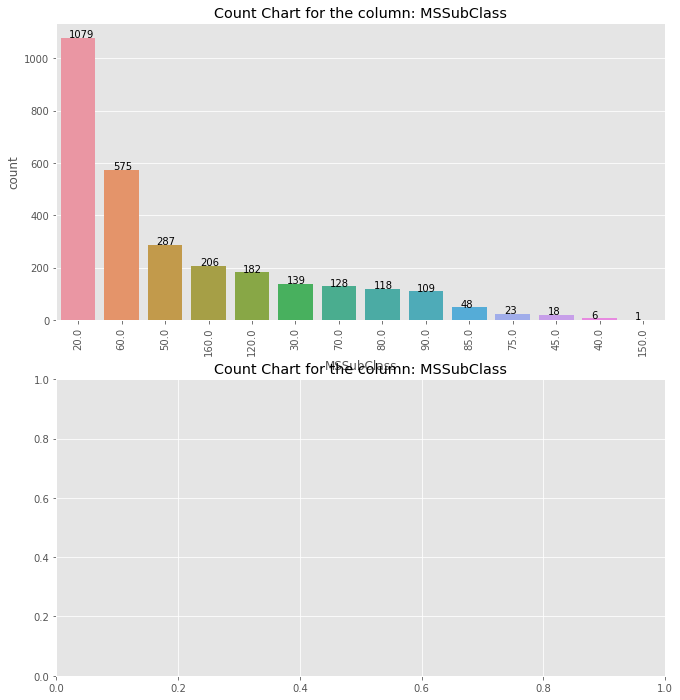

In [40]:
cat_var_plot(df_trtd,"SalePrice")

### Step 3.2 : Treating Ordinal Cat. and Discrete Variable with Label Encoding after analyzing above chart

In [41]:
## Treating all the ordinal Variable
# Lable Encoding in Street --> Can be removed during model preparation as there is no variance
df_trtd.Street.replace({"Pave":0,"Grvl":1},inplace=True)
## Clubbing Ordianl feature , label encoding
df_trtd.LotShape.replace({"Reg":0,"IR1":1,"IR2":2,"IR3":3},inplace=True)
## Droping , as no variance in column
df_trtd.drop("Utilities",axis=1,inplace=True)
## Land Slope (Ordinal): Slope of property - Using label Encoding , Gtl=1,Mod=2,Sev=3
df_trtd.LandSlope.replace({"Gtl":0,"Mod":1,"Sev":2},inplace=True)
df_trtd.YearRemodAdd=df_trtd.YearRemodAdd.astype("int")
# ## Exter Qual,Exter Cond,BsmtQual - Ordinal
df_trtd.ExterQual.replace({"Ex":0,"Gd":1,"TA":2,"Fa":3,"Po":4},inplace=True)
df_trtd.ExterCond.replace({"Ex":0,"Gd":1,"TA":2,"Fa":3,"Po":4},inplace=True)
df_trtd.BsmtQual.replace({"Ex":0,"Gd":1,"TA":2,"Fa":3,"Po":4},inplace=True)
df_trtd.BsmtCond.replace({"Ex":0,"Gd":1,"TA":2,"Fa":3,"Po":4},inplace=True)
# ## BsmtExposure - Ordinal
df_trtd.BsmtExposure.replace({"Gd":0,"Av":1,"Mn":2,"No":3},inplace=True)
# ## BsmtFinType1 , BsmtFinType2 - Ordinal
df_trtd.BsmtFinType1.replace({"GLQ":0,"BLQ":1,"ALQ":2,"Rec":3,"LwQ":4,"Unf":5},inplace=True)
df_trtd.BsmtFinType2.replace({"GLQ":0,"BLQ":1,"ALQ":2,"Rec":3,"LwQ":4,"Unf":5},inplace=True)
# ## HeatingQC -ordinal
df_trtd.HeatingQC.replace({"Ex":0,"Gd":1,"TA":2,"Fa":3,"Po":4},inplace=True)
## Lable Encoding
df_trtd.CentralAir.replace({"Y":0,"N":1},inplace=True)
# Electrical (Ordinal): Electrical system
df_trtd.Electrical.replace({"SBrkr":0,"FuseA":1,"FuseF":2,"FuseP":3,"Mix":4},inplace=True)
df_trtd.drop("LowQualFinSF",axis=1,inplace=True)
df_trtd.drop("KitchenAbvGr",axis=1,inplace=True)
df_trtd.KitchenQual.replace({"Ex":0,"Gd":1,"TA":2,"Fa":3,"Po":4},inplace=True)
df_trtd.Functional.replace({"Min1":0,"Min2":1,"Mod":2,"Maj1":3,"Maj2":4,"Sev":5,"Sal":6},inplace=True)
df_trtd.GarageFinish.replace({"Fin":0,"RFn":1,"Unf":2,"NA":3},inplace=True)
df_trtd.GarageCars=df_trtd.GarageCars.astype("int")
df_trtd.GarageQual.replace({"Ex":0,"Gd":1,"TA":2,"Fa":3,"Po":4},inplace=True)
df_trtd.GarageCond.replace({"Ex":0,"Gd":1,"TA":2,"Fa":3,"Po":4},inplace=True)
df_trtd.PavedDrive.replace({"Y":0,"P":1,"N":2},inplace=True)
df_trtd.drop("MiscVal",axis=1,inplace=True)

In [42]:
## Treating all the ordinal Variable
# Lable Encoding in Street --> Can be removed during model preparation as there is no variance
df_wo_trtment.Street.replace({"Pave":0,"Grvl":1},inplace=True)
## Clubbing Ordianl feature , label encoding
df_wo_trtment.LotShape.replace({"Reg":0,"IR1":1,"IR2":2,"IR3":3},inplace=True)
## Droping , as no variance in column
df_wo_trtment.drop("Utilities",axis=1,inplace=True)
## Land Slope (Ordinal): Slope of property - Using label Encoding , Gtl=1,Mod=2,Sev=3
df_wo_trtment.LandSlope.replace({"Gtl":0,"Mod":1,"Sev":2},inplace=True)
df_wo_trtment.YearRemodAdd=df_wo_trtment.YearRemodAdd.astype("int")
# ## Exter Qual,Exter Cond,BsmtQual - Ordinal
df_wo_trtment.ExterQual.replace({"Ex":0,"Gd":1,"TA":2,"Fa":3,"Po":4},inplace=True)
df_wo_trtment.ExterCond.replace({"Ex":0,"Gd":1,"TA":2,"Fa":3,"Po":4},inplace=True)
df_wo_trtment.BsmtQual.replace({"Ex":0,"Gd":1,"TA":2,"Fa":3,"Po":4},inplace=True)
df_wo_trtment.BsmtCond.replace({"Ex":0,"Gd":1,"TA":2,"Fa":3,"Po":4},inplace=True)
# ## BsmtExposure - Ordinal
df_wo_trtment.BsmtExposure.replace({"Gd":0,"Av":1,"Mn":2,"No":3},inplace=True)
# ## BsmtFinType1 , BsmtFinType2 - Ordinal
df_wo_trtment.BsmtFinType1.replace({"GLQ":0,"BLQ":1,"ALQ":2,"Rec":3,"LwQ":4,"Unf":5},inplace=True)
df_wo_trtment.BsmtFinType2.replace({"GLQ":0,"BLQ":1,"ALQ":2,"Rec":3,"LwQ":4,"Unf":5},inplace=True)
# ## HeatingQC -ordinal
df_wo_trtment.HeatingQC.replace({"Ex":0,"Gd":1,"TA":2,"Fa":3,"Po":4},inplace=True)
## Lable Encoding
df_wo_trtment.CentralAir.replace({"Y":0,"N":1},inplace=True)
# Electrical (Ordinal): Electrical system
df_wo_trtment.Electrical.replace({"SBrkr":0,"FuseA":1,"FuseF":2,"FuseP":3,"Mix":4},inplace=True)
df_wo_trtment.drop("LowQualFinSF",axis=1,inplace=True)
df_wo_trtment.drop("KitchenAbvGr",axis=1,inplace=True)
df_wo_trtment.KitchenQual.replace({"Ex":0,"Gd":1,"TA":2,"Fa":3,"Po":4},inplace=True)
df_wo_trtment.Functional.replace({"Min1":0,"Min2":1,"Mod":2,"Maj1":3,"Maj2":4,"Sev":5,"Sal":6},inplace=True)
df_wo_trtment.GarageFinish.replace({"Fin":0,"RFn":1,"Unf":2,"NA":3},inplace=True)
df_wo_trtment.GarageCars=df_wo_trtment.GarageCars.astype("int")
df_wo_trtment.GarageQual.replace({"Ex":0,"Gd":1,"TA":2,"Fa":3,"Po":4},inplace=True)
df_wo_trtment.GarageCond.replace({"Ex":0,"Gd":1,"TA":2,"Fa":3,"Po":4},inplace=True)
df_wo_trtment.PavedDrive.replace({"Y":0,"P":1,"N":2},inplace=True)
df_wo_trtment.drop("MiscVal",axis=1,inplace=True)

In [43]:
def convert_to_int(df,obj_col):
  x= pd.DataFrame(df[obj_col]).applymap(lambda x: isinstance(x, (int, float))).sum().tolist()[0]/len(df[obj_col])
  if x==1:
    df[obj_col]=df[obj_col].astype('int')
    return df[obj_col]
  else :
    return df[obj_col]

In [44]:
for obj_col in df_trtd.select_dtypes(exclude=["int","float"]):
  df_trtd[obj_col]=convert_to_int(df_trtd,obj_col)

for obj_col in df_wo_trtment.select_dtypes(exclude=["int","float"]):
  df_wo_trtment[obj_col]=convert_to_int(df_wo_trtment,obj_col)

### Step 3.3 : Univariate and Bivariant Analysis of Numerical variable

In [45]:
def Num_var_plot(df,targ_col):
  
  num_cl_list=df.select_dtypes(exclude=["object"])
  pdf = PdfPages("/content/Num_Variable_Plot " +datetime.now(pytz.timezone('Asia/Kolkata')).strftime("%d-%m-%y_%H%M")+ ".pdf")
  for column in num_cl_list:

    fig = plt.figure(constrained_layout=False, figsize=(24,12))## Width , Height
    grid = gridspec.GridSpec(ncols=2, nrows=2, figure=fig) 

    ax1 = fig.add_subplot(grid[0, :1])
    ax1.set_title('Density for the column: '+ column)
    sns.distplot(df[column],ax = ax1)
    
    ax2 = fig.add_subplot(grid[1, :1])
    plt.hist(data = df,x=column)
    plt.title('Histogram Chart for the column: '+ column)

    ax3 = fig.add_subplot(grid[0, 1])
    sns.scatterplot(x=column, y= "SalePrice", data = df,ax=ax3)
    plt.title(column + " Vs. Sales Price" )
    

    ax4 = fig.add_subplot(grid[1, 1])
    sns.regplot(x=column, y="SalePrice", data=df,ax=ax4)
    plt.title(column + " Vs. Sales Price" )
    pearson_coef, p_value = stats.pearsonr(df_trtd[column], df_trtd[targ_col])
    vals="Pearson_coef : "+ str(pearson_coef)
    ax4.text(0.5,0.7,vals,
             horizontalalignment='left',
             verticalalignment='center',
             transform = ax4.transAxes,color='b', weight='bold',fontsize = 15)

    fig.tight_layout() 
    plt.show()
    pdf.savefig(fig)
  pdf.close()
  return fig

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


ValueError: ignored

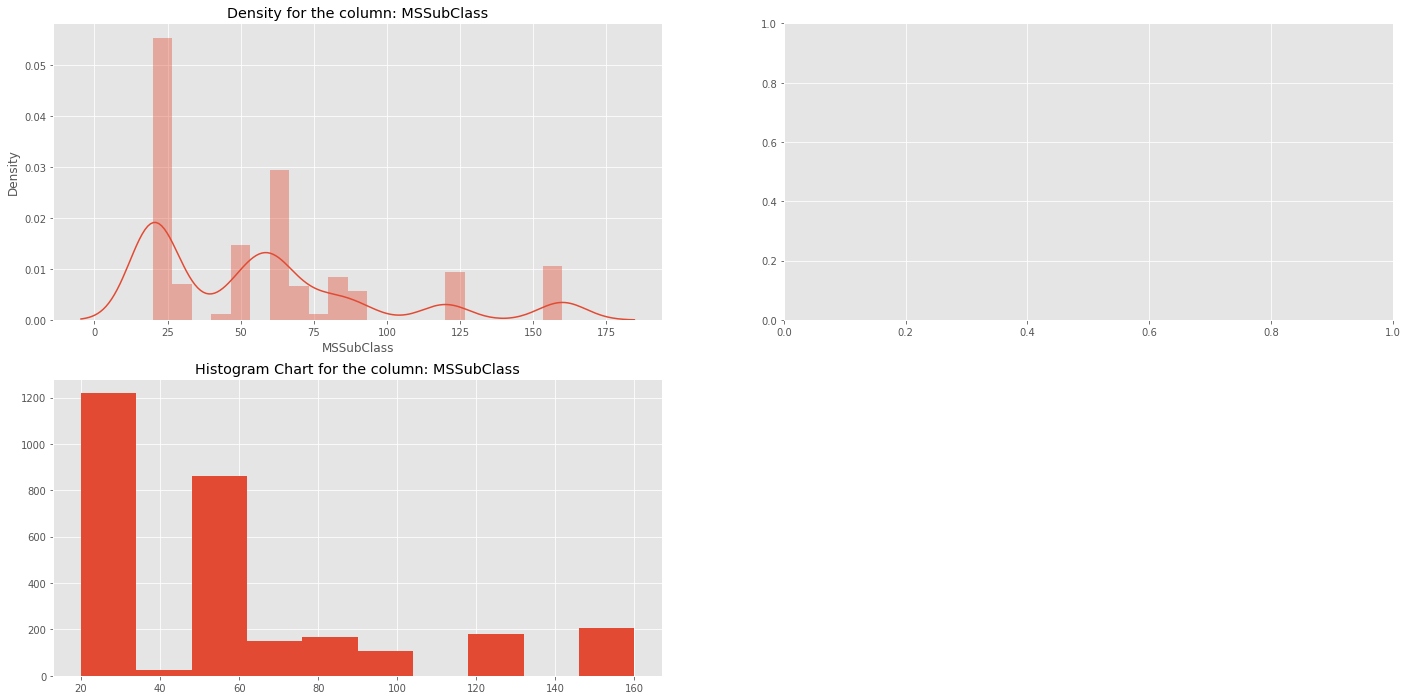

In [46]:
Num_var_plot(df_trtd,"SalePrice")

### Step 3.4 : Correlation Chart

In [47]:
def Corr_plot(df,targ_col):
  
  num_cl_list=df.select_dtypes(exclude=["object"])
  pdf = PdfPages("/content/Corr_Plot " +datetime.now(pytz.timezone('Asia/Kolkata')).strftime("%d-%m-%y_%H%M")+ ".pdf")
  
  fig1 = plt.figure(constrained_layout=False, figsize=(24,12))## Width , Height
  corr = df.corr()
  # Generate a mask for the upper triangle
  mask = np.triu(np.ones_like(corr, dtype=np.bool))
  # Generate a custom diverging colormap
  cmap = sns.diverging_palette(220, 10, as_cmap=True)
  sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
              square=True, linewidths=.5, cbar_kws={"shrink": .5},annot=True,fmt='.2f', annot_kws={'size': 6})
  
  fig1.tight_layout() 
  plt.show()
  pdf.savefig(fig1)
  
  fig2 = plt.figure(constrained_layout=False, figsize=(24,12))
  corrSale=pd.DataFrame(corr.SalePrice)
  corrSale.reset_index(inplace=True)
  corrSale.sort_values(by=targ_col,ascending=True,inplace=True)
  corrSale.dropna(inplace=True)
  corrSale.columns=["Feature","Value"]
  sns.barplot(y="Feature",x="Value",data=corrSale)
  plt.axvline(x=0)
  fig2.tight_layout() 
  plt.show()
  pdf.savefig(fig2)

  pdf.close()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if __name__ == '__main__':


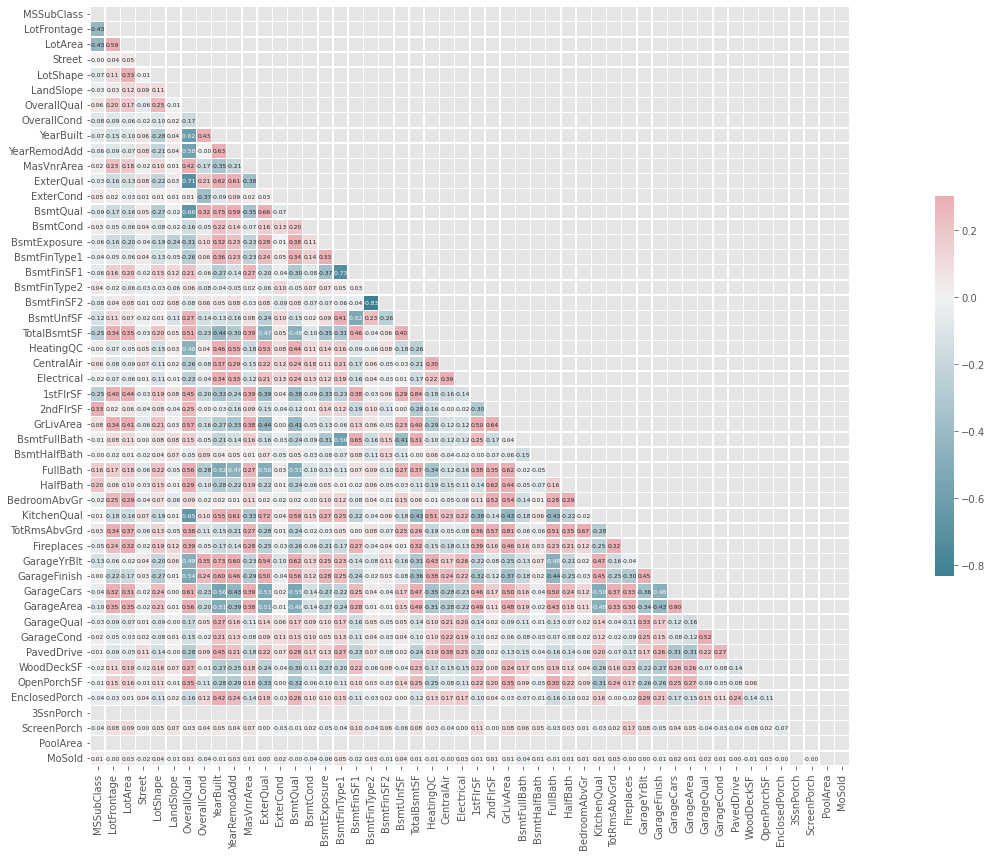

AttributeError: ignored

<Figure size 1728x864 with 0 Axes>

In [48]:
Corr_plot(df_trtd,"SalePrice")

In [49]:
cor_target =df_trtd.corr().abs()
Feature_corr =cor_target.unstack().to_frame(name='Correlation')
Feature = Feature_corr[(Feature_corr['Correlation']>=0.8)&(Feature_corr['Correlation']<1)].sort_values(by='Correlation', ascending = False).reset_index()
Feature=Feature[(Feature["level_0"]!="SalePrice") & (Feature["level_1"]!="SalePrice")]
Feature
# Target_Corr = cor_target.corr()['SalePrice'].to_frame().reset_index() #Feature Correlation related to SalePrice

level_0       level_1  Correlation
0    GarageCars    GarageArea     0.904105
1    GarageArea    GarageCars     0.904105
2   TotalBsmtSF      1stFlrSF     0.842863
3      1stFlrSF   TotalBsmtSF     0.842863
4  BsmtFinType2    BsmtFinSF2     0.832185
5    BsmtFinSF2  BsmtFinType2     0.832185
6     GrLivArea  TotRmsAbvGrd     0.809443
7  TotRmsAbvGrd     GrLivArea     0.809443

## Step 4 : ML Model Building

In [50]:
df_trtd["SalePrice"]=df_Y
df_trtd["Id"]=df_ID
df_trtd
df_trtd_tst_kg=df_trtd[df_trtd["Id"]>1460]
df_trtd=df_trtd[df_trtd["Id"]<1461]

In [51]:
df_trtd.drop("Id",axis=1,inplace=True)
df_trtd_tst_kg.drop("Id",axis=1,inplace=True)
df_trtd_tst_kg.drop("SalePrice",axis=1,inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [52]:
df_trtd.MSSubClass=df_trtd.MSSubClass.astype("object")
X_trtd=df_trtd.drop(columns="SalePrice")
y_trtd=df_trtd["SalePrice"]
# X_trtd_trn, X_trtd_tst, y_trtd_trn, y_trtd_tst = train_test_split(X_trtd, y_trtd, test_size=0.15, random_state=87987)

/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [53]:
X_trtd.shape,y_trtd.shape

((1460, 69), (1460,))

In [54]:
y_trtd=pd.DataFrame(y_trtd)

In [55]:
y_trtd.columns=["SalePrice"]

In [56]:
y_trtd["SalePrice"]=np.log1p(y_trtd["SalePrice"])

### Step 4.1 : Models with Hyperparameter tuning with Treated Data

In [57]:
summary_df=pd.DataFrame(columns=["Model_Number","R2_Trn","R2_Val","R2_Tst","RMSE_Trn","RMSE_Val","RMSE_Tst","Model_Detail"])

In [58]:
def predic_plot(mod_name,R2_Trn,R2_Val,R2_Tst,RMSE_Trn,RMSE_Val,RMSE_Tst,best_mod):  
  fig = plt.figure(constrained_layout=False, figsize=(24,12))## Width , Height
  grid = gridspec.GridSpec(ncols=2, nrows=2, figure=fig) 

  ax1 = fig.add_subplot(grid[0, 0]) ## 1st Row, 1 Column
  ax1.set_title('Actual Vs. Predicted',fontsize = 20)
  ax1.set_xlabel('Actual')
  ax1.set_ylabel('Predicted')
  sns.regplot(y_pred,y_trtd_tst,ax=ax1)
  vals1="R2 Train = "+str(round(R2_Trn,2))+"\n R2 Val. = " + str(round(R2_Val,2))+ \
        "\n R2 Test = "+str(round(R2_Tst,2))+\
        "\n RMSE Train = "+str(round(RMSE_Trn,2))+"\n RMSE Val. = " + \
        str(round(RMSE_Val,2))+"\n RMSE Test = "+str(round(RMSE_Tst,2))
  vals2=str(best_mod)
  ax1.text(0.75, 0.2,vals1,
          horizontalalignment='left',
          verticalalignment='center',
          transform = ax1.transAxes,color='black', weight='bold',fontsize = 15)
  ax1.text(0.1, 0.8,vals2,
          horizontalalignment='left',
          verticalalignment='center',
          transform = ax1.transAxes,color='black', weight='bold',fontsize = 15)

  ax2 = fig.add_subplot(grid[0, 1]) ## 1st Row, 1 Column
  sns.distplot((y_pred-y_trtd_tst), bins = 20,ax=ax2)
  ax2.set_title('Residual Distribution', fontsize = 20)
  vals3="Skew = "+str(round((y_pred-y_trtd_tst).skew(),3))+"\n Mean = "+str(round((y_pred-y_trtd_tst).mean(),3))
  ax2.text(0.5, 0.5,vals3,
          horizontalalignment='center',
          verticalalignment='center',
          transform = ax2.transAxes,color='black', weight='bold',fontsize = 15)

  ax3 = fig.add_subplot(grid[1,:])
  ax3.plot(y_trtd_tst.reset_index(drop=True),"b",label="Actual")
  ax3.plot(y_pred,"g",label="Predicted")
  ax3.set_title('Actual vs Predicted',fontsize = 20)
  # vals4="Actual in Blue Color"+"\n Predicted in Green Color"
  # ax3.text(0.2, 0.9,vals4,
  #         horizontalalignment='center',
  #         verticalalignment='center',
  #         transform = ax3.transAxes,color='black', weight='bold',fontsize = 15)
  
  fig.tight_layout()
  pdf = PdfPages("/content/predic_plot_{0}".format(mod_name) +datetime.now(pytz.timezone('Asia/Kolkata')).strftime("%d-%m-%y_%H%M")+ ".pdf")
  pdf.savefig(fig)
  pdf.close()

In [59]:
## Model : 1

print("Model 1 : Ridge with Tuning ")
pipeline = Pipeline([('encoder',LabelEncoder()),
                        ('scaler', StandardScaler()),
                        ('imputer', SimpleImputer(strategy='mean')),
                        ('ridge',Ridge())])

### Multiple Hyperparameter to be added in this dictionary 
alphas=[1e-15,1e-10,1e-8,1e-3,1e-2,1,5,10,20,30,35,40,45,50,55,100,150,200,500]

parameters = dict(ridge__alpha=alphas) 

## Model will observe all the metric in scoring #optimize based on fit parameter only
scoring = ['r2','neg_root_mean_squared_error']
folds=KFold(n_splits=10,shuffle=True,random_state=234)
GS_CV = GridSearchCV(estimator=pipeline,param_grid= parameters,
                     scoring=scoring,refit='neg_root_mean_squared_error',
                     cv=folds,verbose=2,return_train_score=True,
                     n_jobs=-1)

GS_CV.fit(X_trtd, y_trtd)
best_mod=GS_CV.best_estimator_.get_params()['ridge']

print(best_mod)
y_pred = GS_CV.predict(df_trtd_tst_kg)

#R2_Tst=r2_score(y_pred,y_trtd_tst)
#RMSE_Tst=np.sqrt(mean_squared_error(y_pred,y_trtd_tst))

R2_Trn=GS_CV.cv_results_['mean_train_r2'].mean()
RMSE_Trn=np.absolute(GS_CV.cv_results_['mean_train_neg_root_mean_squared_error'].mean())

R2_Val=GS_CV.cv_results_['mean_test_r2'].mean()
RMSE_Val=np.absolute(GS_CV.cv_results_['mean_test_neg_root_mean_squared_error'].mean())

summary_df.loc[len(summary_df)] = ["Ridge",R2_Trn,R2_Val,"NAN",RMSE_Trn,RMSE_Val,"NAN",best_mod]
#predic_plot("Ridge",R2_Trn,R2_Val,R2_Tst,RMSE_Trn,RMSE_Val,RMSE_Tst,best_mod) 
summary_df

Model 1 : Ridge with Tuning 
Fitting 10 folds for each of 19 candidates, totalling 190 fits
Ridge(alpha=100)


Model_Number    R2_Trn    R2_Val R2_Tst  RMSE_Trn  RMSE_Val RMSE_Tst  \
0        Ridge  0.898324  0.880935    NAN  0.127302  0.135969      NAN   

       Model_Detail  
0  Ridge(alpha=100)

In [61]:
y_pred_kg = GS_CV.predict(df_trtd_tst_kg)
y_pred_kg=pd.DataFrame(np.expm1(y_pred_kg))
y_pred_kg.to_excel("y_pred_kg_ridge.xlsx")
files.download("/content/y_pred_kg_ridge.xlsx")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
## Model : 2

print("Model 2 : Lasso with Tuning ")
pipeline_Lasso = Pipeline([('encoder', TargetEncoderCV()),
                        ('scaler', StandardScaler()),
                        ('imputer', SimpleImputer(strategy='mean')),
                        ('lasso',Lasso())])

### Multiple Hyperparameter to be added in this dictionary 
alphas=[1e-15,1e-10,1e-8,1e-3,1e-2,1,5,10,20,30,35,40,45,50,55,100,150,200,500]

parameters = dict(lasso__alpha=alphas) 

## Model will observe all the metric in scoring #optimize based on fit parameter only
scoring = ['r2','neg_root_mean_squared_error']
folds=KFold(n_splits=10,shuffle=True,random_state=234)
GS_CV_Lasso = GridSearchCV(estimator=pipeline_Lasso,param_grid= parameters,
                     scoring=scoring,refit='neg_root_mean_squared_error',
                     cv=folds,verbose=2,return_train_score=True,
                     n_jobs=-1)
GS_CV_Lasso.fit(X_trtd, y_trtd)

best_mod=GS_CV_Lasso.best_estimator_.get_params()['lasso']

print(best_mod)
y_pred = GS_CV_Lasso.predict(df_trtd_tst_kg)

#R2_Tst=r2_score(y_pred,y_trtd_tst)
#RMSE_Tst=np.sqrt(mean_squared_error(y_pred,y_trtd_tst))

R2_Trn=GS_CV_Lasso.cv_results_['mean_train_r2'].mean()
RMSE_Trn=np.absolute(GS_CV_Lasso.cv_results_['mean_train_neg_root_mean_squared_error'].mean())

R2_Val=GS_CV_Lasso.cv_results_['mean_test_r2'].mean()
RMSE_Val=np.absolute(GS_CV_Lasso.cv_results_['mean_test_neg_root_mean_squared_error'].mean())

summary_df.loc[len(summary_df)] = ["Lasso",R2_Trn,R2_Val,"NAN",RMSE_Trn,RMSE_Val,"NAN",best_mod]
#predic_plot("Lasso",R2_Trn,R2_Val,R2_Tst,RMSE_Trn,RMSE_Val,RMSE_Tst,best_mod)
summary_df

Model 2 : Lasso with Tuning 
Fitting 10 folds for each of 19 candidates, totalling 190 fits


In [ ]:
y_pred_kg_lasso = GS_CV_Lasso.predict(df_trtd_tst_kg)
pd.DataFrame(y_pred_kg_lasso).to_excel("y_pred_kg_lasso.xlsx")
files.download("/content/y_pred_kg_lasso.xlsx")

In [ ]:
## Model : 3

print("Model 3 : elasticnet with Tuning ")
pipeline_elasticnet = Pipeline([('encoder', TargetEncoderCV()),
                        ('scaler', StandardScaler()),
                        ('imputer', SimpleImputer(strategy='mean')),
                        ('elasticnet',ElasticNet())])

### Multiple Hyperparameter to be added in this dictionary 
parameters = dict(elasticnet__l1_ratio=np.arange(0.0, 1.0, 0.1),
                  elasticnet__alpha=[1e-15,1e-10,1e-8,1e-3,1e-2,1,5,10,20,30,35,40,45,50,55,100,150,200,500],
                  elasticnet__max_iter=[500,1000,1500])

## Model will observe all the metric in scoring #optimize based on fit parameter only
scoring = ['r2','neg_root_mean_squared_error']
folds=KFold(n_splits=10,shuffle=True,random_state=234)
GS_CV_elasticnet = GridSearchCV(estimator=pipeline_elasticnet,param_grid= parameters,
                     scoring=scoring,refit='neg_root_mean_squared_error',
                     cv=folds,verbose=2,return_train_score=True,
                     n_jobs=-1)
GS_CV_elasticnet.fit(X_trtd_trn, y_trtd_trn)

best_mod=GS_CV_elasticnet.best_estimator_.get_params()['elasticnet']
print(best_mod)
y_pred = GS_CV_elasticnet.predict(X_trtd_tst)

# R2_Tst=r2_score(y_pred,y_trtd_tst)
# RMSE_Tst=np.sqrt(mean_squared_error(y_pred,y_trtd_tst))

R2_Trn=GS_CV_elasticnet.cv_results_['mean_train_r2'].mean()
RMSE_Trn=np.absolute(GS_CV_elasticnet.cv_results_['mean_train_neg_root_mean_squared_error'].mean())

R2_Val=GS_CV_elasticnet.cv_results_['mean_test_r2'].mean()
RMSE_Val=np.absolute(GS_CV_elasticnet.cv_results_['mean_test_neg_root_mean_squared_error'].mean())

summary_df.loc[len(summary_df)] = ["Elasticnet",R2_Trn,R2_Val,"NAN",RMSE_Trn,RMSE_Val,"NAN",best_mod]

#predic_plot("Elasticnet",R2_Trn,R2_Val,R2_Tst,RMSE_Trn,RMSE_Val,RMSE_Tst,best_mod)
summary_df

In [ ]:
# ## Model : 4
# print("Model 4 : RandomForestRegressor with Tuning ")
# pipeline_forest = Pipeline([('encoder', TargetEncoderCV()),
#                         ('scaler', StandardScaler()),
#                         ('imputer', SimpleImputer(strategy='mean')),
#                         ('randomforest',RandomForestRegressor())])

# parameters = dict(randomforest__max_depth=[5,10,15,20,30],
#                   randomforest__min_samples_leaf=[5,10,20,50],
#                   randomforest__n_estimators=[50,100,200,300,500],
#                   randomforest__bootstrap=[True]) 

# ## Model will observe all the metric in scoring #optimize based on fit parameter only
# scoring = ['r2','neg_root_mean_squared_error',]
# folds=KFold(n_splits=5,shuffle=True,random_state=234)
# GS_CV_forest = GridSearchCV(estimator=pipeline_forest,param_grid= parameters,
#                      scoring=scoring,refit='neg_root_mean_squared_error',
#                      cv=folds,verbose=2,return_train_score=True,
#                      n_jobs=-1)
# GS_CV_forest.fit(X_trtd, y_trtd)
# best_mod=GS_CV_forest.best_estimator_.get_params()['randomforest']
# print(best_mod)
y_pred = GS_CV_forest.predict(df_trtd_tst_kg)

# R2_Tst=r2_score(y_pred,y_trtd_tst)
# RMSE_Tst=np.sqrt(mean_squared_error(y_pred,y_trtd_tst))
R2_Trn=GS_CV_forest.cv_results_['mean_train_r2'].mean()
RMSE_Trn=np.absolute(GS_CV_forest.cv_results_['mean_train_neg_root_mean_squared_error'].mean())

R2_Val=GS_CV_forest.cv_results_['mean_test_r2'].mean()
RMSE_Val=np.absolute(GS_CV_forest.cv_results_['mean_test_neg_root_mean_squared_error'].mean())

summary_df.loc[len(summary_df)] = ["RandomForestRegressor",R2_Trn,R2_Val,"NAN",RMSE_Trn,RMSE_Val,"NAN",best_mod]
#predic_plot("RandomForestRegressor",R2_Trn,R2_Val,R2_Tst,RMSE_Trn,RMSE_Val,RMSE_Tst,best_mod)
summary_df

In [ ]:
y_pred_kg_forest = GS_CV_forest.predict(df_trtd_tst_kg)
y_pred_kg_forest=pd.DataFrame(np.expm1(y_pred_kg_forest))
y_pred_kg_forest.to_excel("y_pred_kg_forest1.xlsx")
files.download("/content/y_pred_kg_forest1.xlsx")

In [ ]:
## Model : 5
print("Model 5 : GradientBoostingRegressor")
pipeline = Pipeline([('encoder', TargetEncoderCV()),
                        ('scaler', StandardScaler()),
                        ('imputer', SimpleImputer(strategy='mean')),
                        ('gboost',GradientBoostingRegressor())])

### Multiple Hyperparameter to be added in this dictionary 
### Multiple Hyperparameter to be added in this dictionary 
learning_rates = [1, 0.25, 0.1, 0.05, 0.01]
n_estimators = [4,8, 16, 32, 64, 100,200,500,100]
max_depths=[10,15,20,40]

parameters = dict(gboost__learning_rate=learning_rates,
                  gboost__n_estimators=n_estimators,
                  gboost__max_depth=max_depths) 

## Model will observe all the metric in scoring #optimize based on fit parameter only
scoring = ['r2','neg_root_mean_squared_error']
folds=KFold(n_splits=5,shuffle=True,random_state=234)
GS_CV = GridSearchCV(estimator=pipeline,param_grid= parameters,
                     scoring=scoring,refit='neg_root_mean_squared_error',
                     cv=folds,verbose=2,return_train_score=True,
                     n_jobs=-1)
GS_CV.fit(X_trtd_trn, y_trtd_trn)

best_mod=GS_CV.best_estimator_.get_params()['gboost']
print(best_mod)
y_pred = GS_CV.predict(X_trtd_tst)

R2_Tst=r2_score(y_pred,y_trtd_tst)
RMSE_Tst=np.sqrt(mean_squared_error(y_pred,y_trtd_tst))

R2_Trn=GS_CV.cv_results_['mean_train_r2'].mean()
RMSE_Trn=np.absolute(GS_CV.cv_results_['mean_train_neg_root_mean_squared_error'].mean())

R2_Val=GS_CV.cv_results_['mean_test_r2'].mean()
RMSE_Val=np.absolute(GS_CV.cv_results_['mean_test_neg_root_mean_squared_error'].mean())

summary_df.loc[len(summary_df)] = ["GradientBoostingRegressor",R2_Trn,R2_Val,R2_Tst,RMSE_Trn,RMSE_Val,RMSE_Tst,best_mod]
predic_plot("GradientBoostingRegressor",R2_Trn,R2_Val,R2_Tst,RMSE_Trn,RMSE_Val,RMSE_Tst,best_mod)
summary_df

In [ ]:
## Model : 6
print("Model 6 : XGBOOST")
pipeline_xgb = Pipeline([('encoder', TargetEncoderCV()),
                        ('scaler', StandardScaler()),
                        ('imputer', SimpleImputer(strategy='mean')),
                        ('xgboost',XGBRegressor())])

### Multiple Hyperparameter to be added in this dictionary 
### Multiple Hyperparameter to be added in this dictionary 
learning_rates = [1, 0.25, 0.1, 0.05, 0.01]
n_estimators = [4,8, 16, 32, 64, 100]
max_depths=[10,15,20,40]


parameters = dict(xgboost__learning_rate=learning_rates,
                  xgboost__n_estimators=n_estimators,
                  xgboost__max_depth=max_depths) 

## Model will observe all the metric in scoring #optimize based on fit parameter only
scoring = ['r2','neg_root_mean_squared_error']
folds=KFold(n_splits=5,shuffle=True,random_state=234)
GS_CV_xgb = GridSearchCV(estimator=pipeline_xgb,param_grid= parameters,
                     scoring=scoring,refit='neg_root_mean_squared_error',
                     cv=folds,verbose=2,return_train_score=True,
                     n_jobs=-1)
GS_CV_xgb.fit(X_trtd, y_trtd)

best_mod=GS_CV_xgb.best_estimator_.get_params()['xgboost']
print(best_mod)
y_pred = GS_CV_xgb.predict(df_trtd_tst_kg)

# R2_Tst=r2_score(y_pred,y_trtd_tst)
# RMSE_Tst=np.sqrt(mean_squared_error(y_pred,y_trtd_tst))

R2_Trn=GS_CV_xgb.cv_results_['mean_train_r2'].mean()
RMSE_Trn=np.absolute(GS_CV_xgb.cv_results_['mean_train_neg_root_mean_squared_error'].mean())

R2_Val=GS_CV_xgb.cv_results_['mean_test_r2'].mean()
RMSE_Val=np.absolute(GS_CV_xgb.cv_results_['mean_test_neg_root_mean_squared_error'].mean())

summary_df.loc[len(summary_df)] = ["XGBOOST",R2_Trn,R2_Val,"NAN",RMSE_Trn,RMSE_Val,"NAN",best_mod]
#predic_plot("XGBOOST",R2_Trn,R2_Val,R2_Tst,RMSE_Trn,RMSE_Val,RMSE_Tst,best_mod)
summary_df

In [ ]:
y_pred_kg_xgb = GS_CV_xgb.predict(df_trtd_tst_kg)
pd.DataFrame(y_pred_kg_xgb).to_excel("y_pred_kg.xlsx")
files.download("/content/y_pred_kg_xgb.xlsx")

In [ ]:
summary_df.to_excel("summary.xlsx")
files.download("/content/summary.xlsx")

## Step 5 : Validating on explicite Test data